# Train agent

All the required codes to train agent are defined in this notebook.
For the running environment setup, see the [README.md](./README.md).

### Define neural network models for agent

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU is not tested.

class A2C(nn.Module):
    """Advantage Actor Critic Model"""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        
        Parameters
        ----------
            state_size : int
                Dimension of each state
            action_size : int
                Dimension of each action
            seed : int
                Random seed
            fc1_units : int
                Number of nodes in the first hidden layer
            fc2_units : int
                Number of nodes in the second hidden layer
        """

        super(A2C, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        
        # Actor and critic networks share hidden layers
        self.fc_actor = nn.Linear(fc2_units, action_size)
        self.fc_critic = nn.Linear(fc2_units, 1)
        
        # Standard deviation for distribution to generate actions
        self.std = nn.Parameter(torch.zeros(action_size))
        
    def forward(self, state):
        """In this A2C model, a batch of state from all agents shall be processed. 
        
        Parameters
        ----------
        state : array_like
            State of agent
        
        Returns
        -------
        value : torch.Tensor
            V value of the current state.
        action : torch.Tensor
            Action generated from the current policy and state
        log_prob : torch.Tensor
            Log of the probability density/mass function evaluated at value.
        entropy : torch.Tensor
            entropy of the distribution
            
        """
        state = torch.tensor(state, device=DEVICE, dtype=torch.float32)
        out1 = F.relu(self.fc1(state))
        out2 = F.relu(self.fc2(out1))
        
        # mean of the Gaussian distribution range in [-1, 1]
        mean = torch.tanh(self.fc_actor(out2))
        # V value
        value = self.fc_critic(out2)
        
        # Create distribution from mean and standard deviation
        # Use softplus function to make deviation always positive
        # SoftPlus is a smooth approximation to ReLU function
        # i.e. softplus(1.0)  = 1.4189
        #      softplus(0.0)  = 0.6931
        #      softplus(-1.0) = 0.3133
        #      softplus(-2.0) = 0.1269
        dist = torch.distributions.Normal(mean, F.softplus(self.std))
        
        # Sample next action from the distribution.
        # [[action_(1,1), action_(1,2), .., action_(1,action_size)],
        #  [action_(2,1), action_(2,2), .., action_(2,action_size)],
        #   ...
        #  [action_(NumOfAgents,1), action_(NumOfAgents,2), .., action_(NumOfAgents,action_size)]]
        action = dist.sample()
        action = torch.clamp(action, min=-1.0, max=1.0)
        
        # Create the log of the probability at the actions
        # Sum up them, and recover 1 dimention
        # --> dist.log_prob(action)
        # [[lp_(1,1), lp_(1,2), .., lp_(1,action_size)],
        #  [lp_(2,1), lp_(2,2), .., lp_(2,action_size)],
        #   ...
        #  [lp_(NumOfAgents,1), lp_(NumOfAgents,2), .., lp_(NumOfAgents,action_size)]]
        # --> sum(-1)
        # [sum_1,sum_2, .., sum_NumOfAgents]
        # --> unsqueeze(-1)
        # [[sum_1],
        #  [sum_2],
        #   ...
        #  [sum_NumOfAgents]]
        # Todo: Check theory of multiple actions. Is it okay to sum up?
        log_prob = dist.log_prob(action).sum(-1).unsqueeze(-1)

        # When std is fixed, entropy is same value.
        entropy = dist.entropy().sum(-1).unsqueeze(-1)
        
        return value, action, log_prob, entropy

### Define environment and agent

In [2]:
from unityagents import UnityEnvironment
import gym
import numpy as np
import random

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate

class TennisEnv():
    """Tennis environment"""
    
    def __init__(self, seed = 0):
        """Initialize environment."""

        env = UnityEnvironment(file_name='Tennis.app', seed=seed)
        self.env = env
        self.brain_name = env.brain_names[0]
        self.brain = env.brains[self.brain_name]
        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        
        self.action_size = self.brain.vector_action_space_size
        print('Size of action:', self.action_size)
        
        states = self.env_info.vector_observations
        self.state_size = states.shape[1]
        print('Size of state:', self.state_size)
        
        self.num_agents = len(self.env_info.agents)
        print('Number of agents:', self.num_agents)
        
    def reset(self, train_mode = True):
        """Reset environment and return initial states. 
        
        Returns
        -------
        state : numpy.ndarray
            Initial agents' states of the environment (total agents x total states)
            
        """
        self.env_info = self.env.reset(train_mode)[self.brain_name]
        return self.env_info.vector_observations
        
    def one_step_forward(self, actions):
        """Take one step with actions. 
        
        Parameters
        ----------
        actions : numpy.ndarray
                Agents' actions a_t (total agents x total actions)
        
        Returns
        -------
        new_states : numpy.ndarray of numpy.float64
            New states s_(t+1)
        rewards : list of float
            Rewards r(t)
        dones : list of bool
            True if a episode is done
        """
        self.env_info = self.env.step(actions)[self.brain_name]
        new_states = self.env_info.vector_observations
        rewards = self.env_info.rewards
        dones = self.env_info.local_done
        return new_states, rewards, dones
    def close(self):
        self.env.close()

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, env, seed):
        """Initialize an Agent object.
        
        Parameters
        ----------
        env : BallTrackEnv
            environment for the agent to interacts
        seed : 
            random seed
        
        Returns
        -------
        new_states : numpy.ndarray
            New states s_(t+1)
        rewards : list
            Rewards r(t)
        dones : list
            True if a episode is done
        """
        
        self.env = env
        self.state_size = env.state_size
        self.action_size = env.action_size
        self.seed = random.seed(seed)
        
        self.a2c = A2C(self.state_size, self.action_size, seed).to(DEVICE)
        self.optimizer = optim.Adam(self.a2c.parameters(), lr=LR)
        
        self.log_probs = []
        self.values = []
        self.rewards = []
        
        self.episode_score = 0
        
        self.rollout = 5
        
        self.actor_loss = 0.0
        self.critic_loss = 0.0
        self.entropy = 0.0
        self.loss = 0.0
        
        self.critic_loss_coef = 100.0
        self.entropy_coef = 0.0001
    
    def collet_experiences(self, state, step, num_steps):
        """Collect experiences for the number of rollout
        
        Parameters
        ----------
        state : numpy.ndarray (num of agents x states)
            Initial states
        step : 
            Curret step
        num_steps : 
            Maximum number of steps for an episode
        
        Returns
        -------
        rewards : list
            Rewards r(t)
        dones : list
            True if a episode is done
        values : list of torch.Tensor
            V values
        log_probs : list of torch.Tensor
            Log of the probability density/mass function evaluated at value.   
        entropys : list of torch.Tensor
            entropy of the distribution
        step : int
            current step
        state: numpy.ndarray (num of agents x states)
            Current states
        episode_done : bool
            If episode is done, True
        """
        rewards = []
        dones = []
        values = []
        log_probs = []
        entropys = []
        
        for rollout in range(self.rollout):
            
            value, action, log_prob, entropy = self.a2c.forward(state)
            new_state, reward, done = self.env.one_step_forward(action.detach().squeeze().numpy())

            self.episode_score_each += reward
            self.episode_score = np.max(self.episode_score_each)
            
            reward = torch.tensor(reward).unsqueeze(-1)

            rewards.append(reward)
            dones.append(done)
            values.append(value)
            log_probs.append(log_prob)
            entropys.append(entropy)

            state = new_state

            episode_done = np.any(done) or step == num_steps-1

            if episode_done or rollout == self.rollout-1:
                step += 1
                break

            step += 1
        return rewards, dones, values, log_probs, entropys, step, state, episode_done
    
    def learn(self, state, rewards, dones, values, log_probs, entropys):
        """Learn from collected experiences
        
        Parameters
        ----------
        state : numpy.ndarray (num of agents x states)
            Current states
        rewards : list
            Rewards r(t)
        dones : list
            True if a episode is done
        values : list of torch.Tensor
            V values
        log_probs : list of torch.Tensor
            Log of the probability density/mass function evaluated at value.   
        entropys : list of torch.Tensor
            entropy of the distribution
        
        Returns
        -------
        none
        """
        
        length = len(rewards)
        
        # Create area to store advantages and returns over trajectory
        advantages = [torch.FloatTensor(np.zeros((self.env.num_agents, 1)))]*length
        returns = [torch.FloatTensor(np.zeros((self.env.num_agents, 1)))]*length
        
        # Caclculate V(t_end+1)
        value, _, _, _ = self.a2c.forward(state)
        # Set V(t_end+1) to temporal return value
        _return = value.detach()
        
        # Calculate advantages and returns backwards
        for i in reversed(range(length)):
            # Return(t) = reward(t) + gamma * Return(t+1) if not last step
            _return = rewards[i] + GAMMA * _return * torch.FloatTensor(1 - np.array(dones[i])).unsqueeze(-1)
            # Advantage(t) = Return(t) - Value(t)
            advantages[i] = _return.detach() - values[i].detach()
            returns[i] = _return.detach()

        # Flatten all agents results in one list
        log_probs = torch.cat(log_probs, dim=0)
        advantages = torch.cat(advantages, dim=0)
        returns = torch.cat(returns, dim=0)
        values = torch.cat(values, dim=0)
        entropys = torch.cat(entropys, dim=0)

        # Calculate losses
        self.actor_loss = -(log_probs * advantages).mean()
        self.critic_loss = (0.5 * (returns - values).pow(2)).mean()
        self.entropy = entropys.mean()
        
        # Sum-up all losses with weights
        self.loss = self.actor_loss + self.critic_loss_coef * self.critic_loss - self.entropy_coef * self.entropy
        
        # Update model
        self.optimizer.zero_grad()
        self.loss.backward()
        torch.nn.utils.clip_grad_norm_(self.a2c.parameters(), 5)
        self.optimizer.step()
    
    def run_episode(self, num_steps):
        """Initialize an Agent object.
        
        Parameters
        ----------
        num_steps : int
            maximum steps of one episode
        show_result : 
            random seed
        
        Returns
        -------
        episode_reward : float
            Mean of total rewards that all agents collected
        """
        state = self.env.reset()
        
        self.episode_score = 0
        self.episode_score_each = np.zeros(self.env.num_agents)
        episode_done = False      
        step = 0
        
        while not episode_done:
            rewards, dones, values, log_probs, entropys, step, state, episode_done = self.collet_experiences(state, step, num_steps)
            self.learn(state, rewards, dones, values, log_probs, entropys)
        return self.episode_score
    
    def save(self, filename):
        torch.save(self.a2c.state_dict(), filename)

    def load(self, filename):
        state_dict = torch.load(filename, map_location=lambda storage, loc: storage)
        self.a2c.load_state_dict(state_dict)

### Train agent

In [3]:
from torchsummary import summary

seed = 1
env = TennisEnv()
agent = Agent(env, seed)

summary(agent.a2c, (1, agent.state_size, 0))

max_episodes = 100000
num_steps = 10000 # The maximum steps of the environement is 1000. Thus this parameter does nothing.
print("episode, \tscore, \ttotal_loss, \tactor_loss, \tcritic_loss, \tentropy")
for i in range(max_episodes):
    episode = i + 1
    episode_score = agent.run_episode(num_steps)
    if episode % 1 == 0:
        print("{}, \t{:.6f}, \t{:.6f}, \t{:.6f}, \t{:.6f}, \t{:.6f}".format(episode, episode_score, agent.loss, agent.actor_loss, agent.critic_loss, agent.entropy))
    if episode % 500 == 0 and episode != 0:
        agent.save("check_point_{}".format(episode))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Size of action: 2
Size of state: 24
Number of agents: 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           3,200
            Linear-2                [-1, 1, 64]           8,256
            Linear-3                 [-1, 1, 2]             130
            Linear-4                 [-1, 1, 1]              65
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
episode, 	score, 	total_loss, 	actor_loss, 	critic_loss, 	entropy
1, 	0.000000, 	0.447137, 	0.099310, 	0.003480, 	2.106222
2, 	0.000000, 	2.164689, 	-0.331653, 	0.024966, 	2.106611
3, 	0.000000, 	1.984789, 	0.091512, 	0.018935, 	2.107213
4, 	0.

125, 	0.000000, 	1.482543, 	-0.294490, 	0.017772, 	2.104808
126, 	0.000000, 	0.810805, 	-0.222678, 	0.010337, 	2.104841
127, 	0.000000, 	0.593060, 	-0.021507, 	0.006148, 	2.104929
128, 	0.000000, 	0.391727, 	0.077599, 	0.003143, 	2.105223
129, 	0.000000, 	0.808561, 	0.190841, 	0.006179, 	2.105536
130, 	0.100000, 	3.027919, 	0.352084, 	0.026760, 	2.105191
131, 	0.090000, 	4.367164, 	0.473777, 	0.038936, 	2.103908
132, 	0.000000, 	2.802570, 	0.224699, 	0.025781, 	2.103468
133, 	0.000000, 	0.950168, 	0.098292, 	0.008521, 	2.102957
134, 	0.100000, 	2.434082, 	0.093810, 	0.023405, 	2.102005
135, 	0.000000, 	0.767095, 	-0.067808, 	0.008351, 	2.101708
136, 	0.000000, 	0.769786, 	-0.162028, 	0.009320, 	2.101411
137, 	0.000000, 	0.364628, 	-0.079972, 	0.004448, 	2.101071
138, 	0.200000, 	1.689365, 	0.425832, 	0.012637, 	2.101253
139, 	0.000000, 	1.157694, 	-0.141376, 	0.012993, 	2.102136
140, 	0.000000, 	1.538485, 	-0.046078, 	0.015848, 	2.102780
141, 	0.000000, 	0.625667, 	0.127552, 	0.004983,

265, 	0.100000, 	0.430071, 	-0.134605, 	0.005649, 	2.083998
266, 	0.100000, 	0.462820, 	-0.006133, 	0.004692, 	2.083484
267, 	0.000000, 	0.029815, 	-0.030928, 	0.000610, 	2.083911
268, 	0.000000, 	0.025149, 	0.004077, 	0.000213, 	2.084447
269, 	0.000000, 	0.111430, 	0.018948, 	0.000927, 	2.085305
270, 	0.000000, 	0.096623, 	0.001577, 	0.000953, 	2.085757
271, 	0.000000, 	0.151746, 	-0.118435, 	0.002704, 	2.085833
272, 	0.000000, 	0.058167, 	-0.068459, 	0.001268, 	2.085849
273, 	0.000000, 	0.164516, 	0.013739, 	0.001510, 	2.085734
274, 	0.000000, 	0.133938, 	-0.064639, 	0.001988, 	2.085193
275, 	0.100000, 	0.149557, 	-0.075183, 	0.002249, 	2.084266
276, 	0.000000, 	0.196113, 	-0.062041, 	0.002584, 	2.083515
277, 	0.100000, 	3.636243, 	0.418750, 	0.032177, 	2.083076
278, 	0.000000, 	0.621735, 	0.170188, 	0.004518, 	2.083351
279, 	0.000000, 	0.889207, 	0.182676, 	0.007067, 	2.083787
280, 	0.000000, 	0.318770, 	0.040413, 	0.002786, 	2.083592
281, 	0.000000, 	0.092483, 	-0.089967, 	0.001827

404, 	0.000000, 	0.199270, 	0.072906, 	0.001266, 	2.066377
405, 	0.000000, 	0.366963, 	0.044425, 	0.003227, 	2.066542
406, 	0.000000, 	0.144877, 	-0.103458, 	0.002485, 	2.066794
407, 	0.000000, 	0.365963, 	-0.189257, 	0.005554, 	2.066950
408, 	0.000000, 	0.563086, 	-0.139719, 	0.007030, 	2.067374
409, 	0.000000, 	0.218077, 	-0.174794, 	0.003931, 	2.067982
410, 	0.000000, 	1.610774, 	-0.231301, 	0.018423, 	2.068715
411, 	0.100000, 	0.618005, 	0.125185, 	0.004930, 	2.070063
412, 	0.000000, 	0.285216, 	0.092187, 	0.001932, 	2.070781
413, 	0.000000, 	0.368178, 	0.083725, 	0.002847, 	2.071441
414, 	0.000000, 	0.042044, 	0.001965, 	0.000403, 	2.071666
415, 	0.000000, 	0.156660, 	-0.036752, 	0.001936, 	2.071589
416, 	0.000000, 	0.359943, 	-0.080346, 	0.004405, 	2.071065
417, 	0.000000, 	0.063827, 	-0.071400, 	0.001354, 	2.070179
418, 	0.000000, 	0.285079, 	-0.143295, 	0.004286, 	2.069215
419, 	0.000000, 	0.052655, 	-0.041574, 	0.000944, 	2.068356
420, 	0.000000, 	0.020559, 	-0.001222, 	0.0002

545, 	0.000000, 	0.091052, 	0.041986, 	0.000493, 	2.059430
546, 	0.000000, 	0.018897, 	0.006897, 	0.000122, 	2.059519
547, 	0.000000, 	0.000052, 	-0.003432, 	0.000037, 	2.059677
548, 	0.000000, 	-0.004394, 	-0.036906, 	0.000327, 	2.059721
549, 	0.000000, 	0.039021, 	-0.055488, 	0.000947, 	2.059553
550, 	0.000000, 	0.019294, 	-0.069784, 	0.000893, 	2.059618
551, 	0.000000, 	-0.000158, 	-0.037926, 	0.000380, 	2.059747
552, 	0.000000, 	0.004832, 	-0.013479, 	0.000185, 	2.060072
553, 	0.000000, 	0.060183, 	0.032607, 	0.000278, 	2.060699
554, 	0.000000, 	0.162651, 	0.077179, 	0.000857, 	2.061302
555, 	0.000000, 	0.255597, 	0.091276, 	0.001645, 	2.061837
556, 	0.000000, 	0.155053, 	0.065688, 	0.000896, 	2.062239
557, 	0.000000, 	0.077118, 	0.028087, 	0.000492, 	2.062385
558, 	0.000000, 	0.022741, 	0.008751, 	0.000142, 	2.062347
559, 	0.000000, 	0.025065, 	-0.029869, 	0.000551, 	2.062407
560, 	0.000000, 	0.017192, 	-0.054440, 	0.000718, 	2.062438
561, 	0.000000, 	0.062766, 	-0.093078, 	0.0015

683, 	0.100000, 	0.014933, 	0.010954, 	0.000042, 	2.086504
684, 	0.000000, 	0.013457, 	0.009511, 	0.000042, 	2.086724
685, 	0.000000, 	-0.003080, 	-0.005003, 	0.000021, 	2.086617
686, 	0.000000, 	-0.008275, 	-0.012475, 	0.000044, 	2.086560
687, 	0.000000, 	0.028567, 	0.016695, 	0.000121, 	2.086246
688, 	0.000000, 	-0.000914, 	-0.002816, 	0.000021, 	2.085681
689, 	0.000000, 	0.006159, 	0.000493, 	0.000059, 	2.085258
690, 	0.000000, 	-0.008647, 	-0.014432, 	0.000060, 	2.084950
691, 	0.000000, 	-0.001232, 	-0.002417, 	0.000014, 	2.085084
692, 	0.000000, 	0.010093, 	0.007125, 	0.000032, 	2.085294
693, 	0.000000, 	0.025375, 	0.018785, 	0.000068, 	2.085506
694, 	0.000000, 	0.008891, 	0.006343, 	0.000028, 	2.085774
695, 	0.000000, 	-0.002520, 	-0.007159, 	0.000048, 	2.085919
696, 	0.000000, 	-0.002440, 	-0.005163, 	0.000029, 	2.086100
697, 	0.000000, 	-0.006690, 	-0.008759, 	0.000023, 	2.086234
698, 	0.000000, 	0.009668, 	0.004971, 	0.000049, 	2.086363
699, 	0.000000, 	-0.011545, 	-0.021386, 

823, 	0.100000, 	-0.015557, 	-0.018614, 	0.000033, 	2.108319
824, 	0.000000, 	-0.012069, 	-0.016747, 	0.000049, 	2.108187
825, 	0.000000, 	-0.008652, 	-0.011370, 	0.000029, 	2.108235
826, 	0.000000, 	0.002854, 	0.000039, 	0.000030, 	2.108334
827, 	0.000000, 	0.014983, 	0.010997, 	0.000042, 	2.108539
828, 	0.000000, 	0.021468, 	0.014346, 	0.000073, 	2.108447
829, 	0.000000, 	0.007109, 	0.001937, 	0.000054, 	2.108156
830, 	0.000000, 	0.007583, 	0.005322, 	0.000025, 	2.107928
831, 	0.000000, 	-0.007436, 	-0.011125, 	0.000039, 	2.107766
832, 	0.000000, 	0.008189, 	0.006567, 	0.000018, 	2.107467
833, 	0.000000, 	-0.002587, 	-0.004730, 	0.000024, 	2.107296
834, 	0.000000, 	-0.004957, 	-0.007688, 	0.000029, 	2.107079
835, 	0.000000, 	-0.005409, 	-0.006898, 	0.000017, 	2.106980
836, 	0.000000, 	-0.003606, 	-0.004433, 	0.000010, 	2.106950
837, 	0.000000, 	0.003079, 	0.001396, 	0.000019, 	2.106980
838, 	0.000000, 	0.012144, 	0.009757, 	0.000026, 	2.107209
839, 	0.000000, 	0.010322, 	0.008517, 	0

962, 	0.000000, 	-0.000215, 	-0.003030, 	0.000030, 	2.112288
963, 	0.000000, 	0.002300, 	0.001349, 	0.000012, 	2.112448
964, 	0.000000, 	0.013289, 	0.011557, 	0.000019, 	2.112675
965, 	0.000000, 	0.017496, 	0.013471, 	0.000042, 	2.112967
966, 	0.000000, 	0.006426, 	0.005161, 	0.000015, 	2.113106
967, 	0.100000, 	-0.001551, 	-0.003260, 	0.000019, 	2.113103
968, 	0.000000, 	-0.007744, 	-0.009549, 	0.000020, 	2.112939
969, 	0.000000, 	-0.015751, 	-0.023535, 	0.000080, 	2.112821
970, 	0.000000, 	-0.009492, 	-0.015063, 	0.000058, 	2.112821
971, 	0.000000, 	-0.002477, 	-0.003650, 	0.000014, 	2.112865
972, 	0.000000, 	0.011117, 	0.009129, 	0.000022, 	2.112866
973, 	0.090000, 	0.023167, 	0.014263, 	0.000091, 	2.112532
974, 	0.000000, 	0.014458, 	0.010345, 	0.000043, 	2.111993
975, 	0.000000, 	0.001105, 	0.000920, 	0.000004, 	2.111547
976, 	0.000000, 	0.001087, 	0.000467, 	0.000008, 	2.111172
977, 	0.000000, 	-0.005730, 	-0.007007, 	0.000015, 	2.110853
978, 	0.000000, 	-0.006598, 	-0.007808, 	0

1100, 	0.090000, 	-0.004338, 	-0.018783, 	0.000147, 	2.123707
1101, 	0.000000, 	-0.015866, 	-0.023302, 	0.000076, 	2.123518
1102, 	0.000000, 	-0.009395, 	-0.012944, 	0.000038, 	2.123494
1103, 	0.000000, 	0.012793, 	0.008858, 	0.000041, 	2.124105
1104, 	0.000000, 	0.014575, 	0.011989, 	0.000028, 	2.123987
1105, 	0.000000, 	0.020216, 	0.015789, 	0.000046, 	2.124088
1106, 	0.000000, 	0.014474, 	0.010865, 	0.000038, 	2.124085
1107, 	0.000000, 	-0.001895, 	-0.003675, 	0.000020, 	2.124059
1108, 	0.000000, 	0.009958, 	0.008705, 	0.000015, 	2.124247
1109, 	0.000000, 	-0.006924, 	-0.008782, 	0.000021, 	2.124413
1110, 	0.000000, 	0.005882, 	0.005435, 	0.000007, 	2.124531
1111, 	0.000000, 	0.002687, 	0.002269, 	0.000006, 	2.124740
1112, 	0.000000, 	0.013644, 	0.011442, 	0.000024, 	2.124871
1113, 	0.000000, 	0.014546, 	0.011980, 	0.000028, 	2.124930
1114, 	0.000000, 	0.017784, 	0.014666, 	0.000033, 	2.125059
1115, 	0.000000, 	0.004201, 	0.003378, 	0.000010, 	2.125052
1116, 	0.100000, 	-0.010480, 	

1237, 	0.100000, 	0.008274, 	0.006933, 	0.000016, 	2.140733
1238, 	0.090000, 	-0.004410, 	-0.014433, 	0.000102, 	2.139480
1239, 	0.000000, 	-0.008258, 	-0.014755, 	0.000067, 	2.139488
1240, 	0.000000, 	-0.007626, 	-0.009695, 	0.000023, 	2.139914
1241, 	0.000000, 	-0.007608, 	-0.010049, 	0.000027, 	2.140412
1242, 	0.000000, 	0.003146, 	0.002170, 	0.000012, 	2.141031
1243, 	0.000000, 	0.002529, 	0.002442, 	0.000003, 	2.141535
1244, 	0.000000, 	0.002291, 	0.002225, 	0.000003, 	2.141831
1245, 	0.000000, 	0.006788, 	0.005919, 	0.000011, 	2.142022
1246, 	0.000000, 	0.012997, 	0.010823, 	0.000024, 	2.142066
1247, 	0.000000, 	0.002265, 	0.002227, 	0.000003, 	2.142188
1248, 	0.000000, 	0.009999, 	0.008318, 	0.000019, 	2.142365
1249, 	0.000000, 	0.004792, 	0.003609, 	0.000014, 	2.142530
1250, 	0.000000, 	0.002413, 	0.002537, 	0.000001, 	2.142640
1251, 	0.000000, 	0.010540, 	0.009022, 	0.000017, 	2.142742
1252, 	0.000000, 	0.012563, 	0.010273, 	0.000025, 	2.142814
1253, 	0.000000, 	-0.000144, 	-0

1373, 	0.100000, 	-0.003435, 	-0.004100, 	0.000009, 	2.158267
1374, 	0.000000, 	-0.007237, 	-0.008405, 	0.000014, 	2.157857
1375, 	0.000000, 	-0.001260, 	-0.001499, 	0.000005, 	2.157753
1376, 	0.000000, 	-0.002053, 	-0.002250, 	0.000004, 	2.157807
1377, 	0.000000, 	0.007142, 	0.006518, 	0.000008, 	2.157930
1378, 	0.000000, 	0.005540, 	0.005229, 	0.000005, 	2.158059
1379, 	0.000000, 	0.011367, 	0.009404, 	0.000022, 	2.158225
1380, 	0.000000, 	0.007098, 	0.005946, 	0.000014, 	2.158296
1381, 	0.000000, 	-0.000441, 	-0.000671, 	0.000004, 	2.158307
1382, 	0.000000, 	0.000580, 	0.000576, 	0.000002, 	2.158366
1383, 	0.100000, 	-0.001000, 	-0.001246, 	0.000005, 	2.157845
1384, 	0.000000, 	-0.004598, 	-0.004936, 	0.000006, 	2.157519
1385, 	0.000000, 	-0.013576, 	-0.014444, 	0.000011, 	2.157391
1386, 	0.000000, 	-0.002858, 	-0.003159, 	0.000005, 	2.157029
1387, 	0.000000, 	0.000216, 	0.000106, 	0.000003, 	2.156913
1388, 	0.000000, 	0.000388, 	0.000499, 	0.000001, 	2.156946
1389, 	0.000000, 	-0.0

1508, 	0.100000, 	-0.006708, 	-0.007887, 	0.000014, 	2.171052
1509, 	0.100000, 	-0.007103, 	-0.022225, 	0.000153, 	2.171915
1510, 	0.100000, 	-0.015444, 	-0.026122, 	0.000109, 	2.172903
1511, 	0.000000, 	-0.014717, 	-0.030547, 	0.000160, 	2.173230
1512, 	0.100000, 	-0.011492, 	-0.016858, 	0.000056, 	2.174821
1513, 	0.090000, 	0.002492, 	-0.002695, 	0.000054, 	2.176359
1514, 	0.000000, 	-0.004551, 	-0.005764, 	0.000014, 	2.177149
1515, 	0.000000, 	-0.004655, 	-0.005300, 	0.000009, 	2.177940
1516, 	0.000000, 	0.004546, 	0.003484, 	0.000013, 	2.178602
1517, 	0.100000, 	0.005556, 	0.004692, 	0.000011, 	2.178817
1518, 	0.000000, 	0.003332, 	0.002850, 	0.000007, 	2.178264
1519, 	0.000000, 	-0.002468, 	-0.002836, 	0.000006, 	2.177863
1520, 	0.000000, 	-0.004340, 	-0.004846, 	0.000007, 	2.177591
1521, 	0.000000, 	-0.001350, 	-0.001501, 	0.000004, 	2.177474
1522, 	0.000000, 	-0.001009, 	-0.001540, 	0.000007, 	2.177446
1523, 	0.000000, 	-0.001237, 	-0.001318, 	0.000003, 	2.177595
1524, 	0.000000

1643, 	0.000000, 	0.004642, 	0.004191, 	0.000007, 	2.186373
1644, 	0.000000, 	-0.000927, 	-0.001119, 	0.000004, 	2.186298
1645, 	0.000000, 	-0.001195, 	-0.001609, 	0.000006, 	2.186401
1646, 	0.000000, 	0.007065, 	0.006535, 	0.000007, 	2.186557
1647, 	0.000000, 	0.002311, 	0.002271, 	0.000003, 	2.186663
1648, 	0.100000, 	0.011977, 	0.010207, 	0.000020, 	2.186548
1649, 	0.000000, 	-0.009032, 	-0.011120, 	0.000023, 	2.186567
1650, 	0.000000, 	-0.001790, 	-0.001728, 	0.000002, 	2.186767
1651, 	0.000000, 	-0.006111, 	-0.006546, 	0.000007, 	2.187011
1652, 	0.100000, 	-0.011191, 	-0.037745, 	0.000268, 	2.186805
1653, 	0.000000, 	-0.016206, 	-0.024669, 	0.000087, 	2.186768
1654, 	0.100000, 	-0.011316, 	-0.017389, 	0.000063, 	2.186657
1655, 	0.000000, 	-0.010718, 	-0.016678, 	0.000062, 	2.186849
1656, 	0.000000, 	-0.017337, 	-0.023619, 	0.000065, 	2.187985
1657, 	0.000000, 	-0.000821, 	-0.001556, 	0.000010, 	2.188660
1658, 	0.000000, 	-0.000058, 	-0.000637, 	0.000008, 	2.189326
1659, 	0.000000,

1780, 	0.000000, 	-0.000083, 	-0.000033, 	0.000002, 	2.214361
1781, 	0.000000, 	0.003076, 	0.003085, 	0.000002, 	2.214434
1782, 	0.000000, 	0.000871, 	0.000774, 	0.000003, 	2.214527
1783, 	0.000000, 	0.002227, 	0.002301, 	0.000001, 	2.214644
1784, 	0.000000, 	0.002818, 	0.002906, 	0.000001, 	2.214760
1785, 	0.000000, 	0.004062, 	0.003940, 	0.000003, 	2.214860
1786, 	0.000000, 	0.002267, 	0.002335, 	0.000002, 	2.214890
1787, 	0.100000, 	-0.005291, 	-0.006058, 	0.000010, 	2.213724
1788, 	0.000000, 	-0.003656, 	-0.004370, 	0.000009, 	2.213428
1789, 	0.000000, 	-0.006936, 	-0.007841, 	0.000011, 	2.213380
1790, 	0.000000, 	-0.006631, 	-0.007390, 	0.000010, 	2.213464
1791, 	0.000000, 	-0.003250, 	-0.003554, 	0.000005, 	2.213654
1792, 	0.100000, 	-0.012268, 	-0.014551, 	0.000025, 	2.214171
1793, 	0.000000, 	-0.007203, 	-0.008171, 	0.000012, 	2.214460
1794, 	0.000000, 	-0.004356, 	-0.005143, 	0.000010, 	2.214864
1795, 	0.000000, 	-0.006979, 	-0.008303, 	0.000015, 	2.215053
1796, 	0.000000, 	-0

1917, 	0.000000, 	0.000730, 	0.000566, 	0.000004, 	2.229564
1918, 	0.000000, 	-0.000532, 	-0.000325, 	0.000000, 	2.229618
1919, 	0.000000, 	-0.009712, 	-0.012006, 	0.000025, 	2.229678
1920, 	0.000000, 	-0.003596, 	-0.003602, 	0.000002, 	2.229733
1921, 	0.090000, 	0.011008, 	0.001656, 	0.000096, 	2.230347
1922, 	0.000000, 	-0.001831, 	-0.001686, 	0.000001, 	2.230475
1923, 	0.000000, 	-0.003498, 	-0.003524, 	0.000002, 	2.230667
1924, 	0.000000, 	-0.004961, 	-0.005585, 	0.000008, 	2.230887
1925, 	0.000000, 	-0.004607, 	-0.005315, 	0.000009, 	2.231191
1926, 	0.000000, 	-0.006955, 	-0.008188, 	0.000015, 	2.231575
1927, 	0.000000, 	-0.006854, 	-0.007835, 	0.000012, 	2.231955
1928, 	0.100000, 	0.003103, 	0.002636, 	0.000007, 	2.232154
1929, 	0.000000, 	-0.004813, 	-0.005073, 	0.000005, 	2.232214
1930, 	0.000000, 	-0.006509, 	-0.007179, 	0.000009, 	2.232390
1931, 	0.000000, 	-0.000690, 	-0.004413, 	0.000039, 	2.232579
1932, 	0.000000, 	-0.005700, 	-0.006151, 	0.000007, 	2.232909
1933, 	0.00000

2053, 	0.000000, 	0.015160, 	0.011867, 	0.000035, 	2.234377
2054, 	0.000000, 	0.003754, 	0.003366, 	0.000006, 	2.234247
2055, 	0.000000, 	-0.005517, 	-0.006073, 	0.000008, 	2.234243
2056, 	0.000000, 	0.003590, 	0.003089, 	0.000007, 	2.234234
2057, 	0.000000, 	-0.003927, 	-0.004259, 	0.000006, 	2.234162
2058, 	0.100000, 	-0.002734, 	-0.005294, 	0.000028, 	2.231998
2059, 	0.000000, 	-0.012587, 	-0.018953, 	0.000066, 	2.230597
2060, 	0.000000, 	-0.013446, 	-0.016761, 	0.000035, 	2.229843
2061, 	0.100000, 	-0.001297, 	-0.002895, 	0.000018, 	2.229311
2062, 	0.000000, 	-0.007530, 	-0.009024, 	0.000017, 	2.229516
2063, 	0.000000, 	-0.007710, 	-0.009093, 	0.000016, 	2.229901
2064, 	0.100000, 	0.013982, 	0.009950, 	0.000043, 	2.231390
2065, 	0.000000, 	-0.007942, 	-0.008988, 	0.000013, 	2.231846
2066, 	0.000000, 	-0.006316, 	-0.007065, 	0.000010, 	2.232336
2067, 	0.000000, 	-0.007661, 	-0.008952, 	0.000015, 	2.232798
2068, 	0.100000, 	0.011794, 	0.010034, 	0.000020, 	2.232196
2069, 	0.000000, 	

2187, 	0.000000, 	-0.004139, 	-0.004303, 	0.000004, 	2.241723
2188, 	0.000000, 	-0.010763, 	-0.012860, 	0.000023, 	2.242011
2189, 	0.000000, 	0.000559, 	0.000412, 	0.000004, 	2.242342
2190, 	0.000000, 	-0.000134, 	0.000003, 	0.000001, 	2.242665
2191, 	0.100000, 	0.009037, 	0.007549, 	0.000017, 	2.242321
2192, 	0.000000, 	-0.005101, 	-0.005529, 	0.000007, 	2.241805
2193, 	0.000000, 	-0.001514, 	-0.001634, 	0.000003, 	2.241521
2194, 	0.000000, 	-0.006591, 	-0.007591, 	0.000012, 	2.241336
2195, 	0.100000, 	-0.008805, 	-0.010488, 	0.000019, 	2.239806
2196, 	0.090000, 	-0.005814, 	-0.018135, 	0.000125, 	2.239273
2197, 	0.000000, 	-0.028812, 	-0.050752, 	0.000222, 	2.239549
2198, 	0.000000, 	-0.011554, 	-0.016426, 	0.000051, 	2.239624
2199, 	0.000000, 	-0.013196, 	-0.017764, 	0.000048, 	2.240040
2200, 	0.000000, 	0.013824, 	0.011518, 	0.000025, 	2.240791
2201, 	0.000000, 	0.003072, 	0.002750, 	0.000005, 	2.241043
2202, 	0.000000, 	0.001850, 	0.001882, 	0.000002, 	2.241272
2203, 	0.000000, 	0

2324, 	0.000000, 	-0.004037, 	-0.008705, 	0.000049, 	2.249252
2325, 	0.090000, 	0.011284, 	0.007929, 	0.000036, 	2.249613
2326, 	0.000000, 	-0.000124, 	-0.001944, 	0.000020, 	2.249499
2327, 	0.000000, 	-0.009810, 	-0.014335, 	0.000047, 	2.249434
2328, 	0.000000, 	-0.012237, 	-0.017067, 	0.000051, 	2.249416
2329, 	0.000000, 	-0.006651, 	-0.007878, 	0.000015, 	2.249319
2330, 	0.000000, 	-0.007353, 	-0.008489, 	0.000014, 	2.249287
2331, 	0.000000, 	-0.008405, 	-0.010309, 	0.000021, 	2.249374
2332, 	0.000000, 	-0.006965, 	-0.008054, 	0.000013, 	2.249618
2333, 	0.000000, 	0.001051, 	0.000978, 	0.000003, 	2.249914
2334, 	0.000000, 	-0.016514, 	-0.033318, 	0.000170, 	2.250169
2335, 	0.000000, 	0.000718, 	0.000827, 	0.000001, 	2.250285
2336, 	0.100000, 	0.011048, 	0.009533, 	0.000017, 	2.250440
2337, 	0.000000, 	0.001143, 	0.001018, 	0.000004, 	2.250551
2338, 	0.100000, 	0.010493, 	0.009023, 	0.000017, 	2.250062
2339, 	0.000000, 	-0.007856, 	-0.008914, 	0.000013, 	2.249741
2340, 	0.000000, 	-0

2459, 	0.090000, 	0.007962, 	0.002192, 	0.000060, 	2.247109
2460, 	0.000000, 	0.007324, 	0.006265, 	0.000013, 	2.247450
2461, 	0.090000, 	0.001814, 	-0.001202, 	0.000032, 	2.247920
2462, 	0.000000, 	-0.007372, 	-0.009531, 	0.000024, 	2.248406
2463, 	0.000000, 	0.002033, 	0.000403, 	0.000019, 	2.248943
2464, 	0.000000, 	-0.002259, 	-0.005844, 	0.000038, 	2.249249
2465, 	0.000000, 	-0.008829, 	-0.010117, 	0.000015, 	2.249591
2466, 	0.000000, 	-0.005013, 	-0.006690, 	0.000019, 	2.249853
2467, 	0.000000, 	-0.006838, 	-0.008771, 	0.000022, 	2.250211
2468, 	0.100000, 	-0.013357, 	-0.026343, 	0.000132, 	2.249920
2469, 	0.000000, 	-0.005989, 	-0.006973, 	0.000012, 	2.249401
2470, 	0.000000, 	-0.015250, 	-0.029006, 	0.000140, 	2.249358
2471, 	0.000000, 	-0.007101, 	-0.007679, 	0.000008, 	2.249822
2472, 	0.000000, 	-0.004682, 	-0.004856, 	0.000004, 	2.250296
2473, 	0.000000, 	0.008342, 	0.007333, 	0.000012, 	2.250704
2474, 	0.000000, 	0.001090, 	0.001216, 	0.000001, 	2.251040
2475, 	0.000000, 	0

2595, 	0.000000, 	-0.002118, 	-0.002044, 	0.000002, 	2.263021
2596, 	0.000000, 	0.004267, 	0.003949, 	0.000005, 	2.263249
2597, 	0.000000, 	0.003192, 	0.002838, 	0.000006, 	2.263416
2598, 	0.000000, 	0.009622, 	0.008232, 	0.000016, 	2.263557
2599, 	0.000000, 	0.010924, 	0.009107, 	0.000020, 	2.263669
2600, 	0.000000, 	0.008764, 	0.007695, 	0.000013, 	2.263708
2601, 	0.000000, 	0.001747, 	0.001494, 	0.000005, 	2.263716
2602, 	0.000000, 	-0.004897, 	-0.005038, 	0.000004, 	2.263704
2603, 	0.000000, 	-0.000385, 	-0.000329, 	0.000002, 	2.263696
2604, 	0.000000, 	0.004085, 	0.003676, 	0.000006, 	2.263703
2605, 	0.100000, 	0.003868, 	0.002970, 	0.000011, 	2.262796
2606, 	0.000000, 	-0.002357, 	-0.049776, 	0.000476, 	2.262053
2607, 	0.000000, 	-0.012287, 	-0.015363, 	0.000033, 	2.261609
2608, 	0.100000, 	0.006947, 	0.005784, 	0.000014, 	2.260540
2609, 	0.100000, 	-0.011665, 	-0.015740, 	0.000043, 	2.258780
2610, 	0.000000, 	-0.010378, 	-0.015658, 	0.000055, 	2.257798
2611, 	0.000000, 	-0.01155

2729, 	0.000000, 	0.000054, 	-0.000466, 	0.000007, 	2.262626
2730, 	0.000000, 	0.006885, 	0.002873, 	0.000042, 	2.262945
2731, 	0.000000, 	0.038213, 	0.024089, 	0.000143, 	2.263384
2732, 	0.000000, 	-0.003732, 	-0.004386, 	0.000009, 	2.263353
2733, 	0.000000, 	0.002981, 	0.002494, 	0.000007, 	2.263493
2734, 	0.090000, 	0.016075, 	0.004865, 	0.000114, 	2.262864
2735, 	0.000000, 	-0.003221, 	-0.003529, 	0.000005, 	2.262370
2736, 	0.000000, 	-0.005551, 	-0.006476, 	0.000012, 	2.262060
2737, 	0.000000, 	-0.000090, 	-0.000579, 	0.000007, 	2.261896
2738, 	0.000000, 	0.006002, 	0.001076, 	0.000052, 	2.261761
2739, 	0.000000, 	-0.005050, 	-0.006282, 	0.000015, 	2.261859
2740, 	0.000000, 	-0.000638, 	-0.001648, 	0.000012, 	2.262006
2741, 	0.000000, 	-0.004052, 	-0.004644, 	0.000008, 	2.262174
2742, 	0.000000, 	-0.008973, 	-0.011074, 	0.000023, 	2.262355
2743, 	0.000000, 	-0.010547, 	-0.012094, 	0.000018, 	2.262649
2744, 	0.000000, 	-0.002251, 	-0.002222, 	0.000002, 	2.262869
2745, 	0.000000, 	0

2864, 	0.000000, 	-0.011652, 	-0.014454, 	0.000030, 	2.274374
2865, 	0.000000, 	-0.019019, 	-0.024608, 	0.000058, 	2.274119
2866, 	0.000000, 	-0.007065, 	-0.008199, 	0.000014, 	2.273864
2867, 	0.090000, 	-0.005971, 	-0.010937, 	0.000052, 	2.273564
2868, 	0.000000, 	-0.009656, 	-0.012641, 	0.000032, 	2.273569
2869, 	0.000000, 	0.002087, 	0.001594, 	0.000007, 	2.273694
2870, 	0.000000, 	-0.000794, 	-0.001301, 	0.000007, 	2.273844
2871, 	0.100000, 	-0.016246, 	-0.022578, 	0.000066, 	2.273750
2872, 	0.000000, 	-0.013751, 	-0.019509, 	0.000060, 	2.273676
2873, 	0.000000, 	-0.010597, 	-0.013616, 	0.000032, 	2.273773
2874, 	0.000000, 	-0.007656, 	-0.009568, 	0.000021, 	2.274001
2875, 	0.000000, 	-0.012515, 	-0.024909, 	0.000126, 	2.274303
2876, 	0.000000, 	-0.004789, 	-0.009398, 	0.000048, 	2.274318
2877, 	0.000000, 	0.003464, 	0.001923, 	0.000018, 	2.274529
2878, 	0.000000, 	0.004441, 	0.003776, 	0.000009, 	2.274745
2879, 	0.090000, 	0.033021, 	0.019602, 	0.000136, 	2.276020
2880, 	0.000000,

3000, 	0.000000, 	-0.011542, 	-0.015851, 	0.000045, 	2.293602
3001, 	0.000000, 	-0.011336, 	-0.016893, 	0.000058, 	2.294009
3002, 	0.000000, 	-0.003347, 	-0.004502, 	0.000014, 	2.294533
3003, 	0.000000, 	-0.008238, 	-0.010209, 	0.000022, 	2.295007
3004, 	0.000000, 	-0.005479, 	-0.006676, 	0.000014, 	2.295320
3005, 	0.000000, 	-0.005854, 	-0.007400, 	0.000018, 	2.295662
3006, 	0.000000, 	0.001765, 	0.001611, 	0.000004, 	2.296009
3007, 	0.000000, 	0.005421, 	0.005058, 	0.000006, 	2.296316
3008, 	0.100000, 	0.019939, 	0.016294, 	0.000039, 	2.296602
3009, 	0.100000, 	-0.005234, 	-0.005525, 	0.000005, 	2.297214
3010, 	0.000000, 	-0.012250, 	-0.015948, 	0.000039, 	2.297681
3011, 	0.090000, 	-0.004442, 	-0.006269, 	0.000021, 	2.298850
3012, 	0.000000, 	-0.005932, 	-0.016316, 	0.000106, 	2.299302
3013, 	0.000000, 	-0.011532, 	-0.016418, 	0.000051, 	2.299756
3014, 	0.100000, 	-0.015002, 	-0.025220, 	0.000104, 	2.299937
3015, 	0.000000, 	-0.001789, 	-0.009033, 	0.000075, 	2.299590
3016, 	0.00000

3134, 	0.100000, 	-0.006685, 	-0.007631, 	0.000012, 	2.322938
3135, 	0.000000, 	-0.003806, 	-0.005660, 	0.000021, 	2.322585
3136, 	0.000000, 	-0.007015, 	-0.011260, 	0.000045, 	2.322496
3137, 	0.000000, 	-0.007283, 	-0.012555, 	0.000055, 	2.322413
3138, 	0.000000, 	-0.002721, 	-0.004087, 	0.000016, 	2.322412
3139, 	0.000000, 	-0.004988, 	-0.014460, 	0.000097, 	2.322571
3140, 	0.100000, 	-0.001284, 	-0.001596, 	0.000005, 	2.322789
3141, 	0.000000, 	-0.006781, 	-0.011821, 	0.000053, 	2.323108
3142, 	0.000000, 	-0.002202, 	-0.006258, 	0.000043, 	2.323474
3143, 	0.000000, 	0.002962, 	0.002441, 	0.000008, 	2.324023
3144, 	0.000000, 	0.005226, 	0.004827, 	0.000006, 	2.324458
3145, 	0.000000, 	0.003157, 	0.002821, 	0.000006, 	2.324778
3146, 	0.000000, 	0.004357, 	0.004072, 	0.000005, 	2.325055
3147, 	0.000000, 	0.065402, 	-0.061228, 	0.001269, 	2.325105
3148, 	0.100000, 	-0.005391, 	-0.005895, 	0.000007, 	2.324979
3149, 	0.000000, 	-0.001519, 	-0.001599, 	0.000003, 	2.324874
3150, 	0.000000, 

3270, 	0.000000, 	-0.001678, 	-0.002245, 	0.000008, 	2.338849
3271, 	0.000000, 	-0.002186, 	-0.002771, 	0.000008, 	2.338722
3272, 	0.000000, 	0.000556, 	0.000153, 	0.000006, 	2.338755
3273, 	0.000000, 	-0.004252, 	-0.005818, 	0.000018, 	2.338800
3274, 	0.000000, 	-0.001097, 	-0.001420, 	0.000006, 	2.339039
3275, 	0.000000, 	0.002262, 	0.001822, 	0.000007, 	2.339314
3276, 	0.000000, 	-0.003584, 	-0.003730, 	0.000004, 	2.339461
3277, 	0.000000, 	-0.004121, 	-0.004534, 	0.000006, 	2.339561
3278, 	0.000000, 	-0.002512, 	-0.003140, 	0.000009, 	2.339670
3279, 	0.000000, 	0.005574, 	0.004730, 	0.000011, 	2.339792
3280, 	0.100000, 	-0.002762, 	-0.002853, 	0.000003, 	2.338533
3281, 	0.090000, 	0.000899, 	-0.004687, 	0.000058, 	2.337426
3282, 	0.000000, 	-0.009333, 	-0.011577, 	0.000025, 	2.337150
3283, 	0.000000, 	-0.008238, 	-0.010648, 	0.000026, 	2.337113
3284, 	0.000000, 	-0.005009, 	-0.010746, 	0.000060, 	2.337231
3285, 	0.000000, 	-0.002142, 	-0.005486, 	0.000036, 	2.337558
3286, 	0.000000

3404, 	0.000000, 	-0.006718, 	-0.007351, 	0.000009, 	2.362388
3405, 	0.000000, 	-0.002754, 	-0.002958, 	0.000004, 	2.362556
3406, 	0.000000, 	0.002801, 	0.002727, 	0.000003, 	2.362700
3407, 	0.000000, 	0.002556, 	0.001579, 	0.000012, 	2.362834
3408, 	0.000000, 	0.005350, 	0.003863, 	0.000017, 	2.362981
3409, 	0.000000, 	0.013043, 	0.010750, 	0.000025, 	2.363106
3410, 	0.100000, 	-0.007925, 	-0.008368, 	0.000007, 	2.360712
3411, 	0.000000, 	-0.013566, 	-0.020504, 	0.000072, 	2.360207
3412, 	0.000000, 	-0.011054, 	-0.020747, 	0.000099, 	2.360092
3413, 	0.100000, 	-0.016614, 	-0.026977, 	0.000106, 	2.360257
3414, 	0.000000, 	-0.022072, 	-0.033219, 	0.000114, 	2.360474
3415, 	0.000000, 	-0.011590, 	-0.020505, 	0.000092, 	2.360789
3416, 	0.000000, 	-0.013201, 	-0.038575, 	0.000256, 	2.361467
3417, 	0.000000, 	-0.003815, 	-0.023575, 	0.000200, 	2.362239
3418, 	0.000000, 	-0.002195, 	-0.006420, 	0.000045, 	2.363044
3419, 	0.100000, 	0.010587, 	-0.001931, 	0.000128, 	2.363841
3420, 	0.000000, 

3538, 	0.000000, 	-0.008756, 	-0.012037, 	0.000035, 	2.371117
3539, 	0.000000, 	0.000743, 	-0.000504, 	0.000015, 	2.371641
3540, 	0.000000, 	-0.005109, 	-0.007791, 	0.000029, 	2.372079
3541, 	0.090000, 	0.003369, 	-0.000250, 	0.000039, 	2.371730
3542, 	0.000000, 	-0.008666, 	-0.015169, 	0.000067, 	2.371418
3543, 	0.000000, 	-0.002995, 	-0.003731, 	0.000010, 	2.371417
3544, 	0.100000, 	-0.000322, 	-0.003069, 	0.000030, 	2.370889
3545, 	0.000000, 	-0.007900, 	-0.017989, 	0.000103, 	2.371079
3546, 	0.100000, 	-0.005267, 	-0.007375, 	0.000023, 	2.371339
3547, 	0.000000, 	-0.009201, 	-0.012618, 	0.000037, 	2.371296
3548, 	0.000000, 	-0.004240, 	-0.005855, 	0.000019, 	2.371368
3549, 	0.000000, 	-0.009340, 	-0.013115, 	0.000040, 	2.371644
3550, 	0.000000, 	-0.012404, 	-0.017713, 	0.000055, 	2.372051
3551, 	0.000000, 	-0.001375, 	-0.003141, 	0.000020, 	2.372365
3552, 	0.000000, 	-0.001407, 	-0.003136, 	0.000020, 	2.372695
3553, 	0.000000, 	0.002645, 	0.000305, 	0.000026, 	2.373056
3554, 	0.000

3672, 	0.000000, 	0.001454, 	-0.000429, 	0.000021, 	2.379329
3673, 	0.100000, 	0.015226, 	0.009212, 	0.000063, 	2.379009
3674, 	0.100000, 	-0.001565, 	-0.003684, 	0.000024, 	2.377982
3675, 	0.090000, 	0.002088, 	-0.010162, 	0.000125, 	2.378020
3676, 	0.090000, 	-0.003935, 	-0.005020, 	0.000013, 	2.378932
3677, 	0.000000, 	-0.006939, 	-0.012220, 	0.000055, 	2.379351
3678, 	0.000000, 	0.005103, 	-0.001354, 	0.000067, 	2.379767
3679, 	0.000000, 	0.007284, 	0.001497, 	0.000060, 	2.380024
3680, 	0.000000, 	0.001587, 	-0.003746, 	0.000056, 	2.380247
3681, 	0.100000, 	0.000826, 	-0.008501, 	0.000096, 	2.381044
3682, 	0.100000, 	-0.000433, 	-0.000565, 	0.000004, 	2.380446
3683, 	0.000000, 	-0.014894, 	-0.021687, 	0.000070, 	2.380157
3684, 	0.100000, 	-0.016592, 	-0.024151, 	0.000078, 	2.379665
3685, 	0.100000, 	-0.002002, 	-0.003370, 	0.000016, 	2.378333
3686, 	0.000000, 	-0.019949, 	-0.026254, 	0.000065, 	2.377637
3687, 	0.100000, 	-0.016690, 	-0.025458, 	0.000090, 	2.376611
3688, 	0.000000, 

3807, 	0.000000, 	-0.001734, 	-0.002934, 	0.000014, 	2.377768
3808, 	0.000000, 	0.005162, 	0.003785, 	0.000016, 	2.378188
3809, 	0.000000, 	0.002001, 	0.000851, 	0.000014, 	2.378643
3810, 	0.000000, 	0.001867, 	0.001434, 	0.000007, 	2.379056
3811, 	0.100000, 	0.015246, 	0.012743, 	0.000027, 	2.379268
3812, 	0.000000, 	-0.003375, 	-0.004092, 	0.000010, 	2.379266
3813, 	0.000000, 	-0.000609, 	-0.001083, 	0.000007, 	2.379446
3814, 	0.000000, 	0.017589, 	0.015092, 	0.000027, 	2.379855
3815, 	0.000000, 	-0.005707, 	-0.006518, 	0.000010, 	2.380138
3816, 	0.000000, 	-0.002464, 	-0.002809, 	0.000006, 	2.380543
3817, 	0.000000, 	0.002409, 	0.001946, 	0.000007, 	2.380769
3818, 	0.000000, 	-0.006814, 	-0.008221, 	0.000016, 	2.380926
3819, 	0.000000, 	0.012868, 	0.011179, 	0.000019, 	2.381184
3820, 	0.000000, 	0.000553, 	0.000163, 	0.000006, 	2.381254
3821, 	0.000000, 	0.003695, 	0.002358, 	0.000016, 	2.381394
3822, 	0.100000, 	0.022755, 	0.019868, 	0.000031, 	2.381441
3823, 	0.000000, 	0.008506, 

3941, 	0.100000, 	-0.015185, 	-0.020012, 	0.000051, 	2.381663
3942, 	0.000000, 	-0.010392, 	-0.012584, 	0.000024, 	2.381684
3943, 	0.000000, 	-0.012800, 	-0.020099, 	0.000075, 	2.381890
3944, 	0.100000, 	-0.010598, 	-0.013747, 	0.000034, 	2.382627
3945, 	0.000000, 	-0.011126, 	-0.014080, 	0.000032, 	2.383125
3946, 	0.090000, 	0.013315, 	0.006833, 	0.000067, 	2.383340
3947, 	0.000000, 	-0.005210, 	-0.006315, 	0.000013, 	2.383405
3948, 	0.000000, 	-0.005829, 	-0.010613, 	0.000050, 	2.383630
3949, 	0.000000, 	-0.001626, 	-0.005653, 	0.000043, 	2.383937
3950, 	0.000000, 	-0.001110, 	-0.042641, 	0.000418, 	2.384144
3951, 	0.000000, 	-0.005724, 	-0.010161, 	0.000047, 	2.384422
3952, 	0.000000, 	0.002967, 	0.002457, 	0.000007, 	2.384855
3953, 	0.000000, 	0.007796, 	0.005444, 	0.000026, 	2.385251
3954, 	0.000000, 	0.002527, 	0.000880, 	0.000019, 	2.385613
3955, 	0.000000, 	0.012265, 	0.007949, 	0.000046, 	2.386013
3956, 	0.000000, 	0.016564, 	0.010699, 	0.000061, 	2.386303
3957, 	0.090000, 	0.

4075, 	0.000000, 	-0.013205, 	-0.017525, 	0.000046, 	2.378576
4076, 	0.100000, 	-0.016476, 	-0.021314, 	0.000051, 	2.379471
4077, 	0.000000, 	-0.009123, 	-0.012791, 	0.000039, 	2.380169
4078, 	0.000000, 	-0.006032, 	-0.007815, 	0.000020, 	2.380907
4079, 	0.000000, 	-0.002361, 	-0.003286, 	0.000012, 	2.381570
4080, 	0.100000, 	0.001537, 	0.001647, 	0.000001, 	2.380609
4081, 	0.000000, 	-0.005903, 	-0.008774, 	0.000031, 	2.380338
4082, 	0.000000, 	-0.002399, 	-0.005328, 	0.000032, 	2.380222
4083, 	0.000000, 	-0.002841, 	-0.003868, 	0.000013, 	2.380273
4084, 	0.000000, 	-0.001502, 	-0.002705, 	0.000014, 	2.380407
4085, 	0.000000, 	-0.003781, 	-0.005475, 	0.000019, 	2.380569
4086, 	0.000000, 	0.001148, 	-0.000004, 	0.000014, 	2.380843
4087, 	0.000000, 	-0.004288, 	-0.006816, 	0.000028, 	2.381114
4088, 	0.000000, 	-0.001004, 	-0.001156, 	0.000004, 	2.381463
4089, 	0.100000, 	-0.001255, 	-0.001386, 	0.000004, 	2.382280
4090, 	0.000000, 	0.001763, 	0.001333, 	0.000007, 	2.382567
4091, 	0.0000

4212, 	0.000000, 	-0.007847, 	-0.010174, 	0.000026, 	2.369591
4213, 	0.000000, 	0.010132, 	0.008878, 	0.000015, 	2.369951
4214, 	0.090000, 	-0.002286, 	-0.003200, 	0.000012, 	2.369731
4215, 	0.100000, 	0.008023, 	0.005907, 	0.000024, 	2.369284
4216, 	0.000000, 	0.000217, 	-0.003247, 	0.000037, 	2.369133
4217, 	0.000000, 	0.000825, 	-0.000590, 	0.000017, 	2.369097
4218, 	0.000000, 	-0.009598, 	-0.014057, 	0.000047, 	2.369201
4219, 	0.000000, 	-0.000887, 	-0.003589, 	0.000029, 	2.369401
4220, 	0.000000, 	-0.000003, 	-0.000616, 	0.000009, 	2.369657
4221, 	0.000000, 	0.005269, 	0.004726, 	0.000008, 	2.369826
4222, 	0.000000, 	-0.006030, 	-0.008625, 	0.000028, 	2.369989
4223, 	0.100000, 	0.019208, 	0.011932, 	0.000075, 	2.369867
4224, 	0.000000, 	0.000032, 	-0.000703, 	0.000010, 	2.369209
4225, 	0.000000, 	-0.006875, 	-0.008310, 	0.000017, 	2.368817
4226, 	0.000000, 	-0.004807, 	-0.006235, 	0.000017, 	2.368736
4227, 	0.000000, 	0.000933, 	0.000847, 	0.000003, 	2.368760
4228, 	0.000000, 	-0.

4347, 	0.100000, 	0.001007, 	-0.021458, 	0.000227, 	2.373222
4348, 	0.100000, 	-0.005501, 	-0.007224, 	0.000020, 	2.373078
4349, 	0.000000, 	-0.004997, 	-0.014975, 	0.000102, 	2.371914
4350, 	0.000000, 	0.010498, 	-0.022924, 	0.000337, 	2.371908
4351, 	0.000000, 	0.003362, 	-0.006346, 	0.000099, 	2.372623
4352, 	0.000000, 	-0.001847, 	-0.008620, 	0.000070, 	2.373467
4353, 	0.000000, 	0.003419, 	-0.001828, 	0.000055, 	2.374310
4354, 	0.000000, 	-0.004943, 	-0.007446, 	0.000027, 	2.375022
4355, 	0.000000, 	0.002669, 	-0.000683, 	0.000036, 	2.375854
4356, 	0.100000, 	0.338475, 	0.022095, 	0.003166, 	2.376529
4357, 	0.000000, 	-0.006970, 	-0.009034, 	0.000023, 	2.376458
4358, 	0.000000, 	-0.004584, 	-0.006148, 	0.000018, 	2.376577
4359, 	0.000000, 	-0.007761, 	-0.009097, 	0.000016, 	2.377018
4360, 	0.000000, 	0.000562, 	-0.003395, 	0.000042, 	2.377413
4361, 	0.000000, 	0.002648, 	-0.000257, 	0.000031, 	2.377607
4362, 	0.000000, 	0.013263, 	0.010963, 	0.000025, 	2.377839
4363, 	0.000000, 	0

4481, 	0.100000, 	0.010942, 	0.007341, 	0.000038, 	2.366413
4482, 	0.000000, 	-0.006485, 	-0.007125, 	0.000009, 	2.366271
4483, 	0.000000, 	0.009516, 	0.005953, 	0.000038, 	2.366251
4484, 	0.000000, 	-0.001169, 	-0.002184, 	0.000013, 	2.366332
4485, 	0.000000, 	0.001615, 	0.000098, 	0.000018, 	2.366495
4486, 	0.000000, 	0.008443, 	0.004354, 	0.000043, 	2.366742
4487, 	0.000000, 	0.028235, 	0.019112, 	0.000094, 	2.367009
4488, 	0.000000, 	0.002153, 	-0.005805, 	0.000082, 	2.367359
4489, 	0.000000, 	0.029692, 	0.021570, 	0.000084, 	2.367317
4490, 	0.100000, 	0.009619, 	0.006760, 	0.000031, 	2.366758
4491, 	0.000000, 	-0.005330, 	-0.006958, 	0.000019, 	2.366419
4492, 	0.100000, 	-0.017154, 	-0.022950, 	0.000060, 	2.365116
4493, 	0.090000, 	-0.009071, 	-0.024557, 	0.000157, 	2.364084
4494, 	0.000000, 	-0.021142, 	-0.036689, 	0.000158, 	2.363878
4495, 	0.100000, 	-0.015668, 	-0.023112, 	0.000077, 	2.362168
4496, 	0.000000, 	-0.022974, 	-0.042609, 	0.000199, 	2.361788
4497, 	0.100000, 	-0.00

4615, 	0.000000, 	-0.020131, 	-0.032277, 	0.000124, 	2.358716
4616, 	0.000000, 	-0.018259, 	-0.045819, 	0.000278, 	2.359012
4617, 	0.090000, 	0.018537, 	0.010463, 	0.000083, 	2.358515
4618, 	0.000000, 	-0.009240, 	-0.011642, 	0.000026, 	2.358088
4619, 	0.000000, 	-0.010969, 	-0.020682, 	0.000099, 	2.358067
4620, 	0.000000, 	-0.003093, 	-0.012830, 	0.000100, 	2.358277
4621, 	0.000000, 	-0.006978, 	-0.016055, 	0.000093, 	2.358965
4622, 	0.000000, 	0.020966, 	0.011448, 	0.000098, 	2.359879
4623, 	0.000000, 	0.000577, 	-0.000329, 	0.000011, 	2.360335
4624, 	0.000000, 	-0.001020, 	-0.002865, 	0.000021, 	2.360798
4625, 	0.000000, 	-0.004044, 	-0.005488, 	0.000017, 	2.361192
4626, 	0.090000, 	0.022099, 	0.010628, 	0.000117, 	2.360694
4627, 	0.100000, 	-0.015256, 	-0.018698, 	0.000037, 	2.358847
4628, 	0.000000, 	-0.012246, 	-0.016643, 	0.000046, 	2.358314
4629, 	0.100000, 	-0.009135, 	-0.012934, 	0.000040, 	2.358092
4630, 	0.100000, 	-0.010414, 	-0.014645, 	0.000045, 	2.357613
4631, 	0.100000

4750, 	0.000000, 	-0.001283, 	-0.004514, 	0.000035, 	2.358674
4751, 	0.000000, 	-0.012949, 	-0.040590, 	0.000279, 	2.359100
4752, 	0.090000, 	-0.004717, 	-0.007176, 	0.000027, 	2.358898
4753, 	0.000000, 	-0.003250, 	-0.007686, 	0.000047, 	2.359036
4754, 	0.000000, 	0.004493, 	0.003973, 	0.000008, 	2.359430
4755, 	0.000000, 	0.004227, 	0.002476, 	0.000020, 	2.359951
4756, 	0.000000, 	0.006330, 	0.005231, 	0.000013, 	2.360417
4757, 	0.000000, 	0.007352, 	0.005741, 	0.000018, 	2.360763
4758, 	0.100000, 	0.017544, 	0.013540, 	0.000042, 	2.360731
4759, 	0.090000, 	0.008186, 	0.003518, 	0.000049, 	2.358683
4760, 	0.000000, 	-0.011692, 	-0.015486, 	0.000040, 	2.358335
4761, 	0.100000, 	-0.012629, 	-0.018066, 	0.000057, 	2.358037
4762, 	0.100000, 	-0.010106, 	-0.012512, 	0.000026, 	2.358030
4763, 	0.000000, 	-0.017031, 	-0.027662, 	0.000109, 	2.358151
4764, 	0.000000, 	-0.011884, 	-0.022770, 	0.000111, 	2.358399
4765, 	0.000000, 	-0.012134, 	-0.017661, 	0.000058, 	2.358845
4766, 	0.000000, 	-0

4886, 	0.090000, 	-0.000540, 	-0.004110, 	0.000038, 	2.349755
4887, 	0.000000, 	-0.013484, 	-0.015541, 	0.000023, 	2.349757
4888, 	0.000000, 	-0.002660, 	-0.003151, 	0.000007, 	2.349805
4889, 	0.000000, 	0.003182, 	0.002383, 	0.000010, 	2.350088
4890, 	0.000000, 	0.002062, 	0.001180, 	0.000011, 	2.350498
4891, 	0.100000, 	0.018947, 	0.016989, 	0.000022, 	2.350924
4892, 	0.000000, 	0.002955, 	0.001667, 	0.000015, 	2.351101
4893, 	0.090000, 	0.002712, 	0.000737, 	0.000022, 	2.350844
4894, 	0.090000, 	-0.000755, 	-0.002465, 	0.000019, 	2.350352
4895, 	0.200000, 	-0.016858, 	-0.031484, 	0.000149, 	2.348713
4896, 	0.100000, 	-0.014270, 	-0.027324, 	0.000133, 	2.348954
4897, 	0.090000, 	-0.015976, 	-0.029528, 	0.000138, 	2.349424
4898, 	0.100000, 	-0.001962, 	-0.020951, 	0.000192, 	2.349333
4899, 	0.100000, 	-0.001507, 	-0.016233, 	0.000150, 	2.348791
4900, 	0.000000, 	-0.004814, 	-0.044169, 	0.000396, 	2.349039
4901, 	0.000000, 	-0.007522, 	-0.027039, 	0.000198, 	2.349515
4902, 	0.090000, 	

5020, 	0.090000, 	-0.005403, 	-0.012797, 	0.000076, 	2.337347
5021, 	0.000000, 	-0.009466, 	-0.021256, 	0.000120, 	2.337077
5022, 	0.000000, 	-0.008704, 	-0.020986, 	0.000125, 	2.337178
5023, 	0.100000, 	-0.015623, 	-0.021866, 	0.000065, 	2.337735
5024, 	0.000000, 	0.010245, 	-0.029405, 	0.000399, 	2.337539
5025, 	0.090000, 	0.036173, 	0.019527, 	0.000169, 	2.337566
5026, 	0.000000, 	-0.002205, 	-0.004309, 	0.000023, 	2.337378
5027, 	0.000000, 	-0.003128, 	-0.012058, 	0.000092, 	2.337224
5028, 	0.000000, 	-0.002130, 	-0.010012, 	0.000081, 	2.337660
5029, 	0.000000, 	0.002164, 	-0.001189, 	0.000036, 	2.338155
5030, 	0.100000, 	0.004760, 	0.003281, 	0.000017, 	2.338822
5031, 	0.000000, 	-0.001149, 	-0.004268, 	0.000034, 	2.339016
5032, 	0.000000, 	-0.000796, 	-0.001483, 	0.000009, 	2.339056
5033, 	0.090000, 	0.018532, 	0.011219, 	0.000075, 	2.338853
5034, 	0.100000, 	0.001120, 	-0.000279, 	0.000016, 	2.338226
5035, 	0.100000, 	0.003715, 	0.003677, 	0.000003, 	2.337526
5036, 	0.000000, 	-

5155, 	0.000000, 	-0.002633, 	-0.008589, 	0.000062, 	2.325868
5156, 	0.000000, 	0.003693, 	0.003444, 	0.000005, 	2.326080
5157, 	0.000000, 	0.003801, 	0.003622, 	0.000004, 	2.326268
5158, 	0.100000, 	0.021312, 	0.010798, 	0.000107, 	2.325948
5159, 	0.100000, 	-0.001703, 	-0.001558, 	0.000001, 	2.324144
5160, 	0.000000, 	-0.006883, 	-0.007580, 	0.000009, 	2.323550
5161, 	0.090000, 	-0.003663, 	-0.008905, 	0.000055, 	2.322764
5162, 	0.000000, 	-0.014781, 	-0.018757, 	0.000042, 	2.322262
5163, 	0.000000, 	-0.013165, 	-0.016266, 	0.000033, 	2.322213
5164, 	0.000000, 	-0.009374, 	-0.011234, 	0.000021, 	2.322462
5165, 	0.100000, 	0.001178, 	0.001227, 	0.000002, 	2.322389
5166, 	0.100000, 	-0.005171, 	-0.006655, 	0.000017, 	2.321776
5167, 	0.090000, 	-0.001808, 	-0.007177, 	0.000056, 	2.320452
5168, 	0.100000, 	-0.007122, 	-0.008061, 	0.000012, 	2.319614
5169, 	0.100000, 	-0.006206, 	-0.008889, 	0.000029, 	2.318684
5170, 	0.000000, 	-0.014507, 	-0.018841, 	0.000046, 	2.318633
5171, 	0.000000,

5290, 	0.090000, 	0.000301, 	-0.002436, 	0.000030, 	2.276606
5291, 	0.000000, 	-0.004639, 	-0.033369, 	0.000290, 	2.276781
5292, 	0.100000, 	-0.000642, 	-0.000948, 	0.000005, 	2.276272
5293, 	0.090000, 	0.001497, 	0.000553, 	0.000012, 	2.275900
5294, 	0.090000, 	-0.003216, 	-0.004822, 	0.000018, 	2.275616
5295, 	0.000000, 	0.018528, 	0.015374, 	0.000034, 	2.275792
5296, 	0.000000, 	0.006893, 	-0.003173, 	0.000103, 	2.276086
5297, 	0.000000, 	0.008285, 	0.006932, 	0.000016, 	2.276631
5298, 	0.090000, 	0.009423, 	0.008458, 	0.000012, 	2.277682
5299, 	0.000000, 	0.019056, 	0.015271, 	0.000040, 	2.278097
5300, 	0.000000, 	0.010031, 	0.008411, 	0.000018, 	2.278624
5301, 	0.000000, 	0.012705, 	0.008763, 	0.000042, 	2.279238
5302, 	0.090000, 	0.080773, 	0.040385, 	0.000406, 	2.279275
5303, 	0.100000, 	0.006837, 	0.003371, 	0.000037, 	2.278643
5304, 	0.000000, 	-0.000738, 	-0.007561, 	0.000071, 	2.277880
5305, 	0.090000, 	0.006437, 	-0.000490, 	0.000072, 	2.276341
5306, 	0.100000, 	-0.008174, 

5425, 	0.000000, 	0.020494, 	0.009627, 	0.000111, 	2.238072
5426, 	0.000000, 	0.003463, 	0.002834, 	0.000009, 	2.238239
5427, 	0.000000, 	0.012006, 	0.010102, 	0.000021, 	2.238550
5428, 	0.090000, 	0.095056, 	0.051810, 	0.000435, 	2.238805
5429, 	0.090000, 	0.021438, 	0.009454, 	0.000122, 	2.238809
5430, 	0.100000, 	-0.003580, 	-0.005698, 	0.000023, 	2.238340
5431, 	0.100000, 	-0.003396, 	-0.004291, 	0.000011, 	2.237679
5432, 	0.000000, 	-0.005032, 	-0.005598, 	0.000008, 	2.237486
5433, 	0.090000, 	-0.004294, 	-0.007616, 	0.000035, 	2.237368
5434, 	0.100000, 	-0.000660, 	-0.000679, 	0.000002, 	2.237049
5435, 	0.090000, 	-0.005571, 	-0.006768, 	0.000014, 	2.235886
5436, 	0.100000, 	-0.022421, 	-0.027652, 	0.000055, 	2.234168
5437, 	0.000000, 	-0.004525, 	-0.035650, 	0.000313, 	2.233347
5438, 	0.000000, 	-0.006369, 	-0.026649, 	0.000205, 	2.233306
5439, 	0.000000, 	-0.003021, 	-0.007325, 	0.000045, 	2.233647
5440, 	0.000000, 	-0.001868, 	-0.003488, 	0.000018, 	2.234236
5441, 	0.100000, 	

5559, 	0.100000, 	-0.008507, 	-0.013769, 	0.000055, 	2.221416
5560, 	0.100000, 	-0.008527, 	-0.009264, 	0.000010, 	2.221152
5561, 	0.000000, 	-0.011450, 	-0.035718, 	0.000245, 	2.221196
5562, 	0.300000, 	-0.016968, 	-0.023359, 	0.000066, 	2.219532
5563, 	0.000000, 	0.123115, 	-0.084663, 	0.002080, 	2.218992
5564, 	0.000000, 	0.020823, 	-0.080623, 	0.001017, 	2.219068
5565, 	0.100000, 	-0.007738, 	-0.048129, 	0.000406, 	2.218466
5566, 	0.090000, 	-0.014618, 	-0.027788, 	0.000134, 	2.217892
5567, 	0.200000, 	-0.010722, 	-0.020540, 	0.000100, 	2.215577
5568, 	0.000000, 	-0.016292, 	-0.054114, 	0.000380, 	2.215525
5569, 	0.000000, 	-0.016913, 	-0.028001, 	0.000113, 	2.215524
5570, 	0.090000, 	-0.013127, 	-0.017808, 	0.000049, 	2.215303
5571, 	0.100000, 	-0.004491, 	-0.010125, 	0.000059, 	2.214993
5572, 	0.090000, 	0.006142, 	0.004127, 	0.000022, 	2.214680
5573, 	0.100000, 	0.001261, 	0.000350, 	0.000011, 	2.213758
5574, 	0.000000, 	0.030217, 	-0.015397, 	0.000458, 	2.213886
5575, 	0.100000

5693, 	0.090000, 	-0.013119, 	-0.017996, 	0.000051, 	2.214970
5694, 	0.100000, 	-0.004572, 	-0.023033, 	0.000187, 	2.214150
5695, 	0.090000, 	-0.004683, 	-0.006693, 	0.000022, 	2.214075
5696, 	0.100000, 	0.016765, 	-0.030045, 	0.000470, 	2.214018
5697, 	0.100000, 	-0.012411, 	-0.018290, 	0.000061, 	2.214617
5698, 	0.000000, 	-0.002533, 	-0.008825, 	0.000065, 	2.214593
5699, 	0.000000, 	0.002791, 	-0.029102, 	0.000321, 	2.215000
5700, 	0.100000, 	-0.002049, 	-0.008658, 	0.000068, 	2.215239
5701, 	0.100000, 	0.007848, 	0.007123, 	0.000009, 	2.215138
5702, 	0.200000, 	0.006583, 	-0.026879, 	0.000337, 	2.215758
5703, 	0.090000, 	-0.010321, 	-0.015320, 	0.000052, 	2.216830
5704, 	0.200000, 	-0.021355, 	-0.035497, 	0.000144, 	2.216022
5705, 	0.100000, 	-0.001468, 	-0.042196, 	0.000409, 	2.214767
5706, 	0.090000, 	-0.015308, 	-0.026636, 	0.000115, 	2.214855
5707, 	0.090000, 	-0.001789, 	-0.044252, 	0.000427, 	2.214652
5708, 	0.000000, 	0.001910, 	0.000633, 	0.000015, 	2.215170
5709, 	0.100000

5828, 	0.100000, 	-0.009043, 	-0.015634, 	0.000068, 	2.193743
5829, 	0.000000, 	-0.001367, 	-0.006443, 	0.000053, 	2.194278
5830, 	0.100000, 	0.044604, 	0.034843, 	0.000100, 	2.195153
5831, 	0.100000, 	-0.005241, 	-0.023774, 	0.000188, 	2.195473
5832, 	0.000000, 	0.004088, 	-0.049528, 	0.000538, 	2.195877
5833, 	0.100000, 	-0.008524, 	-0.031420, 	0.000231, 	2.196891
5834, 	0.000000, 	-0.004775, 	-0.006235, 	0.000017, 	2.197119
5835, 	0.200000, 	-0.018221, 	-0.023891, 	0.000059, 	2.195825
5836, 	0.000000, 	-0.011063, 	-0.025935, 	0.000151, 	2.195473
5837, 	0.100000, 	0.033462, 	0.006911, 	0.000268, 	2.193742
5838, 	0.100000, 	-0.016199, 	-0.026461, 	0.000105, 	2.192408
5839, 	0.100000, 	-0.015437, 	-0.039833, 	0.000246, 	2.191561
5840, 	0.000000, 	-0.013647, 	-0.025680, 	0.000123, 	2.191473
5841, 	0.000000, 	-0.006864, 	-0.034377, 	0.000277, 	2.191783
5842, 	0.100000, 	-0.010494, 	-0.020583, 	0.000103, 	2.192565
5843, 	0.090000, 	-0.008588, 	-0.010715, 	0.000023, 	2.192915
5844, 	0.0000

5962, 	0.090000, 	-0.001815, 	-0.007217, 	0.000056, 	2.161193
5963, 	0.100000, 	-0.005321, 	-0.009026, 	0.000039, 	2.160657
5964, 	0.100000, 	-0.005030, 	-0.005245, 	0.000004, 	2.157853
5965, 	0.000000, 	-0.002103, 	-0.003531, 	0.000016, 	2.157532
5966, 	0.200000, 	-0.010788, 	-0.018511, 	0.000079, 	2.155382
5967, 	0.000000, 	-0.005688, 	-0.042960, 	0.000375, 	2.155494
5968, 	0.000000, 	-0.003687, 	-0.030883, 	0.000274, 	2.156286
5969, 	0.000000, 	-0.003152, 	-0.027862, 	0.000249, 	2.157018
5970, 	0.000000, 	-0.005122, 	-0.013190, 	0.000083, 	2.157684
5971, 	0.000000, 	0.017056, 	-0.046679, 	0.000640, 	2.158124
5972, 	0.100000, 	-0.006405, 	-0.014158, 	0.000080, 	2.158750
5973, 	0.000000, 	0.013849, 	0.002609, 	0.000115, 	2.158740
5974, 	0.090000, 	0.003152, 	0.001211, 	0.000022, 	2.157762
5975, 	0.100000, 	0.005873, 	0.004142, 	0.000019, 	2.156558
5976, 	0.100000, 	-0.013582, 	-0.021491, 	0.000081, 	2.155353
5977, 	0.000000, 	0.000447, 	-0.001353, 	0.000020, 	2.154920
5978, 	0.000000,

6097, 	0.100000, 	0.000392, 	-0.000540, 	0.000011, 	2.126148
6098, 	0.000000, 	-0.007638, 	-0.017976, 	0.000106, 	2.125766
6099, 	0.100000, 	-0.011422, 	-0.017800, 	0.000066, 	2.125355
6100, 	0.100000, 	-0.011259, 	-0.020056, 	0.000090, 	2.124825
6101, 	0.100000, 	-0.024694, 	-0.040918, 	0.000164, 	2.124611
6102, 	0.000000, 	0.003959, 	-0.025213, 	0.000294, 	2.124300
6103, 	0.000000, 	-0.014457, 	-0.024063, 	0.000098, 	2.123992
6104, 	0.100000, 	0.075676, 	-0.059843, 	0.001357, 	2.121905
6105, 	0.100000, 	0.020573, 	0.012311, 	0.000085, 	2.121571
6106, 	0.100000, 	0.013936, 	0.006276, 	0.000079, 	2.120455
6107, 	0.100000, 	-0.001285, 	-0.032201, 	0.000311, 	2.119728
6108, 	0.100000, 	0.043102, 	-0.073497, 	0.001168, 	2.119347
6109, 	0.100000, 	-0.004233, 	-0.006109, 	0.000021, 	2.119266
6110, 	0.100000, 	0.045169, 	-0.071673, 	0.001171, 	2.118865
6111, 	0.100000, 	0.003174, 	0.003276, 	0.000001, 	2.119532
6112, 	0.090000, 	0.011234, 	0.001973, 	0.000095, 	2.119852
6113, 	0.300000, 	-0.

6233, 	0.100000, 	0.003279, 	-0.030581, 	0.000341, 	2.075255
6234, 	0.100000, 	0.009239, 	-0.011059, 	0.000205, 	2.075069
6235, 	0.100000, 	0.026356, 	-0.038431, 	0.000650, 	2.074634
6236, 	0.090000, 	-0.011849, 	-0.023055, 	0.000114, 	2.075042
6237, 	0.000000, 	0.018603, 	-0.049627, 	0.000684, 	2.075333
6238, 	0.100000, 	-0.008282, 	-0.037434, 	0.000294, 	2.075901
6239, 	0.200000, 	0.015919, 	-0.008407, 	0.000245, 	2.077226
6240, 	0.000000, 	0.023724, 	-0.029696, 	0.000536, 	2.077648
6241, 	0.000000, 	0.009693, 	-0.033206, 	0.000431, 	2.078238
6242, 	0.000000, 	0.031505, 	0.023947, 	0.000078, 	2.079356
6243, 	0.100000, 	-0.006558, 	-0.009115, 	0.000028, 	2.080722
6244, 	0.000000, 	0.002540, 	-0.003137, 	0.000059, 	2.081342
6245, 	0.000000, 	0.004554, 	-0.002125, 	0.000069, 	2.081991
6246, 	0.200000, 	-0.009239, 	-0.012851, 	0.000038, 	2.081727
6247, 	0.000000, 	-0.008510, 	-0.040771, 	0.000325, 	2.081657
6248, 	0.000000, 	-0.001815, 	-0.019032, 	0.000174, 	2.081270
6249, 	0.000000, 	-

6369, 	0.000000, 	-0.015791, 	-0.025790, 	0.000102, 	2.032933
6370, 	0.000000, 	0.003420, 	-0.043674, 	0.000473, 	2.033489
6371, 	0.000000, 	-0.006119, 	-0.029012, 	0.000231, 	2.034361
6372, 	0.100000, 	-0.002614, 	-0.008111, 	0.000057, 	2.036050
6373, 	0.100000, 	0.004604, 	-0.001486, 	0.000063, 	2.037437
6374, 	0.090000, 	0.006034, 	0.004793, 	0.000014, 	2.038391
6375, 	0.100000, 	-0.010643, 	-0.018878, 	0.000084, 	2.038604
6376, 	0.100000, 	-0.006935, 	-0.008408, 	0.000017, 	2.037741
6377, 	0.090000, 	0.013191, 	0.007497, 	0.000059, 	2.036188
6378, 	0.100000, 	0.008067, 	-0.014656, 	0.000229, 	2.034542
6379, 	0.100000, 	-0.002972, 	-0.003325, 	0.000006, 	2.034230
6380, 	0.090000, 	-0.008914, 	-0.014172, 	0.000055, 	2.034157
6381, 	0.100000, 	0.023982, 	0.017469, 	0.000067, 	2.033615
6382, 	0.100000, 	-0.005498, 	-0.030935, 	0.000256, 	2.032945
6383, 	0.000000, 	-0.000448, 	-0.022207, 	0.000220, 	2.032777
6384, 	0.300000, 	0.111850, 	-0.112611, 	0.002247, 	2.030708
6385, 	0.100000, 	

6503, 	0.000000, 	-0.008764, 	-0.015726, 	0.000072, 	2.009933
6504, 	0.200000, 	-0.008940, 	-0.023112, 	0.000144, 	2.010357
6505, 	0.000000, 	-0.000515, 	-0.000742, 	0.000004, 	2.009373
6506, 	0.200000, 	-0.034369, 	-0.045378, 	0.000112, 	2.007029
6507, 	0.000000, 	-0.008094, 	-0.020074, 	0.000122, 	2.006602
6508, 	0.000000, 	-0.011208, 	-0.020198, 	0.000092, 	2.006858
6509, 	0.000000, 	-0.001543, 	-0.028765, 	0.000274, 	2.007371
6510, 	0.100000, 	0.001586, 	-0.000042, 	0.000018, 	2.008697
6511, 	0.000000, 	-0.002696, 	-0.005802, 	0.000033, 	2.009113
6512, 	0.000000, 	0.009374, 	-0.034336, 	0.000439, 	2.009602
6513, 	0.000000, 	0.032894, 	0.023476, 	0.000096, 	2.010177
6514, 	0.000000, 	0.004841, 	0.000472, 	0.000046, 	2.010872
6515, 	0.000000, 	0.012993, 	0.006364, 	0.000068, 	2.011518
6516, 	0.100000, 	0.042266, 	0.027785, 	0.000147, 	2.012446
6517, 	0.000000, 	0.003502, 	0.002177, 	0.000015, 	2.012599
6518, 	0.000000, 	0.008271, 	0.000444, 	0.000080, 	2.012750
6519, 	0.000000, 	0.00

6637, 	0.400000, 	0.012062, 	-0.018225, 	0.000305, 	1.953756
6638, 	0.100000, 	-0.006022, 	-0.008438, 	0.000026, 	1.954142
6639, 	0.100000, 	-0.002485, 	-0.004729, 	0.000024, 	1.954329
6640, 	0.100000, 	0.120387, 	-0.078348, 	0.001989, 	1.955425
6641, 	0.000000, 	0.047973, 	-0.046349, 	0.000945, 	1.956005
6642, 	0.000000, 	-0.009981, 	-0.022940, 	0.000132, 	1.956887
6643, 	0.200000, 	0.009365, 	-0.051158, 	0.000607, 	1.958255
6644, 	0.090000, 	-0.008828, 	-0.018434, 	0.000098, 	1.957458
6645, 	0.090000, 	-0.009065, 	-0.026199, 	0.000173, 	1.956972
6646, 	0.100000, 	-0.001620, 	-0.011302, 	0.000099, 	1.956949
6647, 	0.100000, 	-0.002498, 	-0.006410, 	0.000041, 	1.958147
6648, 	0.000000, 	0.005574, 	-0.007710, 	0.000135, 	1.958670
6649, 	0.100000, 	-0.014613, 	-0.024081, 	0.000097, 	1.959950
6650, 	0.000000, 	0.003962, 	-0.006097, 	0.000103, 	1.960227
6651, 	0.100000, 	-0.008771, 	-0.020412, 	0.000118, 	1.961242
6652, 	0.000000, 	0.002360, 	-0.013020, 	0.000156, 	1.961736
6653, 	0.090000

6771, 	0.100000, 	0.007683, 	0.005985, 	0.000019, 	1.928471
6772, 	0.000000, 	-0.000323, 	-0.034286, 	0.000342, 	1.928625
6773, 	0.100000, 	0.001303, 	0.000294, 	0.000012, 	1.928479
6774, 	0.100000, 	0.007459, 	0.001786, 	0.000059, 	1.928948
6775, 	0.100000, 	0.001066, 	-0.014197, 	0.000155, 	1.929705
6776, 	0.190000, 	-0.004396, 	-0.057056, 	0.000529, 	1.931101
6777, 	0.000000, 	0.024202, 	-0.034125, 	0.000585, 	1.931129
6778, 	0.200000, 	0.001485, 	0.001442, 	0.000002, 	1.932900
6779, 	0.000000, 	-0.002807, 	-0.012824, 	0.000102, 	1.933126
6780, 	0.100000, 	-0.005947, 	-0.008040, 	0.000023, 	1.933337
6781, 	0.100000, 	-0.009217, 	-0.015753, 	0.000067, 	1.933816
6782, 	0.100000, 	0.010510, 	0.005520, 	0.000052, 	1.933788
6783, 	0.100000, 	-0.003769, 	-0.006501, 	0.000029, 	1.933807
6784, 	0.200000, 	-0.001828, 	-0.039050, 	0.000374, 	1.930953
6785, 	0.100000, 	0.037708, 	-0.056875, 	0.000948, 	1.930353
6786, 	0.100000, 	-0.008243, 	-0.022418, 	0.000144, 	1.930204
6787, 	0.200000, 	0.0

6906, 	0.000000, 	0.006922, 	-0.039097, 	0.000462, 	1.921633
6907, 	0.200000, 	-0.003209, 	-0.003551, 	0.000005, 	1.919815
6908, 	0.090000, 	-0.007288, 	-0.014709, 	0.000076, 	1.918857
6909, 	0.000000, 	0.009576, 	-0.025062, 	0.000348, 	1.918692
6910, 	0.400000, 	0.042840, 	-0.036250, 	0.000793, 	1.916155
6911, 	0.000000, 	0.021219, 	-0.067433, 	0.000888, 	1.916243
6912, 	0.000000, 	0.095024, 	-0.050817, 	0.001460, 	1.915976
6913, 	0.100000, 	-0.003821, 	-0.037900, 	0.000343, 	1.916335
6914, 	0.100000, 	-0.004807, 	-0.036312, 	0.000317, 	1.916850
6915, 	0.100000, 	0.048173, 	0.023444, 	0.000249, 	1.915971
6916, 	0.090000, 	-0.009243, 	-0.015596, 	0.000065, 	1.913097
6917, 	0.090000, 	-0.010265, 	-0.012709, 	0.000026, 	1.911533
6918, 	0.100000, 	-0.010566, 	-0.022728, 	0.000124, 	1.910527
6919, 	0.200000, 	0.033621, 	-0.049159, 	0.000830, 	1.907508
6920, 	0.300000, 	-0.003613, 	-0.037688, 	0.000343, 	1.901907
6921, 	0.600000, 	0.166151, 	-0.100534, 	0.002669, 	1.891983
6922, 	0.100000, 

7040, 	0.300000, 	0.136787, 	-0.066175, 	0.002031, 	1.842641
7041, 	0.100000, 	0.023752, 	-0.047157, 	0.000711, 	1.843100
7042, 	0.000000, 	0.061010, 	-0.068714, 	0.001299, 	1.844188
7043, 	0.090000, 	0.010642, 	-0.026167, 	0.000370, 	1.846040
7044, 	0.100000, 	-0.006605, 	-0.007770, 	0.000013, 	1.848432
7045, 	0.100000, 	-0.006899, 	-0.029747, 	0.000230, 	1.848450
7046, 	0.100000, 	-0.005073, 	-0.028704, 	0.000238, 	1.848500
7047, 	0.100000, 	0.005874, 	0.005019, 	0.000010, 	1.848116
7048, 	0.200000, 	0.004119, 	0.000647, 	0.000037, 	1.847934
7049, 	0.190000, 	-0.005104, 	-0.020654, 	0.000157, 	1.846341
7050, 	0.100000, 	-0.007027, 	-0.008754, 	0.000019, 	1.845232
7051, 	0.100000, 	0.078921, 	-0.053642, 	0.001327, 	1.844646
7052, 	0.000000, 	-0.013406, 	-0.043911, 	0.000307, 	1.845145
7053, 	0.090000, 	-0.009881, 	-0.024923, 	0.000152, 	1.845612
7054, 	0.100000, 	0.004594, 	-0.048292, 	0.000531, 	1.845952
7055, 	0.100000, 	0.005976, 	-0.024975, 	0.000311, 	1.845881
7056, 	0.000000, 	0

7175, 	0.100000, 	0.059105, 	0.034973, 	0.000243, 	1.828937
7176, 	0.090000, 	0.002240, 	0.000648, 	0.000018, 	1.829395
7177, 	0.100000, 	0.000994, 	0.001137, 	0.000000, 	1.829535
7178, 	0.100000, 	0.014232, 	-0.031864, 	0.000463, 	1.828788
7179, 	0.100000, 	0.031641, 	0.020360, 	0.000115, 	1.829273
7180, 	0.100000, 	0.018985, 	0.012784, 	0.000064, 	1.829562
7181, 	0.090000, 	-0.006163, 	-0.011624, 	0.000056, 	1.830558
7182, 	0.100000, 	0.020705, 	-0.007371, 	0.000283, 	1.831694
7183, 	0.200000, 	-0.004224, 	-0.033591, 	0.000296, 	1.832770
7184, 	0.090000, 	-0.004535, 	-0.015684, 	0.000113, 	1.832229
7185, 	0.000000, 	0.050440, 	-0.038706, 	0.000893, 	1.832262
7186, 	0.100000, 	0.000727, 	-0.000469, 	0.000014, 	1.832847
7187, 	0.100000, 	0.001653, 	-0.006409, 	0.000082, 	1.833352
7188, 	0.100000, 	0.015791, 	-0.010153, 	0.000261, 	1.834479
7189, 	0.200000, 	0.012188, 	0.002152, 	0.000102, 	1.833914
7190, 	0.200000, 	0.030837, 	-0.047783, 	0.000788, 	1.833602
7191, 	0.100000, 	-0.004629

7311, 	0.500000, 	-0.042278, 	-0.085751, 	0.000437, 	1.776185
7312, 	0.300000, 	0.290461, 	-0.098177, 	0.003888, 	1.768023
7313, 	0.100000, 	0.110422, 	-0.061788, 	0.001724, 	1.768222
7314, 	0.100000, 	0.099629, 	-0.093436, 	0.001932, 	1.769698
7315, 	0.100000, 	0.042502, 	-0.049072, 	0.000918, 	1.771003
7316, 	0.100000, 	0.041972, 	-0.049913, 	0.000921, 	1.772920
7317, 	0.100000, 	0.001736, 	-0.038424, 	0.000403, 	1.774436
7318, 	0.100000, 	-0.025684, 	-0.034092, 	0.000086, 	1.775901
7319, 	0.100000, 	-0.006294, 	-0.016455, 	0.000103, 	1.775536
7320, 	0.100000, 	-0.003464, 	-0.009223, 	0.000059, 	1.775701
7321, 	0.100000, 	0.018011, 	0.014111, 	0.000041, 	1.775378
7322, 	0.200000, 	0.002927, 	0.002213, 	0.000009, 	1.771631
7323, 	0.100000, 	-0.007379, 	-0.013652, 	0.000065, 	1.770419
7324, 	0.290000, 	0.033847, 	-0.035972, 	0.000700, 	1.770453
7325, 	0.100000, 	0.005366, 	-0.072427, 	0.000780, 	1.771325
7326, 	0.100000, 	0.058333, 	-0.044888, 	0.001034, 	1.771143
7327, 	0.100000, 	0.0

7445, 	0.100000, 	0.028733, 	0.012906, 	0.000160, 	1.760453
7446, 	0.100000, 	0.017635, 	-0.025690, 	0.000435, 	1.760558
7447, 	0.100000, 	0.088568, 	0.011440, 	0.000773, 	1.759997
7448, 	0.100000, 	-0.005558, 	-0.009201, 	0.000038, 	1.758406
7449, 	0.000000, 	0.035867, 	-0.074850, 	0.001109, 	1.758093
7450, 	0.100000, 	0.001441, 	0.000627, 	0.000010, 	1.757030
7451, 	0.200000, 	0.329870, 	-0.014137, 	0.003442, 	1.755865
7452, 	0.100000, 	-0.008846, 	-0.016814, 	0.000081, 	1.755666
7453, 	0.100000, 	0.007108, 	-0.020903, 	0.000282, 	1.755293
7454, 	0.200000, 	0.097063, 	-0.052159, 	0.001494, 	1.754090
7455, 	0.190000, 	0.018742, 	-0.048593, 	0.000675, 	1.754862
7456, 	0.390000, 	0.109545, 	-0.078580, 	0.001883, 	1.752419
7457, 	0.100000, 	0.034949, 	-0.063016, 	0.000981, 	1.752045
7458, 	0.090000, 	0.029036, 	-0.060109, 	0.000893, 	1.752302
7459, 	0.100000, 	-0.012914, 	-0.036140, 	0.000234, 	1.752855
7460, 	0.090000, 	0.009379, 	-0.030717, 	0.000403, 	1.753008
7461, 	0.100000, 	-0.010

7582, 	0.090000, 	-0.007569, 	-0.017896, 	0.000105, 	1.747309
7583, 	0.100000, 	0.006089, 	-0.043381, 	0.000496, 	1.748921
7584, 	0.090000, 	0.014409, 	0.008881, 	0.000057, 	1.749180
7585, 	0.600000, 	0.072254, 	-0.079530, 	0.001520, 	1.740263
7586, 	0.290000, 	0.086684, 	-0.063420, 	0.001503, 	1.739009
7587, 	0.100000, 	0.013545, 	-0.055383, 	0.000691, 	1.738220
7588, 	0.100000, 	0.015334, 	-0.035464, 	0.000510, 	1.738019
7589, 	0.100000, 	0.007896, 	-0.026204, 	0.000343, 	1.738936
7590, 	0.100000, 	-0.005164, 	-0.035238, 	0.000302, 	1.740095
7591, 	0.100000, 	-0.005602, 	-0.059386, 	0.000540, 	1.741722
7592, 	0.100000, 	-0.004120, 	-0.020957, 	0.000170, 	1.740510
7593, 	0.100000, 	0.082998, 	-0.037150, 	0.001203, 	1.739083
7594, 	0.090000, 	0.085467, 	-0.032869, 	0.001185, 	1.739244
7595, 	0.300000, 	-0.000251, 	-0.003783, 	0.000037, 	1.739587
7596, 	0.100000, 	-0.002207, 	-0.031258, 	0.000292, 	1.738419
7597, 	0.100000, 	0.131757, 	-0.060601, 	0.001925, 	1.739009
7598, 	0.000000, 	0

7716, 	0.100000, 	0.007639, 	-0.025229, 	0.000330, 	1.738196
7717, 	0.090000, 	-0.004803, 	-0.020147, 	0.000155, 	1.738277
7718, 	0.100000, 	0.015318, 	-0.050426, 	0.000659, 	1.738860
7719, 	0.200000, 	-0.010977, 	-0.038393, 	0.000276, 	1.737692
7720, 	0.100000, 	-0.008104, 	-0.014645, 	0.000067, 	1.737450
7721, 	0.100000, 	0.101083, 	-0.060472, 	0.001617, 	1.736854
7722, 	0.000000, 	0.003746, 	0.001605, 	0.000023, 	1.736938
7723, 	0.000000, 	-0.003994, 	-0.007438, 	0.000036, 	1.737604
7724, 	0.200000, 	-0.008434, 	-0.022244, 	0.000140, 	1.738350
7725, 	0.100000, 	-0.000572, 	-0.023488, 	0.000231, 	1.738387
7726, 	0.100000, 	-0.001444, 	-0.004995, 	0.000037, 	1.739056
7727, 	0.100000, 	-0.006884, 	-0.027537, 	0.000208, 	1.739723
7728, 	0.100000, 	0.100484, 	-0.098242, 	0.001989, 	1.739704
7729, 	0.100000, 	-0.005777, 	-0.007868, 	0.000023, 	1.739072
7730, 	0.090000, 	-0.004392, 	-0.019373, 	0.000152, 	1.738617
7731, 	0.100000, 	-0.005605, 	-0.010865, 	0.000054, 	1.738400
7732, 	0.10000

7850, 	0.100000, 	0.120038, 	-0.086330, 	0.002065, 	1.725544
7851, 	0.100000, 	0.120697, 	-0.070910, 	0.001918, 	1.725886
7852, 	0.200000, 	-0.007987, 	-0.011717, 	0.000039, 	1.727664
7853, 	0.100000, 	0.034412, 	-0.046579, 	0.000812, 	1.727102
7854, 	0.200000, 	0.081068, 	-0.048684, 	0.001299, 	1.727378
7855, 	0.190000, 	0.063476, 	-0.050889, 	0.001145, 	1.728368
7856, 	0.200000, 	0.139153, 	-0.113234, 	0.002526, 	1.728746
7857, 	0.100000, 	0.016589, 	0.003228, 	0.000135, 	1.728815
7858, 	0.100000, 	0.058034, 	-0.087473, 	0.001457, 	1.729016
7859, 	0.190000, 	0.070086, 	-0.041501, 	0.001118, 	1.727676
7860, 	0.300000, 	0.033939, 	-0.016207, 	0.000503, 	1.728455
7861, 	0.100000, 	0.000142, 	-0.002674, 	0.000030, 	1.726722
7862, 	0.200000, 	0.108928, 	-0.137324, 	0.002464, 	1.726645
7863, 	0.000000, 	0.151045, 	-0.084149, 	0.002354, 	1.726446
7864, 	0.100000, 	0.126894, 	-0.061318, 	0.001884, 	1.725893
7865, 	0.300000, 	0.024840, 	0.005326, 	0.000197, 	1.724345
7866, 	0.090000, 	0.10953

7985, 	0.200000, 	0.025124, 	0.010369, 	0.000149, 	1.725629
7986, 	0.100000, 	-0.004468, 	-0.019504, 	0.000152, 	1.724108
7987, 	0.100000, 	-0.004238, 	-0.016147, 	0.000121, 	1.723986
7988, 	0.290000, 	0.021270, 	-0.001801, 	0.000232, 	1.723273
7989, 	0.100000, 	-0.005853, 	-0.025512, 	0.000198, 	1.722802
7990, 	0.100000, 	0.006513, 	-0.017512, 	0.000242, 	1.723226
7991, 	0.000000, 	0.082530, 	-0.039664, 	0.001224, 	1.723563
7992, 	0.100000, 	0.001362, 	-0.023859, 	0.000254, 	1.724697
7993, 	0.100000, 	0.027150, 	-0.024376, 	0.000517, 	1.725570
7994, 	0.100000, 	-0.010933, 	-0.020194, 	0.000094, 	1.726163
7995, 	0.100000, 	-0.007214, 	-0.030106, 	0.000231, 	1.726370
7996, 	0.100000, 	0.002993, 	0.000056, 	0.000031, 	1.726257
7997, 	0.090000, 	0.000386, 	-0.008957, 	0.000095, 	1.726136
7998, 	0.190000, 	0.010355, 	0.000646, 	0.000099, 	1.724264
7999, 	0.100000, 	-0.013771, 	-0.026655, 	0.000131, 	1.723034
8000, 	0.100000, 	0.020938, 	-0.040771, 	0.000619, 	1.722131
8001, 	0.100000, 	0.0

8120, 	0.100000, 	-0.003418, 	-0.008468, 	0.000052, 	1.711913
8121, 	0.100000, 	0.010149, 	-0.018905, 	0.000292, 	1.711908
8122, 	0.200000, 	0.122129, 	-0.064452, 	0.001868, 	1.711109
8123, 	0.100000, 	-0.006892, 	-0.024181, 	0.000175, 	1.710355
8124, 	0.090000, 	0.010177, 	0.001453, 	0.000089, 	1.710526
8125, 	0.200000, 	0.037704, 	-0.026602, 	0.000645, 	1.710350
8126, 	0.100000, 	0.005662, 	0.003876, 	0.000020, 	1.710747
8127, 	0.090000, 	0.012239, 	-0.003828, 	0.000162, 	1.711315
8128, 	0.090000, 	0.039313, 	0.013449, 	0.000260, 	1.712499
8129, 	0.100000, 	-0.006934, 	-0.030401, 	0.000236, 	1.712839
8130, 	0.200000, 	-0.008058, 	-0.016625, 	0.000087, 	1.712916
8131, 	0.100000, 	0.003275, 	-0.026606, 	0.000301, 	1.712619
8132, 	0.000000, 	-0.003006, 	-0.021108, 	0.000183, 	1.712816
8133, 	0.190000, 	0.071164, 	0.016804, 	0.000545, 	1.712925
8134, 	0.100000, 	0.009302, 	-0.000704, 	0.000102, 	1.712095
8135, 	0.400000, 	0.102333, 	-0.049550, 	0.001521, 	1.707248
8136, 	0.000000, 	-0.00

8256, 	0.200000, 	0.141306, 	-0.085098, 	0.002266, 	1.697544
8257, 	0.090000, 	0.075020, 	-0.084624, 	0.001598, 	1.697994
8258, 	0.100000, 	0.033931, 	-0.049193, 	0.000833, 	1.698577
8259, 	0.100000, 	0.025168, 	-0.030639, 	0.000560, 	1.699333
8260, 	0.100000, 	0.026836, 	-0.012577, 	0.000396, 	1.701941
8261, 	0.200000, 	0.030358, 	0.005839, 	0.000247, 	1.705239
8262, 	0.090000, 	0.034792, 	0.011640, 	0.000233, 	1.706016
8263, 	0.100000, 	0.160614, 	0.036691, 	0.001241, 	1.706428
8264, 	0.090000, 	0.007210, 	0.005783, 	0.000016, 	1.705977
8265, 	0.100000, 	0.067211, 	-0.018310, 	0.000857, 	1.705624
8266, 	0.200000, 	0.010503, 	-0.013445, 	0.000241, 	1.705519
8267, 	0.090000, 	-0.006831, 	-0.010107, 	0.000034, 	1.706656
8268, 	0.100000, 	0.002880, 	-0.008502, 	0.000116, 	1.707595
8269, 	0.100000, 	0.005974, 	0.000423, 	0.000057, 	1.708340
8270, 	0.100000, 	0.057755, 	0.031403, 	0.000265, 	1.709522
8271, 	0.100000, 	0.015507, 	0.009592, 	0.000061, 	1.710289
8272, 	0.090000, 	0.009098, 	-

8391, 	0.200000, 	0.164883, 	-0.053990, 	0.002190, 	1.681560
8392, 	0.200000, 	0.090983, 	-0.008648, 	0.000998, 	1.682851
8393, 	0.400000, 	0.256195, 	-0.069501, 	0.003259, 	1.679868
8394, 	0.200000, 	0.255542, 	-0.137342, 	0.003931, 	1.682123
8395, 	0.090000, 	0.223458, 	-0.103602, 	0.003272, 	1.682445
8396, 	0.090000, 	0.086020, 	-0.059754, 	0.001459, 	1.683776
8397, 	0.000000, 	0.128298, 	-0.074806, 	0.002033, 	1.684787
8398, 	0.100000, 	0.111646, 	-0.081094, 	0.001929, 	1.687079
8399, 	0.000000, 	0.064969, 	-0.038554, 	0.001037, 	1.688516
8400, 	0.100000, 	0.033947, 	-0.053250, 	0.000874, 	1.690954
8401, 	0.000000, 	0.045703, 	-0.012353, 	0.000582, 	1.692199
8402, 	0.000000, 	0.022016, 	-0.011449, 	0.000336, 	1.693756
8403, 	0.100000, 	0.014972, 	-0.000779, 	0.000159, 	1.696909
8404, 	0.100000, 	0.021103, 	0.010434, 	0.000108, 	1.698903
8405, 	0.100000, 	0.045839, 	0.006922, 	0.000391, 	1.698720
8406, 	0.100000, 	0.023880, 	0.013784, 	0.000103, 	1.697689
8407, 	0.000000, 	0.034441,

8527, 	0.200000, 	0.313984, 	0.012743, 	0.003014, 	1.689813
8528, 	0.000000, 	0.012659, 	-0.003982, 	0.000168, 	1.689642
8529, 	0.000000, 	0.009126, 	-0.002968, 	0.000123, 	1.689956
8530, 	0.100000, 	0.015955, 	0.006813, 	0.000093, 	1.690625
8531, 	0.100000, 	0.005647, 	-0.002701, 	0.000085, 	1.690697
8532, 	0.090000, 	0.046549, 	-0.041018, 	0.000877, 	1.691481
8533, 	0.000000, 	0.011326, 	-0.032172, 	0.000437, 	1.692736
8534, 	0.100000, 	0.009207, 	0.007898, 	0.000015, 	1.694079
8535, 	0.200000, 	0.020412, 	0.011471, 	0.000091, 	1.694150
8536, 	0.100000, 	-0.000524, 	-0.004995, 	0.000046, 	1.693281
8537, 	0.100000, 	0.007948, 	-0.011958, 	0.000201, 	1.693374
8538, 	0.000000, 	0.009140, 	-0.030753, 	0.000401, 	1.693864
8539, 	0.100000, 	0.093261, 	0.021815, 	0.000716, 	1.694835
8540, 	0.200000, 	0.037928, 	-0.047588, 	0.000857, 	1.692639
8541, 	0.000000, 	0.009270, 	-0.062195, 	0.000716, 	1.692389
8542, 	0.390000, 	0.161637, 	0.050348, 	0.001115, 	1.688870
8543, 	0.100000, 	0.021386, 	

8662, 	0.100000, 	0.116927, 	-0.052041, 	0.001691, 	1.674684
8663, 	0.100000, 	0.115866, 	-0.049832, 	0.001659, 	1.675951
8664, 	0.100000, 	0.059142, 	-0.078981, 	0.001383, 	1.678071
8665, 	0.100000, 	0.035329, 	-0.039995, 	0.000755, 	1.679631
8666, 	0.100000, 	0.019933, 	-0.030866, 	0.000510, 	1.680931
8667, 	0.100000, 	-0.005840, 	-0.014338, 	0.000087, 	1.681798
8668, 	0.100000, 	0.006290, 	-0.041228, 	0.000477, 	1.682611
8669, 	0.090000, 	0.045110, 	0.000368, 	0.000449, 	1.683574
8670, 	0.100000, 	0.028038, 	-0.024801, 	0.000530, 	1.684155
8671, 	0.400000, 	0.361315, 	-0.065499, 	0.004270, 	1.681799
8672, 	0.400000, 	0.139724, 	-0.072337, 	0.002122, 	1.677693
8673, 	0.200000, 	0.152704, 	-0.093972, 	0.002468, 	1.676504
8674, 	0.100000, 	0.069977, 	-0.022975, 	0.000931, 	1.676127
8675, 	0.100000, 	0.031987, 	-0.057926, 	0.000901, 	1.676766
8676, 	0.100000, 	0.044594, 	-0.019748, 	0.000645, 	1.676563
8677, 	0.200000, 	0.394828, 	0.006005, 	0.003890, 	1.676844
8678, 	0.800000, 	0.26972

8798, 	0.100000, 	0.018854, 	-0.007455, 	0.000265, 	1.645425
8799, 	0.100000, 	0.007111, 	-0.021254, 	0.000285, 	1.646772
8800, 	0.090000, 	0.021826, 	-0.019036, 	0.000410, 	1.645959
8801, 	0.190000, 	0.033368, 	-0.067971, 	0.001015, 	1.645671
8802, 	0.100000, 	0.004370, 	-0.033617, 	0.000382, 	1.642672
8803, 	0.090000, 	0.033855, 	-0.034180, 	0.000682, 	1.639848
8804, 	0.090000, 	0.010577, 	-0.029825, 	0.000406, 	1.639193
8805, 	0.090000, 	-0.001110, 	-0.012054, 	0.000111, 	1.639046
8806, 	0.100000, 	0.126837, 	0.075511, 	0.000515, 	1.639081
8807, 	0.100000, 	0.019836, 	0.008189, 	0.000118, 	1.639820
8808, 	0.100000, 	-0.000721, 	-0.006177, 	0.000056, 	1.639441
8809, 	0.190000, 	0.021526, 	-0.006275, 	0.000280, 	1.638761
8810, 	0.100000, 	0.013156, 	-0.025517, 	0.000388, 	1.639009
8811, 	0.100000, 	0.001176, 	-0.010711, 	0.000121, 	1.639079
8812, 	0.190000, 	0.041978, 	0.010619, 	0.000315, 	1.638887
8813, 	0.100000, 	-0.000690, 	-0.025315, 	0.000248, 	1.639564
8814, 	0.090000, 	0.0021

8934, 	0.090000, 	0.134218, 	-0.106307, 	0.002407, 	1.668041
8935, 	0.300000, 	0.169015, 	-0.077017, 	0.002462, 	1.667866
8936, 	0.000000, 	0.156824, 	-0.056499, 	0.002135, 	1.668084
8937, 	1.300000, 	0.475332, 	-0.104781, 	0.005803, 	1.660503
8938, 	0.300000, 	1.379070, 	-0.259641, 	0.016389, 	1.660158
8939, 	0.100000, 	0.948505, 	-0.244303, 	0.011930, 	1.659045
8940, 	0.200000, 	0.223700, 	-0.044064, 	0.002679, 	1.660588
8941, 	0.000000, 	0.180081, 	-0.034600, 	0.002148, 	1.661715
8942, 	0.100000, 	0.154427, 	-0.061491, 	0.002161, 	1.665548
8943, 	0.100000, 	0.075887, 	-0.096549, 	0.001726, 	1.668253
8944, 	0.100000, 	0.086899, 	-0.097299, 	0.001844, 	1.669579
8945, 	0.100000, 	0.035350, 	-0.046877, 	0.000824, 	1.670175
8946, 	0.100000, 	0.011517, 	-0.012299, 	0.000240, 	1.670384
8947, 	0.100000, 	0.047065, 	-0.069323, 	0.001166, 	1.671475
8948, 	0.100000, 	0.166492, 	0.060358, 	0.001063, 	1.671817
8949, 	0.100000, 	0.252095, 	0.068471, 	0.001838, 	1.671783
8950, 	0.100000, 	0.042909

9070, 	0.090000, 	0.000842, 	-0.009829, 	0.000108, 	1.644301
9071, 	0.300000, 	0.078101, 	0.021793, 	0.000565, 	1.644845
9072, 	0.200000, 	-0.000723, 	-0.029623, 	0.000291, 	1.642815
9073, 	0.590000, 	0.082821, 	-0.057939, 	0.001409, 	1.635550
9074, 	0.100000, 	0.100153, 	-0.111878, 	0.002122, 	1.634705
9075, 	0.100000, 	0.239508, 	-0.073856, 	0.003135, 	1.633868
9076, 	0.200000, 	0.085594, 	-0.088040, 	0.001738, 	1.633955
9077, 	0.500000, 	0.175284, 	-0.086319, 	0.002618, 	1.628528
9078, 	0.090000, 	0.110739, 	-0.066640, 	0.001775, 	1.628795
9079, 	0.100000, 	0.052173, 	-0.061153, 	0.001135, 	1.630567
9080, 	0.100000, 	0.035945, 	-0.093247, 	0.001294, 	1.630855
9081, 	0.100000, 	0.007361, 	-0.058963, 	0.000665, 	1.630575
9082, 	0.590000, 	0.210526, 	-0.083958, 	0.002946, 	1.624992
9083, 	0.100000, 	0.419592, 	-0.098032, 	0.005178, 	1.625285
9084, 	0.300000, 	0.274266, 	-0.055707, 	0.003301, 	1.624037
9085, 	0.100000, 	0.110541, 	-0.069782, 	0.001805, 	1.624715
9086, 	0.100000, 	0.1238

9206, 	0.100000, 	0.043147, 	-0.051528, 	0.000948, 	1.611709
9207, 	0.100000, 	0.004933, 	-0.006234, 	0.000113, 	1.611480
9208, 	0.600000, 	0.005505, 	-0.018143, 	0.000238, 	1.609360
9209, 	0.200000, 	0.164259, 	-0.065645, 	0.002301, 	1.608266
9210, 	0.100000, 	0.103350, 	-0.026824, 	0.001303, 	1.607934
9211, 	0.000000, 	0.336840, 	-0.086144, 	0.004231, 	1.608213
9212, 	0.790000, 	0.336464, 	-0.146121, 	0.004827, 	1.601813
9213, 	0.100000, 	0.064011, 	-0.038695, 	0.001029, 	1.601651
9214, 	0.100000, 	0.310636, 	-0.125054, 	0.004359, 	1.601332
9215, 	0.400000, 	0.091045, 	-0.058215, 	0.001494, 	1.600941
9216, 	0.100000, 	0.158187, 	-0.073715, 	0.002321, 	1.602238
9217, 	0.190000, 	0.059387, 	-0.037476, 	0.000970, 	1.606062
9218, 	0.100000, 	0.087359, 	-0.056562, 	0.001441, 	1.608215
9219, 	0.200000, 	0.018525, 	-0.029407, 	0.000481, 	1.608755
9220, 	0.300000, 	0.082588, 	-0.013860, 	0.000966, 	1.605195
9221, 	0.200000, 	0.081149, 	-0.056027, 	0.001373, 	1.607019
9222, 	0.000000, 	0.1596

9341, 	0.000000, 	0.118444, 	0.005467, 	0.001131, 	1.601244
9342, 	0.400000, 	0.087010, 	-0.045320, 	0.001325, 	1.597619
9343, 	0.100000, 	0.036777, 	-0.053911, 	0.000908, 	1.596949
9344, 	0.100000, 	0.007197, 	-0.028608, 	0.000360, 	1.597223
9345, 	0.100000, 	0.040588, 	-0.042186, 	0.000829, 	1.598207
9346, 	0.100000, 	-0.000417, 	-0.021948, 	0.000217, 	1.600222
9347, 	0.090000, 	0.010904, 	0.005951, 	0.000051, 	1.603402
9348, 	0.090000, 	0.013947, 	-0.000910, 	0.000150, 	1.605194
9349, 	0.100000, 	0.005803, 	-0.013918, 	0.000199, 	1.607329
9350, 	0.100000, 	-0.003558, 	-0.005645, 	0.000022, 	1.607762
9351, 	0.100000, 	0.001983, 	-0.001011, 	0.000032, 	1.608149
9352, 	0.100000, 	0.095973, 	0.057763, 	0.000384, 	1.608618
9353, 	0.090000, 	0.012208, 	0.002825, 	0.000095, 	1.609364
9354, 	0.090000, 	-0.002375, 	-0.004605, 	0.000024, 	1.610163
9355, 	0.100000, 	0.078253, 	0.020596, 	0.000578, 	1.612767
9356, 	0.100000, 	0.051859, 	0.019682, 	0.000323, 	1.614358
9357, 	0.100000, 	0.013677,

9476, 	0.200000, 	0.060492, 	-0.034074, 	0.000947, 	1.553919
9477, 	0.100000, 	0.290848, 	-0.084638, 	0.003756, 	1.554621
9478, 	0.100000, 	0.035791, 	-0.107427, 	0.001434, 	1.556909
9479, 	0.200000, 	0.302597, 	-0.066093, 	0.003688, 	1.555895
9480, 	0.100000, 	0.216012, 	-0.082956, 	0.002991, 	1.556001
9481, 	0.900000, 	0.431789, 	-0.063136, 	0.004951, 	1.544268
9482, 	0.200000, 	0.296349, 	-0.082058, 	0.003786, 	1.544424
9483, 	0.200000, 	0.333184, 	-0.084361, 	0.004177, 	1.544535
9484, 	0.000000, 	0.324831, 	-0.064987, 	0.003900, 	1.545029
9485, 	0.100000, 	0.263432, 	-0.085069, 	0.003487, 	1.546720
9486, 	0.200000, 	0.296374, 	-0.127722, 	0.004243, 	1.548133
9487, 	0.200000, 	0.189117, 	-0.070811, 	0.002601, 	1.545106
9488, 	0.000000, 	0.225197, 	-0.053689, 	0.002790, 	1.545707
9489, 	0.000000, 	0.111701, 	-0.057336, 	0.001692, 	1.546649
9490, 	0.000000, 	0.092007, 	-0.041393, 	0.001336, 	1.547674
9491, 	0.200000, 	0.143921, 	-0.038240, 	0.001823, 	1.552395
9492, 	0.200000, 	0.2236

9611, 	0.800000, 	0.355951, 	-0.099652, 	0.004558, 	1.556791
9612, 	0.200000, 	0.360651, 	-0.161220, 	0.005220, 	1.557694
9613, 	0.100000, 	0.234327, 	-0.090488, 	0.003250, 	1.556748
9614, 	0.100000, 	0.114165, 	-0.164631, 	0.002790, 	1.557423
9615, 	0.100000, 	0.169789, 	-0.094822, 	0.002648, 	1.556468
9616, 	0.200000, 	0.075894, 	-0.044647, 	0.001207, 	1.556107
9617, 	0.800000, 	0.173589, 	-0.087036, 	0.002608, 	1.546790
9618, 	0.300000, 	0.318593, 	-0.074996, 	0.003937, 	1.546867
9619, 	0.100000, 	0.247992, 	-0.091077, 	0.003392, 	1.548841
9620, 	0.100000, 	0.157053, 	-0.068163, 	0.002254, 	1.551383
9621, 	0.100000, 	0.089004, 	-0.056977, 	0.001461, 	1.551456
9622, 	0.100000, 	0.191156, 	-0.052389, 	0.002437, 	1.551950
9623, 	0.200000, 	0.145024, 	-0.068698, 	0.002139, 	1.554010
9624, 	0.000000, 	0.147703, 	-0.062938, 	0.002108, 	1.554884
9625, 	0.100000, 	0.015963, 	-0.051019, 	0.000671, 	1.556722
9626, 	0.100000, 	-0.001555, 	-0.008869, 	0.000075, 	1.557521
9627, 	0.200000, 	0.020

9747, 	0.800000, 	0.317137, 	-0.077527, 	0.003948, 	1.527111
9748, 	0.100000, 	0.400075, 	-0.079572, 	0.004798, 	1.527719
9749, 	0.090000, 	0.209619, 	-0.073642, 	0.002834, 	1.529377
9750, 	0.100000, 	0.194495, 	-0.078677, 	0.002733, 	1.531267
9751, 	0.090000, 	0.119023, 	-0.063136, 	0.001823, 	1.533255
9752, 	0.100000, 	0.100654, 	-0.049181, 	0.001500, 	1.535391
9753, 	0.100000, 	0.004711, 	-0.070790, 	0.000757, 	1.538092
9754, 	0.200000, 	0.110632, 	-0.039955, 	0.001507, 	1.539169
9755, 	0.100000, 	0.037424, 	-0.020883, 	0.000585, 	1.538706
9756, 	0.100000, 	0.036295, 	-0.028519, 	0.000650, 	1.539984
9757, 	0.090000, 	0.041561, 	-0.002134, 	0.000438, 	1.540782
9758, 	0.190000, 	0.048049, 	0.016195, 	0.000320, 	1.541632
9759, 	0.000000, 	0.093548, 	-0.013249, 	0.001070, 	1.541799
9760, 	0.800000, 	0.278779, 	-0.081958, 	0.003609, 	1.530837
9761, 	0.100000, 	0.224267, 	-0.063064, 	0.002875, 	1.531218
9762, 	0.100000, 	0.075904, 	-0.044097, 	0.001202, 	1.532393
9763, 	0.100000, 	0.06148

9882, 	0.100000, 	0.005472, 	-0.010763, 	0.000164, 	1.537814
9883, 	0.090000, 	0.009750, 	0.005635, 	0.000043, 	1.538440
9884, 	0.200000, 	0.010616, 	-0.013648, 	0.000244, 	1.538785
9885, 	0.090000, 	-0.006540, 	-0.011779, 	0.000054, 	1.539103
9886, 	0.090000, 	0.003449, 	-0.003511, 	0.000071, 	1.539202
9887, 	0.190000, 	0.243939, 	0.089429, 	0.001547, 	1.538530
9888, 	0.190000, 	0.003407, 	-0.011997, 	0.000156, 	1.538400
9889, 	0.300000, 	-0.003531, 	-0.036341, 	0.000330, 	1.534868
9890, 	0.100000, 	0.076683, 	-0.074558, 	0.001514, 	1.533863
9891, 	0.100000, 	0.060703, 	-0.036393, 	0.000972, 	1.533182
9892, 	0.200000, 	0.042116, 	-0.034261, 	0.000765, 	1.533695
9893, 	0.100000, 	0.039609, 	-0.036507, 	0.000763, 	1.534501
9894, 	0.600000, 	0.056342, 	-0.075342, 	0.001318, 	1.526681
9895, 	0.100000, 	0.065565, 	-0.047227, 	0.001129, 	1.525704
9896, 	0.100000, 	0.021607, 	-0.026048, 	0.000478, 	1.525785
9897, 	0.000000, 	0.061641, 	-0.028851, 	0.000906, 	1.526509
9898, 	0.200000, 	0.0200

10018, 	0.200000, 	0.175504, 	-0.300181, 	0.004758, 	1.488210
10019, 	0.190000, 	0.212186, 	-0.076615, 	0.002889, 	1.485385
10020, 	0.200000, 	0.323418, 	-0.253542, 	0.005771, 	1.482872
10021, 	0.200000, 	0.324924, 	-0.081196, 	0.004063, 	1.478435
10022, 	0.200000, 	0.197538, 	-0.057879, 	0.002556, 	1.477361
10023, 	0.000000, 	0.254427, 	-0.086170, 	0.003407, 	1.478308
10024, 	0.400000, 	0.234264, 	-0.115778, 	0.003502, 	1.478731
10025, 	0.000000, 	0.187784, 	-0.067012, 	0.002549, 	1.479258
10026, 	0.100000, 	0.073423, 	-0.028600, 	0.001022, 	1.480046
10027, 	0.600000, 	0.275616, 	-0.141838, 	0.004176, 	1.472099
10028, 	0.200000, 	0.291271, 	-0.144847, 	0.004363, 	1.469117
10029, 	0.100000, 	0.062557, 	-0.050266, 	0.001130, 	1.468437
10030, 	0.000000, 	0.359757, 	-0.051197, 	0.004111, 	1.468274
10031, 	0.200000, 	0.057576, 	-0.051160, 	0.001089, 	1.468493
10032, 	0.100000, 	0.085056, 	-0.051732, 	0.001369, 	1.468733
10033, 	0.200000, 	0.039264, 	-0.031379, 	0.000708, 	1.470383
10034, 	

10151, 	0.100000, 	0.114941, 	-0.032024, 	0.001471, 	1.478518
10152, 	0.500000, 	0.090015, 	-0.037355, 	0.001275, 	1.474221
10153, 	0.100000, 	0.046026, 	-0.049510, 	0.000957, 	1.474232
10154, 	0.090000, 	0.091108, 	-0.045713, 	0.001370, 	1.475101
10155, 	0.100000, 	0.043777, 	-0.008704, 	0.000526, 	1.476635
10156, 	0.100000, 	0.041168, 	-0.087511, 	0.001288, 	1.477673
10157, 	0.100000, 	0.005862, 	-0.011759, 	0.000178, 	1.476452
10158, 	0.290000, 	0.280434, 	-0.081386, 	0.003620, 	1.471800
10159, 	0.100000, 	0.202924, 	-0.074601, 	0.002777, 	1.472049
10160, 	0.200000, 	0.017958, 	-0.030105, 	0.000482, 	1.472089
10161, 	0.200000, 	0.456669, 	0.030458, 	0.004264, 	1.472917
10162, 	0.090000, 	0.046200, 	-0.044047, 	0.000904, 	1.474100
10163, 	0.090000, 	0.063378, 	-0.065361, 	0.001289, 	1.475808
10164, 	0.100000, 	0.001631, 	-0.016658, 	0.000184, 	1.477129
10165, 	0.200000, 	0.006702, 	0.003616, 	0.000032, 	1.479427
10166, 	0.190000, 	0.019290, 	-0.000808, 	0.000202, 	1.478551
10167, 	0.

10285, 	0.400000, 	-0.007051, 	-0.024926, 	0.000180, 	1.489735
10286, 	0.100000, 	0.162497, 	-0.093225, 	0.002559, 	1.490618
10287, 	0.100000, 	0.105854, 	-0.068867, 	0.001749, 	1.490397
10288, 	0.100000, 	0.011659, 	-0.028239, 	0.000400, 	1.490348
10289, 	0.100000, 	0.006472, 	0.004139, 	0.000025, 	1.490045
10290, 	0.190000, 	0.002883, 	-0.016386, 	0.000194, 	1.488111
10291, 	0.200000, 	0.007095, 	-0.020511, 	0.000278, 	1.488525
10292, 	0.100000, 	-0.021672, 	-0.038099, 	0.000166, 	1.490235
10293, 	1.000000, 	0.336818, 	-0.047657, 	0.003846, 	1.479981
10294, 	0.100000, 	0.012157, 	-0.017992, 	0.000303, 	1.483218
10295, 	0.100000, 	0.172892, 	-0.093437, 	0.002665, 	1.486050
10296, 	0.100000, 	0.157617, 	-0.105371, 	0.002631, 	1.487504
10297, 	0.590000, 	0.202889, 	-0.043948, 	0.002470, 	1.481439
10298, 	0.100000, 	0.133728, 	-0.034947, 	0.001688, 	1.482582
10299, 	0.100000, 	0.013742, 	0.009052, 	0.000048, 	1.482980
10300, 	0.100000, 	0.030219, 	-0.021440, 	0.000518, 	1.482625
10301, 	

10418, 	0.100000, 	0.063227, 	-0.001778, 	0.000652, 	1.456676
10419, 	0.700000, 	0.375870, 	-0.138182, 	0.005142, 	1.446828
10420, 	0.100000, 	0.104122, 	-0.024599, 	0.001289, 	1.444578
10421, 	0.100000, 	0.454052, 	-0.245900, 	0.007001, 	1.443989
10422, 	0.100000, 	-0.006903, 	-0.056920, 	0.000502, 	1.442813
10423, 	0.100000, 	0.167150, 	-0.046099, 	0.002134, 	1.442948
10424, 	0.090000, 	0.287315, 	-0.083605, 	0.003711, 	1.444165
10425, 	0.100000, 	0.067363, 	0.012314, 	0.000552, 	1.447341
10426, 	0.200000, 	0.065033, 	-0.033173, 	0.000984, 	1.448868
10427, 	0.200000, 	0.142655, 	-0.049383, 	0.001922, 	1.451425
10428, 	0.500000, 	0.320120, 	-0.081859, 	0.004021, 	1.449484
10429, 	0.000000, 	0.124642, 	-0.080919, 	0.002057, 	1.449669
10430, 	0.100000, 	0.247040, 	-0.069790, 	0.003170, 	1.449897
10431, 	0.200000, 	-0.006778, 	-0.013213, 	0.000066, 	1.450227
10432, 	0.600000, 	0.219976, 	-0.074979, 	0.002951, 	1.444388
10433, 	0.190000, 	0.375011, 	-0.097802, 	0.004730, 	1.444088
10434, 

10552, 	0.400000, 	0.263593, 	-0.086492, 	0.003502, 	1.450783
10553, 	0.100000, 	0.356896, 	-0.122264, 	0.004793, 	1.450950
10554, 	0.100000, 	-0.001542, 	-0.005264, 	0.000039, 	1.452154
10555, 	0.100000, 	0.265737, 	-0.034893, 	0.003008, 	1.453255
10556, 	0.100000, 	0.034585, 	0.005054, 	0.000297, 	1.455867
10557, 	0.200000, 	0.013686, 	-0.017252, 	0.000311, 	1.456399
10558, 	0.100000, 	0.057673, 	-0.037102, 	0.000949, 	1.457190
10559, 	0.100000, 	0.038823, 	-0.029620, 	0.000686, 	1.458237
10560, 	0.100000, 	0.023020, 	-0.013954, 	0.000371, 	1.459269
10561, 	0.200000, 	0.044652, 	0.018920, 	0.000259, 	1.461845
10562, 	0.090000, 	0.094755, 	0.027453, 	0.000674, 	1.462370
10563, 	0.100000, 	0.035786, 	0.025675, 	0.000103, 	1.463861
10564, 	0.100000, 	0.006938, 	0.002254, 	0.000048, 	1.465573
10565, 	0.100000, 	0.069297, 	0.014377, 	0.000551, 	1.466912
10566, 	0.090000, 	0.142173, 	0.041505, 	0.001008, 	1.466505
10567, 	0.090000, 	0.026966, 	0.009801, 	0.000173, 	1.466675
10568, 	0.20000

10685, 	0.100000, 	0.042968, 	-0.003469, 	0.000466, 	1.482915
10686, 	0.100000, 	0.209062, 	-0.008670, 	0.002179, 	1.482328
10687, 	0.000000, 	0.026080, 	-0.018112, 	0.000443, 	1.481805
10688, 	0.090000, 	0.010313, 	0.002106, 	0.000084, 	1.481190
10689, 	0.000000, 	0.019559, 	0.001486, 	0.000182, 	1.481239
10690, 	0.000000, 	0.017998, 	0.000495, 	0.000177, 	1.481459
10691, 	0.190000, 	-0.005743, 	-0.010817, 	0.000052, 	1.480169
10692, 	0.000000, 	0.013454, 	-0.009535, 	0.000231, 	1.479718
10693, 	0.100000, 	-0.011027, 	-0.027954, 	0.000171, 	1.479398
10694, 	0.100000, 	-0.009723, 	-0.054027, 	0.000445, 	1.478967
10695, 	0.300000, 	0.020898, 	-0.024325, 	0.000454, 	1.473958
10696, 	0.100000, 	0.006448, 	-0.013481, 	0.000201, 	1.474240
10697, 	0.100000, 	-0.002591, 	-0.047867, 	0.000454, 	1.474375
10698, 	0.100000, 	-0.000336, 	-0.010529, 	0.000103, 	1.473973
10699, 	0.090000, 	0.008381, 	-0.004534, 	0.000131, 	1.474376
10700, 	0.100000, 	0.005014, 	0.002758, 	0.000024, 	1.474713
10701, 

10818, 	0.000000, 	0.199890, 	-0.024022, 	0.002241, 	1.454331
10819, 	0.100000, 	0.020479, 	0.010550, 	0.000101, 	1.454821
10820, 	0.300000, 	0.280803, 	0.000151, 	0.002808, 	1.452697
10821, 	0.190000, 	0.016382, 	-0.039479, 	0.000560, 	1.452359
10822, 	0.090000, 	0.058319, 	-0.039532, 	0.000980, 	1.452008
10823, 	0.090000, 	0.049725, 	-0.060680, 	0.001105, 	1.452659
10824, 	0.100000, 	0.028270, 	-0.021320, 	0.000497, 	1.453302
10825, 	0.000000, 	0.158803, 	-0.006081, 	0.001650, 	1.454197
10826, 	1.200000, 	0.323135, 	-0.074461, 	0.003977, 	1.444140
10827, 	0.300000, 	0.392392, 	-0.105353, 	0.004979, 	1.441665
10828, 	0.400000, 	0.434671, 	-0.154723, 	0.005895, 	1.443884
10829, 	0.090000, 	0.196083, 	-0.055189, 	0.002514, 	1.443663
10830, 	0.090000, 	0.186336, 	-0.039166, 	0.002256, 	1.445378
10831, 	0.600000, 	0.206606, 	-0.080163, 	0.002869, 	1.447817
10832, 	0.100000, 	0.300213, 	-0.103102, 	0.004035, 	1.448803
10833, 	0.100000, 	0.181806, 	-0.060262, 	0.002422, 	1.449913
10834, 	0.

10951, 	0.100000, 	0.301846, 	0.070400, 	0.002316, 	1.440691
10952, 	0.100000, 	-0.044041, 	-0.049801, 	0.000059, 	1.440517
10953, 	0.400000, 	0.141774, 	-0.034196, 	0.001761, 	1.433644
10954, 	0.190000, 	0.313467, 	-0.112673, 	0.004263, 	1.433709
10955, 	0.200000, 	0.203639, 	-0.066696, 	0.002705, 	1.432218
10956, 	0.100000, 	0.043523, 	-0.015174, 	0.000588, 	1.431562
10957, 	0.100000, 	0.225517, 	-0.062859, 	0.002885, 	1.431943
10958, 	0.100000, 	0.215921, 	0.045958, 	0.001701, 	1.433785
10959, 	0.600000, 	0.294052, 	-0.101459, 	0.003957, 	1.426041
10960, 	0.000000, 	0.386149, 	-0.070007, 	0.004563, 	1.425892
10961, 	0.090000, 	0.214026, 	-0.048405, 	0.002626, 	1.425940
10962, 	0.200000, 	-0.005050, 	-0.067457, 	0.000625, 	1.429831
10963, 	0.200000, 	0.035340, 	-0.023754, 	0.000592, 	1.432481
10964, 	0.100000, 	0.262601, 	0.020286, 	0.002425, 	1.436406
10965, 	0.100000, 	0.011719, 	-0.023741, 	0.000356, 	1.436813
10966, 	0.400000, 	0.084574, 	-0.054331, 	0.001390, 	1.436734
10967, 	0

11084, 	0.390000, 	0.193686, 	-0.081217, 	0.002750, 	1.380696
11085, 	0.400000, 	0.178055, 	-0.034558, 	0.002128, 	1.377754
11086, 	0.100000, 	0.428866, 	-0.107237, 	0.005362, 	1.378083
11087, 	0.100000, 	0.160124, 	-0.011209, 	0.001715, 	1.378877
11088, 	0.100000, 	0.082589, 	-0.001941, 	0.000847, 	1.379501
11089, 	0.100000, 	-0.001532, 	-0.002413, 	0.000010, 	1.380992
11090, 	0.100000, 	0.114883, 	-0.013522, 	0.001285, 	1.382544
11091, 	0.100000, 	0.008044, 	-0.019475, 	0.000277, 	1.384413
11092, 	0.200000, 	0.091976, 	-0.013868, 	0.001060, 	1.387426
11093, 	0.100000, 	0.127232, 	0.003920, 	0.001235, 	1.387611
11094, 	0.200000, 	0.235280, 	0.005702, 	0.002297, 	1.387800
11095, 	0.500000, 	0.234825, 	-0.060893, 	0.002959, 	1.386033
11096, 	0.100000, 	0.111873, 	-0.094109, 	0.002061, 	1.387790
11097, 	0.100000, 	0.212016, 	-0.055031, 	0.002672, 	1.387575
11098, 	0.090000, 	0.209091, 	-0.085637, 	0.002949, 	1.387838
11099, 	0.600000, 	0.107661, 	-0.105882, 	0.002137, 	1.383488
11100, 	0

11217, 	1.000000, 	0.687892, 	-0.092383, 	0.007804, 	1.393838
11218, 	0.100000, 	-0.008171, 	-0.031045, 	0.000230, 	1.394255
11219, 	0.100000, 	0.574879, 	-0.206992, 	0.007820, 	1.394068
11220, 	0.100000, 	0.002491, 	-0.001965, 	0.000046, 	1.393909
11221, 	0.700000, 	0.919788, 	-0.216991, 	0.011369, 	1.387941
11222, 	0.100000, 	0.684625, 	-0.117604, 	0.008024, 	1.387724
11223, 	0.100000, 	0.216977, 	-0.061131, 	0.002782, 	1.388761
11224, 	0.100000, 	0.292270, 	-0.080910, 	0.003733, 	1.390545
11225, 	1.300000, 	0.532769, 	-0.123072, 	0.006560, 	1.387330
11226, 	0.090000, 	0.273227, 	-0.105559, 	0.003789, 	1.388163
11227, 	0.100000, 	0.286760, 	-0.072084, 	0.003590, 	1.389021
11228, 	0.090000, 	0.150021, 	-0.074605, 	0.002248, 	1.390468
11229, 	0.100000, 	0.002377, 	-0.058412, 	0.000609, 	1.391826
11230, 	0.100000, 	0.383424, 	-0.113081, 	0.004966, 	1.391293
11231, 	0.200000, 	0.151444, 	-0.054114, 	0.002057, 	1.388467
11232, 	0.100000, 	0.152267, 	-0.073948, 	0.002264, 	1.388467
11233, 

11350, 	0.100000, 	0.025858, 	0.008531, 	0.000175, 	1.414942
11351, 	0.100000, 	-0.001202, 	-0.021085, 	0.000200, 	1.416538
11352, 	0.100000, 	0.103463, 	0.044862, 	0.000587, 	1.417838
11353, 	0.700000, 	0.096291, 	-0.031208, 	0.001276, 	1.414225
11354, 	0.100000, 	0.050536, 	-0.049350, 	0.001000, 	1.412781
11355, 	0.100000, 	0.111673, 	-0.059950, 	0.001718, 	1.413508
11356, 	0.100000, 	0.144016, 	-0.055900, 	0.002001, 	1.414647
11357, 	0.200000, 	0.163549, 	-0.054624, 	0.002183, 	1.416913
11358, 	0.090000, 	0.048907, 	-0.024960, 	0.000740, 	1.417288
11359, 	0.100000, 	0.016385, 	-0.026812, 	0.000433, 	1.418567
11360, 	0.090000, 	0.018685, 	0.010063, 	0.000088, 	1.420406
11361, 	0.090000, 	0.042896, 	-0.037821, 	0.000809, 	1.421946
11362, 	0.200000, 	0.059738, 	0.007071, 	0.000528, 	1.420298
11363, 	0.400000, 	0.010328, 	-0.055780, 	0.000662, 	1.417076
11364, 	0.700000, 	0.293496, 	-0.099072, 	0.003927, 	1.412119
11365, 	0.100000, 	0.088936, 	-0.020180, 	0.001093, 	1.411563
11366, 	0.1

11485, 	0.200000, 	0.054760, 	0.022481, 	0.000324, 	1.427452
11486, 	0.100000, 	0.012715, 	0.006090, 	0.000068, 	1.426150
11487, 	0.100000, 	0.087981, 	0.045639, 	0.000425, 	1.424356
11488, 	0.100000, 	0.043035, 	-0.036733, 	0.000799, 	1.422976
11489, 	0.090000, 	0.008009, 	-0.019395, 	0.000275, 	1.422960
11490, 	0.100000, 	0.008642, 	0.004552, 	0.000042, 	1.424802
11491, 	0.800000, 	0.104917, 	0.011616, 	0.000934, 	1.409948
11492, 	0.400000, 	0.378654, 	-0.093348, 	0.004721, 	1.407719
11493, 	0.100000, 	0.161203, 	-0.274604, 	0.004359, 	1.408526
11494, 	0.100000, 	0.237509, 	-0.108352, 	0.003460, 	1.405826
11495, 	0.100000, 	0.297132, 	-0.090993, 	0.003883, 	1.405545
11496, 	0.190000, 	0.077338, 	-0.031606, 	0.001091, 	1.406992
11497, 	0.200000, 	0.033997, 	-0.044650, 	0.000788, 	1.408881
11498, 	0.100000, 	0.023454, 	-0.032428, 	0.000560, 	1.409474
11499, 	0.000000, 	0.124254, 	-0.033815, 	0.001582, 	1.410057
11500, 	0.200000, 	0.023069, 	-0.035064, 	0.000583, 	1.410928
11501, 	0.000

11619, 	0.100000, 	-0.003389, 	-0.006418, 	0.000032, 	1.415531
11620, 	0.100000, 	0.006824, 	-0.009929, 	0.000169, 	1.416411
11621, 	0.600000, 	0.014900, 	-0.017615, 	0.000327, 	1.414145
11622, 	0.100000, 	-0.000970, 	-0.011294, 	0.000105, 	1.412587
11623, 	0.100000, 	0.047751, 	-0.043243, 	0.000911, 	1.411797
11624, 	0.100000, 	0.049150, 	-0.037710, 	0.000870, 	1.411824
11625, 	0.090000, 	0.014467, 	-0.030328, 	0.000449, 	1.412732
11626, 	0.100000, 	0.021111, 	-0.020243, 	0.000415, 	1.413392
11627, 	0.100000, 	0.024940, 	-0.013569, 	0.000387, 	1.413216
11628, 	0.090000, 	0.008457, 	-0.005782, 	0.000144, 	1.413695
11629, 	0.100000, 	0.044304, 	0.024177, 	0.000203, 	1.414463
11630, 	0.190000, 	0.021796, 	0.006777, 	0.000152, 	1.414427
11631, 	0.190000, 	-0.006973, 	-0.023245, 	0.000164, 	1.413013
11632, 	0.300000, 	0.202485, 	-0.003457, 	0.002061, 	1.408937
11633, 	0.100000, 	0.023975, 	-0.012633, 	0.000367, 	1.408733
11634, 	0.090000, 	-0.004874, 	-0.028119, 	0.000234, 	1.410168
11635,

11753, 	0.100000, 	0.054517, 	-0.016128, 	0.000708, 	1.408638
11754, 	0.400000, 	0.137013, 	-0.142741, 	0.002799, 	1.399990
11755, 	0.100000, 	0.094789, 	-0.010892, 	0.001058, 	1.397895
11756, 	0.100000, 	0.082953, 	-0.042562, 	0.001257, 	1.397941
11757, 	0.100000, 	0.003279, 	0.001352, 	0.000021, 	1.397184
11758, 	0.090000, 	0.264337, 	-0.044167, 	0.003086, 	1.395626
11759, 	0.190000, 	0.011100, 	-0.044239, 	0.000555, 	1.395539
11760, 	0.000000, 	0.070004, 	-0.030263, 	0.001004, 	1.395699
11761, 	0.100000, 	0.048408, 	-0.031719, 	0.000803, 	1.396174
11762, 	0.000000, 	0.069026, 	-0.033653, 	0.001028, 	1.396641
11763, 	0.100000, 	0.025352, 	0.008430, 	0.000171, 	1.397341
11764, 	0.200000, 	-0.002985, 	-0.006768, 	0.000039, 	1.394504
11765, 	0.100000, 	0.317699, 	0.028570, 	0.002893, 	1.394348
11766, 	0.000000, 	0.059766, 	-0.037357, 	0.000973, 	1.394788
11767, 	0.200000, 	0.044531, 	0.025218, 	0.000195, 	1.395565
11768, 	0.100000, 	0.019614, 	0.005742, 	0.000140, 	1.394833
11769, 	0.10

11887, 	0.100000, 	0.008418, 	0.003883, 	0.000047, 	1.400374
11888, 	0.100000, 	0.030308, 	-0.010140, 	0.000406, 	1.401809
11889, 	0.100000, 	0.000216, 	-0.001991, 	0.000023, 	1.403530
11890, 	0.100000, 	0.007190, 	0.003194, 	0.000041, 	1.403928
11891, 	0.500000, 	0.048076, 	-0.047627, 	0.000958, 	1.398102
11892, 	0.100000, 	0.003825, 	-0.026760, 	0.000307, 	1.397722
11893, 	0.200000, 	0.044326, 	-0.028957, 	0.000734, 	1.396670
11894, 	0.000000, 	0.068636, 	-0.021289, 	0.000901, 	1.397111
11895, 	0.100000, 	0.045728, 	-0.033592, 	0.000795, 	1.398560
11896, 	0.100000, 	0.006411, 	-0.014839, 	0.000214, 	1.399737
11897, 	0.190000, 	0.020348, 	-0.002894, 	0.000234, 	1.401337
11898, 	0.000000, 	0.007482, 	-0.013996, 	0.000216, 	1.401938
11899, 	0.000000, 	-0.004028, 	-0.011069, 	0.000072, 	1.402894
11900, 	0.000000, 	-0.001280, 	-0.003288, 	0.000021, 	1.404151
11901, 	0.100000, 	0.059931, 	0.013257, 	0.000468, 	1.406920
11902, 	0.000000, 	0.010880, 	-0.015684, 	0.000267, 	1.407129
11903, 	0

12021, 	0.090000, 	0.017197, 	-0.007588, 	0.000249, 	1.419240
12022, 	0.100000, 	-0.006000, 	-0.019230, 	0.000134, 	1.421602
12023, 	0.100000, 	0.020301, 	0.005893, 	0.000145, 	1.421434
12024, 	0.090000, 	0.029064, 	0.004189, 	0.000250, 	1.421531
12025, 	0.100000, 	0.015706, 	0.004358, 	0.000115, 	1.421006
12026, 	0.100000, 	0.005760, 	0.003672, 	0.000022, 	1.420590
12027, 	0.090000, 	0.009040, 	0.005847, 	0.000033, 	1.419832
12028, 	0.800000, 	0.007174, 	-0.054512, 	0.000618, 	1.404815
12029, 	0.100000, 	0.253450, 	-0.087458, 	0.003410, 	1.404993
12030, 	0.100000, 	0.002098, 	-0.005124, 	0.000074, 	1.405847
12031, 	0.100000, 	0.099765, 	-0.027087, 	0.001270, 	1.407321
12032, 	0.100000, 	0.004394, 	-0.073015, 	0.000775, 	1.409393
12033, 	0.300000, 	0.102509, 	0.000230, 	0.001024, 	1.407128
12034, 	0.100000, 	0.042930, 	-0.026573, 	0.000696, 	1.407728
12035, 	0.100000, 	0.036271, 	-0.018176, 	0.000546, 	1.409663
12036, 	0.200000, 	0.008456, 	-0.006086, 	0.000147, 	1.414095
12037, 	0.100

12154, 	0.200000, 	-0.017753, 	-0.033328, 	0.000157, 	1.419469
12155, 	0.100000, 	0.007806, 	-0.004539, 	0.000125, 	1.418757
12156, 	0.200000, 	-0.000918, 	-0.009089, 	0.000083, 	1.417280
12157, 	0.000000, 	0.051671, 	-0.033548, 	0.000854, 	1.417215
12158, 	0.000000, 	0.091180, 	-0.022508, 	0.001138, 	1.417452
12159, 	0.100000, 	-0.009086, 	-0.015176, 	0.000062, 	1.418435
12160, 	0.000000, 	0.033095, 	-0.044181, 	0.000774, 	1.418684
12161, 	0.000000, 	0.078785, 	-0.049722, 	0.001286, 	1.418481
12162, 	0.000000, 	0.063596, 	-0.007649, 	0.000714, 	1.418283
12163, 	0.100000, 	0.112773, 	0.028778, 	0.000841, 	1.418828
12164, 	0.300000, 	0.007670, 	-0.033799, 	0.000416, 	1.415409
12165, 	0.000000, 	0.037468, 	-0.009617, 	0.000472, 	1.414873
12166, 	0.000000, 	0.005469, 	-0.018068, 	0.000237, 	1.414888
12167, 	0.000000, 	0.022422, 	0.006905, 	0.000157, 	1.414905
12168, 	0.100000, 	0.011244, 	0.006568, 	0.000048, 	1.414670
12169, 	0.100000, 	0.025379, 	0.015630, 	0.000099, 	1.413651
12170, 	0

12287, 	0.100000, 	0.140376, 	-0.047125, 	0.001876, 	1.411005
12288, 	0.100000, 	0.060068, 	0.025528, 	0.000347, 	1.410278
12289, 	0.100000, 	-0.001667, 	-0.023739, 	0.000222, 	1.410167
12290, 	0.100000, 	-0.002535, 	-0.007922, 	0.000055, 	1.410340
12291, 	0.100000, 	0.008775, 	-0.007755, 	0.000167, 	1.411332
12292, 	0.000000, 	0.041780, 	-0.026124, 	0.000680, 	1.412072
12293, 	0.200000, 	-0.017875, 	-0.020594, 	0.000029, 	1.412312
12294, 	0.400000, 	0.085087, 	-0.021033, 	0.001063, 	1.406083
12295, 	0.100000, 	0.073510, 	-0.026308, 	0.001000, 	1.406847
12296, 	0.200000, 	0.029823, 	-0.024528, 	0.000545, 	1.408673
12297, 	0.100000, 	0.005185, 	-0.008115, 	0.000134, 	1.409423
12298, 	0.100000, 	0.102015, 	-0.051132, 	0.001533, 	1.410748
12299, 	0.800000, 	0.045629, 	-0.023940, 	0.000697, 	1.406904
12300, 	0.200000, 	0.149994, 	-0.078297, 	0.002284, 	1.408403
12301, 	0.100000, 	0.061994, 	-0.035865, 	0.000980, 	1.410637
12302, 	0.100000, 	0.047325, 	-0.004731, 	0.000522, 	1.412575
12303,

12420, 	0.200000, 	0.000772, 	-0.021756, 	0.000227, 	1.369113
12421, 	0.100000, 	0.129252, 	-0.041198, 	0.001706, 	1.367650
12422, 	0.100000, 	0.049531, 	-0.043867, 	0.000935, 	1.366871
12423, 	0.300000, 	0.118946, 	-0.053387, 	0.001725, 	1.364573
12424, 	0.090000, 	0.112127, 	-0.061466, 	0.001737, 	1.364588
12425, 	0.200000, 	0.069212, 	-0.019117, 	0.000885, 	1.363807
12426, 	0.100000, 	-0.015078, 	-0.103641, 	0.000887, 	1.364337
12427, 	0.200000, 	0.095326, 	-0.021529, 	0.001170, 	1.362695
12428, 	0.100000, 	0.034671, 	-0.044375, 	0.000792, 	1.363705
12429, 	0.700000, 	0.133137, 	-0.023680, 	0.001570, 	1.360581
12430, 	0.100000, 	0.016347, 	-0.016223, 	0.000327, 	1.362500
12431, 	0.100000, 	0.182754, 	-0.051703, 	0.002346, 	1.364709
12432, 	0.090000, 	0.174260, 	-0.058667, 	0.002331, 	1.366394
12433, 	0.100000, 	0.318160, 	-0.056565, 	0.003749, 	1.368667
12434, 	0.000000, 	0.063477, 	-0.033865, 	0.000975, 	1.369492
12435, 	0.100000, 	0.119900, 	0.026780, 	0.000933, 	1.372875
12436, 	

12553, 	0.800000, 	0.631672, 	-0.132778, 	0.007646, 	1.348845
12554, 	0.100000, 	0.043848, 	0.006918, 	0.000371, 	1.349621
12555, 	0.100000, 	0.094050, 	-0.039189, 	0.001334, 	1.349279
12556, 	0.100000, 	0.295850, 	-0.038697, 	0.003347, 	1.349650
12557, 	0.100000, 	0.314830, 	-0.097263, 	0.004122, 	1.352090
12558, 	0.100000, 	0.130675, 	-0.135685, 	0.002665, 	1.354764
12559, 	0.100000, 	0.280840, 	-0.020344, 	0.003013, 	1.355272
12560, 	0.200000, 	0.212897, 	-0.083102, 	0.002961, 	1.355405
12561, 	0.100000, 	0.290920, 	-0.098911, 	0.003900, 	1.354623
12562, 	0.300000, 	0.329359, 	0.040913, 	0.002886, 	1.352911
12563, 	0.100000, 	0.481367, 	-0.196617, 	0.006781, 	1.354498
12564, 	0.200000, 	0.370361, 	0.032620, 	0.003379, 	1.354513
12565, 	0.090000, 	0.321085, 	-0.092423, 	0.004136, 	1.354978
12566, 	0.100000, 	0.318155, 	-0.102735, 	0.004210, 	1.356186
12567, 	0.190000, 	0.204506, 	0.002807, 	0.002018, 	1.357213
12568, 	0.400000, 	0.391841, 	-0.066684, 	0.004587, 	1.361507
12569, 	0.10

12686, 	0.100000, 	0.401608, 	-0.080763, 	0.004825, 	1.386759
12687, 	0.900000, 	0.235325, 	-0.062403, 	0.002979, 	1.382175
12688, 	0.900000, 	0.071354, 	-0.026848, 	0.000983, 	1.375124
12689, 	0.100000, 	0.495503, 	-0.068209, 	0.005639, 	1.376093
12690, 	0.500000, 	0.349533, 	-0.037250, 	0.003869, 	1.375068
12691, 	0.000000, 	0.420251, 	-0.057921, 	0.004783, 	1.375579
12692, 	0.400000, 	0.433299, 	-0.119742, 	0.005532, 	1.375464
12693, 	0.100000, 	0.105995, 	-0.228928, 	0.003351, 	1.375398
12694, 	0.100000, 	0.236480, 	-0.108373, 	0.003450, 	1.370281
12695, 	0.000000, 	0.241474, 	-0.028009, 	0.002696, 	1.369429
12696, 	0.100000, 	0.179498, 	-0.041345, 	0.002210, 	1.369613
12697, 	0.300000, 	0.239608, 	-0.066452, 	0.003062, 	1.369512
12698, 	0.100000, 	0.197427, 	-0.054923, 	0.002525, 	1.370008
12699, 	0.800000, 	0.307363, 	-0.062824, 	0.003703, 	1.367565
12700, 	0.700000, 	0.547919, 	-0.090606, 	0.006387, 	1.366350
12701, 	0.200000, 	0.278252, 	-0.086021, 	0.003644, 	1.369617
12702, 	

12819, 	0.390000, 	0.197147, 	-0.054572, 	0.002519, 	1.340694
12820, 	0.100000, 	0.123816, 	-0.054490, 	0.001784, 	1.340854
12821, 	0.700000, 	0.107508, 	-0.030139, 	0.001378, 	1.340605
12822, 	0.100000, 	0.067133, 	-0.017554, 	0.000848, 	1.341324
12823, 	0.090000, 	0.142595, 	-0.020809, 	0.001635, 	1.342787
12824, 	0.000000, 	0.162662, 	-0.046715, 	0.002095, 	1.343764
12825, 	0.090000, 	0.047520, 	-0.005166, 	0.000528, 	1.345966
12826, 	0.100000, 	0.013282, 	0.006762, 	0.000067, 	1.348475
12827, 	0.100000, 	0.255131, 	-0.030091, 	0.002854, 	1.351316
12828, 	0.200000, 	0.037002, 	0.012970, 	0.000242, 	1.353940
12829, 	0.100000, 	0.665099, 	0.089169, 	0.005761, 	1.354369
12830, 	0.100000, 	0.036246, 	0.009397, 	0.000270, 	1.354062
12831, 	0.090000, 	0.025586, 	0.006306, 	0.000194, 	1.354516
12832, 	0.100000, 	-0.018908, 	-0.047951, 	0.000292, 	1.354643
12833, 	0.500000, 	0.480545, 	0.015799, 	0.004649, 	1.346134
12834, 	0.100000, 	0.180299, 	-0.048051, 	0.002285, 	1.346008
12835, 	0.100

12952, 	0.100000, 	0.087767, 	0.007953, 	0.000799, 	1.334883
12953, 	0.100000, 	0.103961, 	-0.021195, 	0.001253, 	1.335562
12954, 	0.100000, 	0.117914, 	0.020972, 	0.000971, 	1.337742
12955, 	0.090000, 	-0.010591, 	-0.029637, 	0.000192, 	1.339022
12956, 	0.100000, 	0.008322, 	0.002845, 	0.000056, 	1.340374
12957, 	0.000000, 	0.187063, 	-0.012170, 	0.001994, 	1.340989
12958, 	0.100000, 	0.162071, 	-0.021151, 	0.001834, 	1.342566
12959, 	0.000000, 	0.143919, 	-0.046273, 	0.001903, 	1.343204
12960, 	0.300000, 	0.013509, 	-0.051456, 	0.000651, 	1.342292
12961, 	0.000000, 	0.113457, 	-0.054101, 	0.001677, 	1.341747
12962, 	0.100000, 	0.061159, 	-0.011850, 	0.000731, 	1.340216
12963, 	0.400000, 	0.233402, 	-0.077396, 	0.003109, 	1.337269
12964, 	0.200000, 	0.271675, 	-0.044998, 	0.003168, 	1.336102
12965, 	0.200000, 	0.350004, 	-0.039797, 	0.003899, 	1.334191
12966, 	0.200000, 	0.365901, 	-0.076542, 	0.004426, 	1.333135
12967, 	0.100000, 	0.193259, 	-0.078170, 	0.002716, 	1.332977
12968, 	0.

13085, 	0.300000, 	0.240787, 	-0.154051, 	0.003950, 	1.325139
13086, 	0.090000, 	0.473173, 	-0.060830, 	0.005341, 	1.325467
13087, 	0.100000, 	0.029387, 	0.008006, 	0.000215, 	1.326171
13088, 	0.200000, 	0.188723, 	-0.053093, 	0.002419, 	1.327554
13089, 	0.100000, 	0.329788, 	-0.087003, 	0.004169, 	1.329237
13090, 	0.100000, 	0.259820, 	-0.087748, 	0.003477, 	1.330935
13091, 	1.400000, 	0.778157, 	-0.087088, 	0.008654, 	1.325764
13092, 	0.790000, 	1.208052, 	-0.172147, 	0.013803, 	1.321176
13093, 	0.200000, 	1.352010, 	-0.108322, 	0.014605, 	1.319958
13094, 	0.100000, 	0.647740, 	-0.054075, 	0.007019, 	1.320294
13095, 	0.100000, 	0.565556, 	-0.133529, 	0.006992, 	1.321251
13096, 	0.100000, 	0.647826, 	-0.086044, 	0.007340, 	1.321624
13097, 	0.100000, 	0.311206, 	-0.145582, 	0.004569, 	1.323131
13098, 	0.490000, 	0.608064, 	-0.091201, 	0.006994, 	1.318522
13099, 	0.000000, 	0.743256, 	-0.096815, 	0.008402, 	1.318126
13100, 	0.000000, 	0.642534, 	-0.076006, 	0.007187, 	1.318000
13101, 	0

13218, 	0.090000, 	0.072300, 	0.022224, 	0.000502, 	1.313272
13219, 	0.200000, 	0.004998, 	-0.005925, 	0.000111, 	1.312908
13220, 	0.200000, 	0.032507, 	-0.016768, 	0.000494, 	1.312095
13221, 	0.190000, 	0.010719, 	-0.007294, 	0.000181, 	1.311685
13222, 	0.090000, 	0.002723, 	-0.003577, 	0.000064, 	1.311592
13223, 	0.000000, 	0.151945, 	-0.037155, 	0.001892, 	1.311859
13224, 	0.000000, 	0.061540, 	-0.045011, 	0.001067, 	1.312428
13225, 	0.090000, 	0.002231, 	-0.007891, 	0.000103, 	1.313994
13226, 	0.100000, 	0.118719, 	0.008675, 	0.001102, 	1.315947
13227, 	0.100000, 	0.049140, 	-0.015028, 	0.000643, 	1.316805
13228, 	0.090000, 	0.028843, 	0.003200, 	0.000258, 	1.317575
13229, 	0.100000, 	-0.001734, 	-0.006002, 	0.000044, 	1.318169
13230, 	0.100000, 	0.067100, 	0.007908, 	0.000593, 	1.318642
13231, 	0.100000, 	0.031590, 	-0.009586, 	0.000413, 	1.317839
13232, 	0.100000, 	0.001637, 	-0.004830, 	0.000066, 	1.317316
13233, 	0.200000, 	0.191997, 	-0.004535, 	0.001967, 	1.316071
13234, 	0.1

13351, 	0.600000, 	0.280930, 	-0.059756, 	0.003408, 	1.316613
13352, 	0.100000, 	0.187803, 	-0.142815, 	0.003307, 	1.316594
13353, 	0.100000, 	0.179942, 	-0.020214, 	0.002003, 	1.317367
13354, 	0.000000, 	0.125912, 	-0.055764, 	0.001818, 	1.318753
13355, 	0.000000, 	0.109578, 	-0.015972, 	0.001257, 	1.320146
13356, 	0.000000, 	0.105667, 	-0.027043, 	0.001328, 	1.321648
13357, 	0.000000, 	0.045887, 	-0.006681, 	0.000527, 	1.323301
13358, 	0.700000, 	0.194582, 	-0.033330, 	0.002280, 	1.321618
13359, 	0.200000, 	0.138817, 	-0.034252, 	0.001732, 	1.321925
13360, 	0.200000, 	0.009790, 	-0.037553, 	0.000475, 	1.322268
13361, 	0.100000, 	0.136857, 	-0.042570, 	0.001796, 	1.322628
13362, 	0.400000, 	0.053029, 	-0.025675, 	0.000788, 	1.319968
13363, 	0.100000, 	0.100573, 	-0.088758, 	0.001895, 	1.320059
13364, 	0.300000, 	-0.040875, 	-0.058533, 	0.000178, 	1.318838
13365, 	0.200000, 	0.479793, 	-0.103307, 	0.005832, 	1.315480
13366, 	0.100000, 	0.097324, 	-0.028528, 	0.001260, 	1.314906
13367, 

13484, 	0.100000, 	0.029769, 	0.003950, 	0.000260, 	1.317773
13485, 	0.100000, 	0.020800, 	0.012361, 	0.000086, 	1.319333
13486, 	0.100000, 	0.083891, 	0.021718, 	0.000623, 	1.320184
13487, 	0.190000, 	0.035641, 	0.001319, 	0.000345, 	1.319685
13488, 	0.100000, 	0.016207, 	-0.015740, 	0.000321, 	1.319039
13489, 	0.100000, 	0.007194, 	-0.018946, 	0.000263, 	1.319512
13490, 	0.100000, 	0.035968, 	-0.021843, 	0.000579, 	1.319884
13491, 	0.100000, 	0.135627, 	-0.052567, 	0.001883, 	1.320584
13492, 	0.100000, 	0.024807, 	0.011565, 	0.000134, 	1.321794
13493, 	0.400000, 	-0.002724, 	-0.010504, 	0.000079, 	1.318211
13494, 	0.200000, 	0.038015, 	-0.016421, 	0.000546, 	1.318065
13495, 	0.190000, 	0.068981, 	-0.023730, 	0.000928, 	1.317841
13496, 	0.100000, 	0.151437, 	-0.036839, 	0.001884, 	1.318182
13497, 	0.100000, 	0.201517, 	-0.066553, 	0.002682, 	1.318884
13498, 	0.100000, 	0.002927, 	-0.014066, 	0.000171, 	1.319212
13499, 	0.100000, 	0.063837, 	-0.021177, 	0.000851, 	1.318843
13500, 	0.10

13617, 	0.400000, 	0.123768, 	-0.068269, 	0.001922, 	1.310347
13618, 	0.200000, 	0.137932, 	-0.042689, 	0.001808, 	1.309910
13619, 	0.200000, 	0.240827, 	-0.045519, 	0.002865, 	1.309624
13620, 	1.800000, 	1.263787, 	-0.169241, 	0.014332, 	1.299773
13621, 	0.090000, 	0.745948, 	-0.153190, 	0.008993, 	1.301189
13622, 	0.100000, 	0.314469, 	-0.044211, 	0.003588, 	1.303522
13623, 	0.300000, 	0.330740, 	-0.054298, 	0.003852, 	1.309373
13624, 	0.000000, 	0.264637, 	-0.065301, 	0.003301, 	1.309983
13625, 	0.100000, 	0.129591, 	-0.047670, 	0.001774, 	1.311908
13626, 	0.100000, 	0.167097, 	-0.034745, 	0.002020, 	1.314221
13627, 	0.100000, 	0.140903, 	-0.058644, 	0.001997, 	1.316422
13628, 	0.200000, 	0.047526, 	-0.027400, 	0.000751, 	1.316819
13629, 	0.100000, 	0.123143, 	-0.039254, 	0.001625, 	1.317308
13630, 	0.100000, 	0.184275, 	-0.054736, 	0.002391, 	1.319251
13631, 	0.100000, 	0.135513, 	-0.023914, 	0.001596, 	1.320935
13632, 	0.000000, 	0.255744, 	-0.072229, 	0.003281, 	1.321686
13633, 	

13751, 	0.090000, 	0.110506, 	-0.052277, 	0.001629, 	1.344365
13752, 	0.100000, 	0.280039, 	0.068667, 	0.002115, 	1.346473
13753, 	0.100000, 	0.237402, 	-0.035454, 	0.002730, 	1.348572
13754, 	0.100000, 	0.075073, 	0.016627, 	0.000586, 	1.349963
13755, 	0.090000, 	0.091846, 	-0.045099, 	0.001371, 	1.349838
13756, 	0.090000, 	0.100151, 	-0.032248, 	0.001325, 	1.350556
13757, 	0.100000, 	0.056818, 	0.028241, 	0.000287, 	1.352908
13758, 	0.300000, 	0.017422, 	-0.022364, 	0.000399, 	1.352576
13759, 	0.200000, 	0.019015, 	-0.004946, 	0.000241, 	1.353343
13760, 	0.800000, 	0.011339, 	-0.014136, 	0.000256, 	1.345441
13761, 	0.090000, 	0.093267, 	-0.054712, 	0.001481, 	1.344942
13762, 	0.100000, 	0.007483, 	-0.003213, 	0.000108, 	1.345083
13763, 	0.090000, 	0.049686, 	-0.032000, 	0.000818, 	1.345127
13764, 	0.090000, 	0.029296, 	-0.014486, 	0.000439, 	1.345655
13765, 	0.100000, 	0.003681, 	-0.005628, 	0.000094, 	1.346592
13766, 	0.100000, 	0.009089, 	0.003528, 	0.000057, 	1.347975
13767, 	0.20

13884, 	0.100000, 	0.365807, 	0.075618, 	0.002903, 	1.336934
13885, 	0.100000, 	-0.001286, 	-0.034253, 	0.000331, 	1.337626
13886, 	0.100000, 	0.006673, 	0.003036, 	0.000038, 	1.338293
13887, 	0.100000, 	0.014418, 	-0.014944, 	0.000295, 	1.337812
13888, 	0.100000, 	0.002003, 	0.001664, 	0.000005, 	1.338881
13889, 	0.100000, 	0.006181, 	0.001827, 	0.000045, 	1.341072
13890, 	0.190000, 	0.001007, 	-0.008703, 	0.000098, 	1.342508
13891, 	0.100000, 	0.120386, 	-0.014551, 	0.001351, 	1.342331
13892, 	0.100000, 	0.127014, 	-0.062196, 	0.001893, 	1.343611
13893, 	0.100000, 	0.003990, 	-0.049731, 	0.000539, 	1.343512
13894, 	0.090000, 	-0.001793, 	-0.015120, 	0.000135, 	1.343116
13895, 	0.400000, 	0.233535, 	-0.048796, 	0.002825, 	1.336832
13896, 	0.090000, 	0.017571, 	-0.008914, 	0.000266, 	1.336472
13897, 	0.100000, 	-0.019233, 	-0.036288, 	0.000172, 	1.337326
13898, 	0.200000, 	0.031468, 	-0.013463, 	0.000451, 	1.337120
13899, 	0.100000, 	0.004429, 	-0.009326, 	0.000139, 	1.337088
13900, 	0

14017, 	0.200000, 	0.000902, 	-0.012685, 	0.000137, 	1.333656
14018, 	0.100000, 	0.026038, 	-0.015745, 	0.000419, 	1.333901
14019, 	0.090000, 	0.018819, 	-0.011171, 	0.000301, 	1.334307
14020, 	0.100000, 	0.182448, 	0.061525, 	0.001211, 	1.335049
14021, 	0.200000, 	0.059305, 	-0.022688, 	0.000821, 	1.336239
14022, 	0.500000, 	0.131966, 	-0.025259, 	0.001574, 	1.338672
14023, 	0.090000, 	0.058786, 	-0.042556, 	0.001015, 	1.339768
14024, 	0.100000, 	0.120675, 	-0.005074, 	0.001259, 	1.340818
14025, 	0.090000, 	0.034252, 	-0.019768, 	0.000542, 	1.341439
14026, 	0.100000, 	0.120537, 	-0.055577, 	0.001762, 	1.342499
14027, 	0.100000, 	0.052643, 	-0.042305, 	0.000951, 	1.343682
14028, 	0.090000, 	0.023198, 	0.000401, 	0.000229, 	1.344214
14029, 	0.100000, 	0.005679, 	-0.000067, 	0.000059, 	1.344735
14030, 	0.100000, 	0.017700, 	0.006095, 	0.000117, 	1.344790
14031, 	0.700000, 	0.103335, 	-0.031051, 	0.001345, 	1.335212
14032, 	0.100000, 	0.056570, 	-0.037395, 	0.000941, 	1.336851
14033, 	0.2

14151, 	0.100000, 	0.219843, 	0.019286, 	0.002007, 	1.292334
14152, 	0.100000, 	0.001762, 	-0.025623, 	0.000275, 	1.292050
14153, 	0.090000, 	0.020103, 	0.010400, 	0.000098, 	1.292336
14154, 	0.090000, 	-0.003638, 	-0.008805, 	0.000053, 	1.292429
14155, 	0.100000, 	-0.002711, 	-0.004215, 	0.000016, 	1.292381
14156, 	0.800000, 	0.153818, 	-0.045187, 	0.001991, 	1.281703
14157, 	0.100000, 	0.092830, 	-0.045573, 	0.001385, 	1.281891
14158, 	0.100000, 	0.092440, 	-0.018146, 	0.001107, 	1.282959
14159, 	0.090000, 	0.024085, 	-0.084916, 	0.001091, 	1.284938
14160, 	0.090000, 	0.015141, 	-0.004565, 	0.000198, 	1.285185
14161, 	0.100000, 	0.011420, 	-0.021081, 	0.000326, 	1.285471
14162, 	0.100000, 	0.004052, 	-0.013402, 	0.000176, 	1.286032
14163, 	0.100000, 	0.020963, 	0.005894, 	0.000152, 	1.286586
14164, 	0.100000, 	0.010894, 	0.004688, 	0.000063, 	1.287454
14165, 	0.200000, 	0.123097, 	0.030938, 	0.000923, 	1.287649
14166, 	0.190000, 	0.008701, 	0.007074, 	0.000018, 	1.287544
14167, 	0.09

14284, 	0.700000, 	0.040084, 	-0.025618, 	0.000658, 	1.297990
14285, 	0.200000, 	0.247769, 	-0.042385, 	0.002903, 	1.297459
14286, 	0.100000, 	0.047132, 	-0.014532, 	0.000618, 	1.298724
14287, 	0.100000, 	0.043015, 	-0.022101, 	0.000652, 	1.300703
14288, 	0.100000, 	0.328678, 	0.029622, 	0.002992, 	1.304109
14289, 	1.000000, 	0.085599, 	-0.056232, 	0.001420, 	1.294121
14290, 	0.100000, 	0.050123, 	-0.045113, 	0.000954, 	1.294829
14291, 	0.100000, 	0.301633, 	-0.056190, 	0.003580, 	1.295529
14292, 	0.100000, 	0.265505, 	-0.048722, 	0.003144, 	1.296821
14293, 	0.100000, 	0.037643, 	-0.021620, 	0.000594, 	1.297956
14294, 	0.400000, 	0.195027, 	-0.061478, 	0.002566, 	1.290203
14295, 	0.500000, 	0.454146, 	-0.065276, 	0.005196, 	1.287109
14296, 	0.200000, 	0.535523, 	-0.084025, 	0.006197, 	1.284356
14297, 	0.090000, 	0.059683, 	-0.048620, 	0.001084, 	1.284661
14298, 	0.100000, 	0.528454, 	-0.103330, 	0.006319, 	1.285472
14299, 	0.100000, 	0.102047, 	0.017933, 	0.000842, 	1.287522
14300, 	0.

14417, 	0.200000, 	0.039409, 	0.009924, 	0.000296, 	1.274513
14418, 	0.200000, 	0.051748, 	0.026534, 	0.000253, 	1.272424
14419, 	0.100000, 	0.000471, 	-0.014645, 	0.000152, 	1.272373
14420, 	0.100000, 	0.006367, 	-0.009840, 	0.000163, 	1.273034
14421, 	0.100000, 	0.018762, 	0.008904, 	0.000100, 	1.274119
14422, 	0.100000, 	0.008764, 	-0.000310, 	0.000092, 	1.273955
14423, 	0.100000, 	0.057605, 	-0.020971, 	0.000787, 	1.274336
14424, 	0.090000, 	-0.001449, 	-0.010119, 	0.000088, 	1.274829
14425, 	0.100000, 	0.011426, 	0.003489, 	0.000081, 	1.274756
14426, 	0.100000, 	0.002292, 	-0.019947, 	0.000224, 	1.273590
14427, 	0.190000, 	0.002275, 	0.000087, 	0.000023, 	1.271843
14428, 	0.100000, 	-0.001018, 	-0.010033, 	0.000091, 	1.271007
14429, 	0.100000, 	0.006957, 	-0.026474, 	0.000336, 	1.270482
14430, 	0.300000, 	0.016731, 	-0.010360, 	0.000272, 	1.265444
14431, 	0.100000, 	0.008701, 	-0.031747, 	0.000406, 	1.264407
14432, 	0.090000, 	0.003239, 	-0.003231, 	0.000066, 	1.264031
14433, 	0.1

14551, 	0.100000, 	0.029616, 	0.009982, 	0.000198, 	1.261222
14552, 	0.190000, 	0.009884, 	-0.010671, 	0.000207, 	1.262191
14553, 	0.900000, 	0.220199, 	-0.064926, 	0.002852, 	1.255545
14554, 	0.100000, 	0.528628, 	-0.026340, 	0.005551, 	1.255715
14555, 	0.100000, 	0.266147, 	-0.099689, 	0.003660, 	1.257441
14556, 	0.100000, 	0.035179, 	-0.003088, 	0.000384, 	1.259662
14557, 	0.100000, 	0.003782, 	-0.000784, 	0.000047, 	1.261858
14558, 	0.100000, 	0.157960, 	-0.096176, 	0.002543, 	1.261931
14559, 	0.090000, 	0.162120, 	-0.064951, 	0.002272, 	1.262107
14560, 	0.200000, 	0.120940, 	-0.022297, 	0.001434, 	1.263970
14561, 	0.100000, 	0.149758, 	-0.032208, 	0.001821, 	1.267749
14562, 	0.090000, 	0.026598, 	-0.032921, 	0.000596, 	1.269475
14563, 	0.090000, 	0.011771, 	-0.028241, 	0.000401, 	1.271114
14564, 	0.090000, 	0.006245, 	-0.008971, 	0.000153, 	1.272536
14565, 	0.100000, 	0.028120, 	-0.004648, 	0.000329, 	1.273731
14566, 	0.100000, 	0.045403, 	-0.015413, 	0.000609, 	1.273296
14567, 	0

14685, 	0.100000, 	0.052178, 	0.012342, 	0.000400, 	1.263766
14686, 	0.100000, 	0.049685, 	0.016818, 	0.000330, 	1.264358
14687, 	0.200000, 	0.047812, 	0.011295, 	0.000366, 	1.265287
14688, 	0.100000, 	0.061959, 	-0.040654, 	0.001027, 	1.265123
14689, 	0.100000, 	0.012434, 	-0.005599, 	0.000182, 	1.264300
14690, 	0.090000, 	0.004030, 	-0.010271, 	0.000144, 	1.264596
14691, 	0.100000, 	0.004474, 	-0.007725, 	0.000123, 	1.265458
14692, 	0.290000, 	0.000535, 	-0.002055, 	0.000027, 	1.264557
14693, 	0.190000, 	0.010709, 	-0.002404, 	0.000132, 	1.263050
14694, 	0.100000, 	-0.002744, 	-0.020577, 	0.000180, 	1.262246
14695, 	0.100000, 	0.020883, 	-0.025047, 	0.000461, 	1.261903
14696, 	0.100000, 	0.147152, 	-0.036791, 	0.001841, 	1.261159
14697, 	0.200000, 	0.036740, 	0.002808, 	0.000341, 	1.259481
14698, 	0.100000, 	0.024979, 	-0.013102, 	0.000382, 	1.259651
14699, 	0.100000, 	0.014730, 	-0.026293, 	0.000411, 	1.260042
14700, 	0.090000, 	0.004215, 	-0.002078, 	0.000064, 	1.260466
14701, 	0.1

14819, 	0.000000, 	0.078178, 	-0.016467, 	0.000948, 	1.291684
14820, 	0.090000, 	0.020876, 	0.006373, 	0.000146, 	1.292096
14821, 	0.200000, 	0.015241, 	0.003235, 	0.000121, 	1.290416
14822, 	0.090000, 	0.004730, 	-0.002293, 	0.000072, 	1.289757
14823, 	0.100000, 	0.008947, 	0.003743, 	0.000053, 	1.290090
14824, 	0.290000, 	0.204891, 	0.022030, 	0.001830, 	1.285861
14825, 	0.190000, 	0.003259, 	-0.023460, 	0.000268, 	1.284586
14826, 	0.100000, 	0.084185, 	-0.104721, 	0.001890, 	1.284234
14827, 	0.100000, 	0.000201, 	-0.005677, 	0.000060, 	1.282923
14828, 	0.100000, 	0.049957, 	-0.035099, 	0.000852, 	1.283286
14829, 	0.200000, 	0.007615, 	0.005029, 	0.000027, 	1.282588
14830, 	0.100000, 	-0.002835, 	-0.022294, 	0.000196, 	1.282702
14831, 	0.100000, 	0.022623, 	-0.007592, 	0.000303, 	1.282945
14832, 	0.100000, 	-0.003355, 	-0.005976, 	0.000027, 	1.284323
14833, 	0.100000, 	0.000857, 	-0.000988, 	0.000020, 	1.284301
14834, 	0.090000, 	0.005729, 	-0.002660, 	0.000085, 	1.284881
14835, 	0.1

14953, 	0.200000, 	0.166858, 	-0.028201, 	0.001952, 	1.261039
14954, 	0.100000, 	0.153763, 	-0.063233, 	0.002171, 	1.261400
14955, 	0.700000, 	0.379750, 	-0.129555, 	0.005094, 	1.265809
14956, 	0.200000, 	0.280889, 	-0.046819, 	0.003278, 	1.267708
14957, 	0.100000, 	0.125467, 	-0.019344, 	0.001449, 	1.268558
14958, 	0.100000, 	0.309933, 	-0.065253, 	0.003753, 	1.270133
14959, 	0.100000, 	0.120264, 	-0.025036, 	0.001454, 	1.271866
14960, 	0.100000, 	0.142580, 	-0.069396, 	0.002121, 	1.273697
14961, 	0.200000, 	0.072891, 	-0.014717, 	0.000877, 	1.274376
14962, 	0.100000, 	0.043835, 	-0.035345, 	0.000793, 	1.275352
14963, 	0.100000, 	0.014077, 	-0.020511, 	0.000347, 	1.276875
14964, 	0.090000, 	0.067977, 	-0.022469, 	0.000906, 	1.278056
14965, 	0.100000, 	0.077695, 	-0.004787, 	0.000826, 	1.280086
14966, 	0.100000, 	0.011022, 	-0.017527, 	0.000287, 	1.281796
14967, 	0.190000, 	0.058269, 	0.026157, 	0.000322, 	1.283265
14968, 	0.100000, 	0.003828, 	-0.015318, 	0.000193, 	1.283756
14969, 	0

15086, 	0.200000, 	0.032853, 	-0.032240, 	0.000652, 	1.285767
15087, 	0.100000, 	0.017628, 	-0.006343, 	0.000241, 	1.286734
15088, 	0.300000, 	0.030813, 	-0.012491, 	0.000434, 	1.285746
15089, 	0.100000, 	0.015471, 	-0.009086, 	0.000247, 	1.285035
15090, 	0.100000, 	0.109058, 	-0.022085, 	0.001313, 	1.285679
15091, 	0.200000, 	-0.005798, 	-0.031057, 	0.000254, 	1.287741
15092, 	0.100000, 	0.032816, 	-0.026821, 	0.000598, 	1.288218
15093, 	0.200000, 	0.099294, 	-0.039841, 	0.001393, 	1.290018
15094, 	0.200000, 	0.099299, 	0.066075, 	0.000334, 	1.292528
15095, 	0.100000, 	0.010299, 	0.003184, 	0.000072, 	1.295168
15096, 	0.200000, 	0.129543, 	-0.024629, 	0.001543, 	1.288659
15097, 	0.090000, 	0.168459, 	0.016596, 	0.001520, 	1.288464
15098, 	0.090000, 	0.239413, 	-0.032861, 	0.002724, 	1.287981
15099, 	0.200000, 	-0.000712, 	-0.036137, 	0.000356, 	1.288333
15100, 	0.090000, 	0.021282, 	-0.006354, 	0.000278, 	1.288990
15101, 	0.200000, 	0.010091, 	-0.050113, 	0.000603, 	1.290093
15102, 	0

15219, 	0.300000, 	0.014079, 	-0.008900, 	0.000231, 	1.265659
15220, 	0.100000, 	0.015048, 	-0.023901, 	0.000391, 	1.265251
15221, 	0.100000, 	0.081787, 	-0.041325, 	0.001232, 	1.265779
15222, 	0.100000, 	0.013479, 	-0.018421, 	0.000320, 	1.266841
15223, 	0.000000, 	0.036036, 	-0.010218, 	0.000464, 	1.267672
15224, 	0.090000, 	-0.001358, 	-0.008474, 	0.000072, 	1.270036
15225, 	0.100000, 	0.054180, 	-0.014186, 	0.000685, 	1.271632
15226, 	0.100000, 	0.012433, 	0.008077, 	0.000045, 	1.272125
15227, 	0.500000, 	0.036973, 	-0.010778, 	0.000479, 	1.271256
15228, 	0.090000, 	0.020919, 	-0.034877, 	0.000559, 	1.271889
15229, 	0.600000, 	0.152981, 	-0.054641, 	0.002077, 	1.266432
15230, 	0.100000, 	0.146728, 	-0.028609, 	0.001755, 	1.263638
15231, 	0.100000, 	0.042190, 	-0.031393, 	0.000737, 	1.263336
15232, 	0.100000, 	0.067296, 	-0.054409, 	0.001218, 	1.263771
15233, 	0.100000, 	0.036647, 	-0.020295, 	0.000571, 	1.265192
15234, 	0.100000, 	0.048865, 	-0.018542, 	0.000675, 	1.266191
15235, 	

15352, 	0.100000, 	0.012771, 	-0.008870, 	0.000218, 	1.255441
15353, 	0.190000, 	0.025485, 	0.005605, 	0.000200, 	1.257631
15354, 	1.000000, 	0.115020, 	-0.021677, 	0.001368, 	1.245758
15355, 	0.090000, 	0.118134, 	-0.073465, 	0.001917, 	1.245917
15356, 	0.100000, 	0.158453, 	-0.067284, 	0.002259, 	1.246281
15357, 	0.100000, 	0.079256, 	-0.023361, 	0.001027, 	1.247493
15358, 	0.700000, 	0.372654, 	-0.049512, 	0.004223, 	1.244575
15359, 	0.090000, 	0.334284, 	-0.066360, 	0.004008, 	1.244925
15360, 	0.200000, 	0.556125, 	-0.084328, 	0.006406, 	1.245675
15361, 	0.200000, 	0.163708, 	-0.094542, 	0.002584, 	1.247091
15362, 	0.000000, 	0.218233, 	-0.069199, 	0.002876, 	1.247607
15363, 	0.200000, 	0.130166, 	-0.031902, 	0.001622, 	1.249704
15364, 	0.300000, 	0.164309, 	-0.046694, 	0.002111, 	1.250064
15365, 	0.000000, 	0.137785, 	-0.054586, 	0.001925, 	1.249375
15366, 	0.090000, 	0.227818, 	-0.069512, 	0.002975, 	1.248437
15367, 	0.100000, 	0.284008, 	-0.032158, 	0.003163, 	1.248148
15368, 	0

15485, 	0.100000, 	0.003035, 	0.001024, 	0.000021, 	1.278539
15486, 	0.100000, 	0.027851, 	-0.028888, 	0.000569, 	1.277594
15487, 	0.100000, 	0.046181, 	-0.056661, 	0.001030, 	1.277604
15488, 	0.000000, 	0.043337, 	-0.015639, 	0.000591, 	1.277573
15489, 	0.000000, 	0.028957, 	-0.013623, 	0.000427, 	1.277972
15490, 	0.000000, 	0.033191, 	0.001283, 	0.000320, 	1.279187
15491, 	0.100000, 	0.054985, 	0.025261, 	0.000299, 	1.281326
15492, 	0.000000, 	0.035266, 	0.005464, 	0.000299, 	1.282255
15493, 	0.090000, 	0.033486, 	0.015400, 	0.000182, 	1.283493
15494, 	0.100000, 	0.002017, 	0.000408, 	0.000017, 	1.285298
15495, 	0.090000, 	0.051401, 	0.017610, 	0.000339, 	1.286643
15496, 	0.100000, 	0.077890, 	0.034285, 	0.000437, 	1.287612
15497, 	0.090000, 	0.003908, 	-0.005782, 	0.000098, 	1.287786
15498, 	0.090000, 	0.006287, 	-0.004067, 	0.000105, 	1.287752
15499, 	0.200000, 	0.001116, 	-0.001892, 	0.000031, 	1.286699
15500, 	0.090000, 	0.001702, 	-0.000602, 	0.000024, 	1.286049
15501, 	0.100000

15618, 	0.200000, 	0.013309, 	0.007302, 	0.000061, 	1.292328
15619, 	0.090000, 	-0.004206, 	-0.026357, 	0.000223, 	1.292746
15620, 	0.100000, 	-0.006134, 	-0.015715, 	0.000097, 	1.293309
15621, 	0.200000, 	0.006393, 	0.004209, 	0.000023, 	1.292973
15622, 	0.100000, 	0.001432, 	0.000181, 	0.000014, 	1.292853
15623, 	0.100000, 	0.007304, 	-0.007565, 	0.000150, 	1.292601
15624, 	0.190000, 	0.001804, 	-0.013838, 	0.000158, 	1.290268
15625, 	0.100000, 	0.043086, 	-0.009832, 	0.000530, 	1.289877
15626, 	0.500000, 	0.079697, 	-0.015416, 	0.000952, 	1.284226
15627, 	0.100000, 	0.033004, 	-0.005549, 	0.000387, 	1.285760
15628, 	0.100000, 	0.043051, 	-0.029663, 	0.000728, 	1.287172
15629, 	0.600000, 	0.078283, 	-0.035750, 	0.001142, 	1.282948
15630, 	0.100000, 	0.341435, 	-0.094576, 	0.004361, 	1.283083
15631, 	0.200000, 	0.186815, 	-0.061390, 	0.002483, 	1.283779
15632, 	0.100000, 	0.091738, 	-0.047393, 	0.001393, 	1.283091
15633, 	0.100000, 	0.074902, 	-0.015619, 	0.000906, 	1.281678
15634, 	0

15752, 	0.090000, 	0.048033, 	0.010143, 	0.000380, 	1.263740
15753, 	0.090000, 	0.060278, 	0.005468, 	0.000549, 	1.265734
15754, 	0.100000, 	0.120273, 	0.012456, 	0.001079, 	1.267295
15755, 	2.600000, 	1.580148, 	-0.143783, 	0.017241, 	1.247913
15756, 	0.290000, 	0.886811, 	-0.184057, 	0.010710, 	1.246944
15757, 	0.300000, 	0.924585, 	-0.101732, 	0.010264, 	1.246275
15758, 	0.100000, 	0.609751, 	-0.065715, 	0.006756, 	1.246165
15759, 	0.090000, 	0.585993, 	-0.027815, 	0.006139, 	1.246619
15760, 	0.300000, 	0.373707, 	-0.135824, 	0.005097, 	1.248943
15761, 	0.090000, 	0.561867, 	-0.082089, 	0.006441, 	1.249657
15762, 	0.300000, 	0.598343, 	-0.029442, 	0.006279, 	1.248405
15763, 	0.090000, 	0.622404, 	-0.093040, 	0.007156, 	1.249285
15764, 	0.090000, 	0.496519, 	-0.062211, 	0.005589, 	1.250962
15765, 	0.100000, 	0.387773, 	-0.096183, 	0.004841, 	1.252916
15766, 	0.000000, 	0.487736, 	-0.159326, 	0.006472, 	1.253793
15767, 	0.100000, 	0.250867, 	-0.026258, 	0.002773, 	1.255188
15768, 	1.5

15886, 	0.100000, 	0.014160, 	-0.041313, 	0.000556, 	1.309653
15887, 	0.090000, 	0.002366, 	-0.004836, 	0.000073, 	1.310301
15888, 	0.100000, 	0.013593, 	0.004265, 	0.000095, 	1.310777
15889, 	0.090000, 	0.084804, 	0.028087, 	0.000568, 	1.311402
15890, 	0.100000, 	0.227187, 	0.071977, 	0.001553, 	1.311630
15891, 	0.100000, 	0.159401, 	0.045469, 	0.001141, 	1.311302
15892, 	0.100000, 	0.026549, 	0.004844, 	0.000218, 	1.311810
15893, 	0.100000, 	0.072944, 	0.027374, 	0.000457, 	1.312579
15894, 	0.100000, 	0.010733, 	0.002340, 	0.000085, 	1.313080
15895, 	0.100000, 	0.009455, 	0.000310, 	0.000093, 	1.313507
15896, 	0.090000, 	0.023268, 	0.006613, 	0.000168, 	1.314146
15897, 	0.090000, 	0.007177, 	0.000891, 	0.000064, 	1.314394
15898, 	0.090000, 	-0.000972, 	-0.001304, 	0.000005, 	1.314592
15899, 	0.090000, 	0.037044, 	0.022160, 	0.000150, 	1.314624
15900, 	0.090000, 	0.009176, 	0.002970, 	0.000063, 	1.314664
15901, 	0.090000, 	0.050406, 	0.010763, 	0.000398, 	1.314693
15902, 	0.100000, 	0

16020, 	0.100000, 	0.235183, 	0.056764, 	0.001786, 	1.321277
16021, 	0.100000, 	0.069312, 	-0.015210, 	0.000847, 	1.320094
16022, 	0.100000, 	0.143891, 	0.032137, 	0.001119, 	1.319785
16023, 	0.090000, 	0.018254, 	-0.007278, 	0.000257, 	1.319792
16024, 	0.090000, 	0.001367, 	-0.031665, 	0.000332, 	1.319465
16025, 	0.100000, 	0.009764, 	0.000562, 	0.000093, 	1.318709
16026, 	0.090000, 	0.050727, 	0.022763, 	0.000281, 	1.318666
16027, 	0.000000, 	0.011465, 	-0.011092, 	0.000227, 	1.318622
16028, 	0.100000, 	0.018322, 	0.004991, 	0.000135, 	1.318859
16029, 	0.100000, 	0.079319, 	0.012148, 	0.000673, 	1.319039
16030, 	0.090000, 	0.028971, 	0.004110, 	0.000250, 	1.318451
16031, 	0.100000, 	0.107482, 	0.009483, 	0.000981, 	1.318100
16032, 	0.090000, 	0.018159, 	0.008764, 	0.000095, 	1.318474
16033, 	0.090000, 	0.011185, 	-0.001814, 	0.000131, 	1.318745
16034, 	0.100000, 	0.037691, 	0.017457, 	0.000204, 	1.318678
16035, 	0.090000, 	0.004728, 	-0.011526, 	0.000164, 	1.318464
16036, 	0.100000, 

16153, 	0.100000, 	0.003856, 	0.001442, 	0.000026, 	1.381404
16154, 	0.100000, 	0.023987, 	0.011252, 	0.000129, 	1.381997
16155, 	0.090000, 	0.025364, 	0.015455, 	0.000100, 	1.382342
16156, 	0.100000, 	0.001489, 	-0.006373, 	0.000080, 	1.382503
16157, 	0.100000, 	0.006392, 	0.003473, 	0.000031, 	1.382203
16158, 	0.100000, 	-0.012908, 	-0.019984, 	0.000072, 	1.381701
16159, 	0.100000, 	0.000638, 	-0.000466, 	0.000012, 	1.380824
16160, 	0.090000, 	0.015690, 	0.006215, 	0.000096, 	1.380739
16161, 	0.100000, 	0.001165, 	0.000861, 	0.000004, 	1.381004
16162, 	0.090000, 	0.016224, 	-0.001149, 	0.000175, 	1.381251
16163, 	0.100000, 	0.079543, 	0.002790, 	0.000769, 	1.380782
16164, 	0.090000, 	0.006777, 	-0.000079, 	0.000070, 	1.380624
16165, 	0.090000, 	0.004000, 	0.001227, 	0.000029, 	1.380618
16166, 	0.090000, 	-0.000551, 	-0.001337, 	0.000009, 	1.380785
16167, 	0.090000, 	0.017547, 	0.008307, 	0.000094, 	1.381135
16168, 	0.090000, 	0.014134, 	0.010398, 	0.000039, 	1.381135
16169, 	0.100000

16287, 	0.090000, 	0.018692, 	0.009411, 	0.000094, 	1.399152
16288, 	0.100000, 	0.026110, 	0.014449, 	0.000118, 	1.399513
16289, 	0.100000, 	0.004105, 	-0.001839, 	0.000061, 	1.399998
16290, 	0.090000, 	-0.001584, 	-0.004361, 	0.000029, 	1.401078
16291, 	0.100000, 	-0.001515, 	-0.002302, 	0.000009, 	1.401427
16292, 	0.100000, 	0.001873, 	-0.003471, 	0.000055, 	1.401051
16293, 	0.090000, 	0.005875, 	-0.000454, 	0.000065, 	1.401757
16294, 	0.090000, 	0.008125, 	0.002036, 	0.000062, 	1.402322
16295, 	0.100000, 	0.000360, 	-0.000274, 	0.000008, 	1.402337
16296, 	0.100000, 	-0.001570, 	-0.002468, 	0.000010, 	1.402260
16297, 	0.100000, 	-0.000150, 	-0.009402, 	0.000094, 	1.402158
16298, 	0.000000, 	-0.009676, 	-0.019450, 	0.000099, 	1.402199
16299, 	0.090000, 	0.003248, 	0.002975, 	0.000004, 	1.401229
16300, 	0.100000, 	0.034954, 	0.008009, 	0.000271, 	1.400828
16301, 	0.090000, 	0.026558, 	0.010141, 	0.000166, 	1.400725
16302, 	0.100000, 	0.021268, 	0.011348, 	0.000101, 	1.400460
16303, 	0.

16420, 	0.090000, 	0.007797, 	0.003540, 	0.000044, 	1.425430
16421, 	0.090000, 	0.003614, 	0.002893, 	0.000009, 	1.425608
16422, 	0.090000, 	0.001335, 	0.000523, 	0.000010, 	1.425699
16423, 	0.090000, 	-0.000324, 	-0.000713, 	0.000005, 	1.425563
16424, 	0.100000, 	0.006383, 	0.000594, 	0.000059, 	1.425505
16425, 	0.090000, 	0.001036, 	0.000781, 	0.000004, 	1.425776
16426, 	0.090000, 	0.000658, 	-0.001400, 	0.000022, 	1.426205
16427, 	0.090000, 	-0.000247, 	-0.000524, 	0.000004, 	1.426745
16428, 	0.090000, 	0.002894, 	0.002174, 	0.000009, 	1.426889
16429, 	0.090000, 	0.000018, 	-0.000518, 	0.000007, 	1.426081
16430, 	0.090000, 	0.002445, 	0.002125, 	0.000005, 	1.425860
16431, 	0.090000, 	-0.000616, 	-0.000934, 	0.000005, 	1.425608
16432, 	0.100000, 	0.002482, 	-0.001800, 	0.000044, 	1.425336
16433, 	0.090000, 	-0.000060, 	-0.000626, 	0.000007, 	1.425441
16434, 	0.090000, 	0.001446, 	0.001184, 	0.000004, 	1.426204
16435, 	0.100000, 	0.002840, 	0.000151, 	0.000028, 	1.426409
16436, 	0.090

16554, 	0.100000, 	0.003448, 	0.001936, 	0.000017, 	1.437741
16555, 	0.100000, 	-0.000042, 	0.000076, 	0.000000, 	1.437952
16556, 	0.090000, 	-0.004508, 	-0.008223, 	0.000039, 	1.438509
16557, 	0.100000, 	0.021182, 	-0.016406, 	0.000377, 	1.438061
16558, 	0.090000, 	0.012491, 	0.008548, 	0.000041, 	1.438299
16559, 	0.100000, 	0.005806, 	0.002632, 	0.000033, 	1.438936
16560, 	0.100000, 	0.021884, 	0.017115, 	0.000049, 	1.439316
16561, 	0.100000, 	0.014023, 	0.009755, 	0.000044, 	1.440051
16562, 	0.090000, 	0.010956, 	0.005784, 	0.000053, 	1.440768
16563, 	0.100000, 	-0.000635, 	-0.003963, 	0.000035, 	1.440701
16564, 	0.100000, 	-0.001911, 	-0.002837, 	0.000011, 	1.440574
16565, 	0.090000, 	-0.002660, 	-0.004440, 	0.000019, 	1.440974
16566, 	0.090000, 	-0.000247, 	-0.000480, 	0.000004, 	1.441603
16567, 	0.100000, 	0.009587, 	0.006005, 	0.000037, 	1.441852
16568, 	0.100000, 	0.004646, 	-0.002608, 	0.000074, 	1.442234
16569, 	0.000000, 	0.011033, 	0.008515, 	0.000027, 	1.442561
16570, 	0.1

16688, 	0.100000, 	0.001491, 	0.000349, 	0.000013, 	1.462141
16689, 	0.090000, 	0.008342, 	0.002412, 	0.000061, 	1.461767
16690, 	0.100000, 	0.000665, 	0.000015, 	0.000008, 	1.461825
16691, 	0.090000, 	0.002796, 	0.000653, 	0.000023, 	1.461891
16692, 	0.090000, 	-0.005343, 	-0.006364, 	0.000012, 	1.462046
16693, 	0.100000, 	-0.003300, 	-0.004164, 	0.000010, 	1.460919
16694, 	0.090000, 	0.002295, 	0.000959, 	0.000015, 	1.459777
16695, 	0.000000, 	0.004398, 	-0.000557, 	0.000051, 	1.459448
16696, 	0.100000, 	0.001029, 	0.000049, 	0.000011, 	1.460425
16697, 	0.090000, 	0.013150, 	0.004973, 	0.000083, 	1.461093
16698, 	0.090000, 	0.012197, 	0.005350, 	0.000070, 	1.461492
16699, 	0.090000, 	0.002402, 	0.001753, 	0.000008, 	1.461563
16700, 	0.090000, 	0.003954, 	0.002447, 	0.000017, 	1.461526
16701, 	0.100000, 	0.006995, 	0.002740, 	0.000044, 	1.461813
16702, 	0.000000, 	0.003534, 	-0.001971, 	0.000057, 	1.461927
16703, 	0.090000, 	0.010413, 	0.005714, 	0.000048, 	1.462341
16704, 	0.090000, 

16822, 	0.100000, 	-0.001920, 	-0.005397, 	0.000036, 	1.478127
16823, 	0.100000, 	-0.000734, 	-0.001519, 	0.000009, 	1.478139
16824, 	0.100000, 	0.000148, 	-0.001356, 	0.000017, 	1.478354
16825, 	0.100000, 	0.000811, 	-0.001133, 	0.000021, 	1.478666
16826, 	0.100000, 	0.004503, 	0.003640, 	0.000010, 	1.478645
16827, 	0.100000, 	0.002278, 	0.001206, 	0.000012, 	1.478813
16828, 	0.090000, 	0.001949, 	-0.000257, 	0.000024, 	1.479342
16829, 	0.090000, 	-0.002570, 	-0.003996, 	0.000016, 	1.479685
16830, 	0.100000, 	-0.000132, 	-0.002318, 	0.000023, 	1.477857
16831, 	0.090000, 	-0.000837, 	-0.006621, 	0.000059, 	1.476962
16832, 	0.090000, 	-0.004857, 	-0.008296, 	0.000036, 	1.477322
16833, 	0.100000, 	-0.002450, 	-0.004621, 	0.000023, 	1.478419
16834, 	0.090000, 	0.003867, 	-0.000239, 	0.000043, 	1.479001
16835, 	0.100000, 	0.002653, 	0.002383, 	0.000004, 	1.478889
16836, 	0.090000, 	0.007832, 	0.003645, 	0.000043, 	1.478871
16837, 	0.090000, 	0.004807, 	0.002743, 	0.000022, 	1.478604
16838,

16956, 	0.090000, 	0.001236, 	0.000135, 	0.000013, 	1.496957
16957, 	0.090000, 	-0.000673, 	-0.001270, 	0.000007, 	1.496869
16958, 	0.090000, 	0.001327, 	0.000747, 	0.000007, 	1.496535
16959, 	0.090000, 	0.000880, 	-0.000505, 	0.000015, 	1.496676
16960, 	0.100000, 	0.000682, 	-0.001128, 	0.000020, 	1.496891
16961, 	0.100000, 	0.001980, 	-0.000882, 	0.000030, 	1.497400
16962, 	0.100000, 	0.002217, 	0.000750, 	0.000016, 	1.497721
16963, 	0.100000, 	0.001249, 	0.000153, 	0.000012, 	1.497747
16964, 	0.100000, 	0.000162, 	-0.000915, 	0.000012, 	1.497859
16965, 	0.090000, 	0.001438, 	0.000385, 	0.000012, 	1.497961
16966, 	0.100000, 	-0.000464, 	-0.001805, 	0.000015, 	1.497976
16967, 	0.100000, 	0.001279, 	0.000143, 	0.000013, 	1.497396
16968, 	0.090000, 	-0.001933, 	-0.004914, 	0.000031, 	1.497307
16969, 	0.100000, 	-0.005261, 	-0.007395, 	0.000023, 	1.497715
16970, 	0.100000, 	-0.005361, 	-0.007410, 	0.000022, 	1.497698
16971, 	0.090000, 	0.000907, 	-0.001436, 	0.000025, 	1.497483
16972, 	0

17089, 	0.100000, 	-0.000570, 	-0.003634, 	0.000032, 	1.529023
17090, 	0.100000, 	-0.000906, 	-0.003647, 	0.000029, 	1.527604
17091, 	0.090000, 	0.000169, 	-0.001520, 	0.000018, 	1.526533
17092, 	0.100000, 	-0.000374, 	-0.004392, 	0.000042, 	1.526237
17093, 	0.100000, 	0.006856, 	0.004804, 	0.000022, 	1.526399
17094, 	0.090000, 	-0.000372, 	-0.000293, 	0.000001, 	1.527233
17095, 	0.090000, 	0.009925, 	0.004730, 	0.000053, 	1.527590
17096, 	0.090000, 	0.007699, 	0.005279, 	0.000026, 	1.527320
17097, 	0.100000, 	0.007667, 	0.005957, 	0.000019, 	1.527273
17098, 	0.090000, 	0.000781, 	0.000010, 	0.000009, 	1.527389
17099, 	0.090000, 	0.006416, 	0.004066, 	0.000025, 	1.527772
17100, 	0.100000, 	0.001458, 	-0.000484, 	0.000021, 	1.528080
17101, 	0.100000, 	0.001173, 	-0.003089, 	0.000044, 	1.527856
17102, 	0.090000, 	0.003334, 	0.001413, 	0.000021, 	1.528116
17103, 	0.000000, 	0.000454, 	-0.000932, 	0.000015, 	1.528329
17104, 	0.090000, 	0.017566, 	0.013332, 	0.000044, 	1.529427
17105, 	0.09

17222, 	0.000000, 	0.000383, 	-0.000514, 	0.000011, 	1.539878
17223, 	0.000000, 	-0.000960, 	-0.001764, 	0.000010, 	1.539837
17224, 	0.000000, 	0.000106, 	-0.000748, 	0.000010, 	1.539840
17225, 	0.000000, 	-0.000106, 	-0.000803, 	0.000009, 	1.539889
17226, 	0.000000, 	0.000866, 	-0.000078, 	0.000011, 	1.539889
17227, 	0.000000, 	0.001976, 	0.001191, 	0.000009, 	1.539912
17228, 	0.000000, 	-0.000310, 	-0.001046, 	0.000009, 	1.540034
17229, 	0.000000, 	0.008890, 	0.008340, 	0.000007, 	1.540204
17230, 	0.000000, 	0.000792, 	-0.000107, 	0.000011, 	1.540593
17231, 	0.000000, 	0.000877, 	0.000275, 	0.000008, 	1.540942
17232, 	0.000000, 	0.002478, 	0.001990, 	0.000006, 	1.541287
17233, 	0.100000, 	0.003454, 	0.002846, 	0.000008, 	1.541461
17234, 	0.000000, 	0.000023, 	-0.000404, 	0.000006, 	1.541255
17235, 	0.090000, 	-0.005084, 	-0.010203, 	0.000053, 	1.540566
17236, 	0.000000, 	-0.003174, 	-0.004482, 	0.000015, 	1.539518
17237, 	0.100000, 	0.000603, 	-0.000503, 	0.000013, 	1.538297
17238, 	

17356, 	0.100000, 	0.000637, 	0.000413, 	0.000004, 	1.522586
17357, 	0.100000, 	-0.000374, 	-0.001292, 	0.000011, 	1.522387
17358, 	0.090000, 	0.005147, 	0.001559, 	0.000037, 	1.523176
17359, 	0.100000, 	-0.001833, 	-0.002953, 	0.000013, 	1.523801
17360, 	0.000000, 	0.004078, 	0.003644, 	0.000006, 	1.524235
17361, 	0.090000, 	0.001585, 	-0.000505, 	0.000022, 	1.525186
17362, 	0.100000, 	0.004994, 	0.004530, 	0.000006, 	1.526065
17363, 	0.090000, 	0.005703, 	0.002385, 	0.000035, 	1.526038
17364, 	0.100000, 	0.001060, 	-0.000809, 	0.000020, 	1.525387
17365, 	0.100000, 	-0.002043, 	-0.004370, 	0.000025, 	1.525085
17366, 	0.090000, 	-0.011150, 	-0.013145, 	0.000021, 	1.525611
17367, 	0.090000, 	0.001111, 	-0.003554, 	0.000048, 	1.525782
17368, 	0.100000, 	-0.004950, 	-0.005738, 	0.000009, 	1.525766
17369, 	0.000000, 	-0.000583, 	-0.000518, 	0.000001, 	1.526106
17370, 	0.000000, 	0.016110, 	-0.007514, 	0.000238, 	1.526507
17371, 	0.090000, 	-0.000366, 	-0.001748, 	0.000015, 	1.527584
17372,

17489, 	0.000000, 	0.001678, 	0.001003, 	0.000008, 	1.515035
17490, 	0.090000, 	0.000585, 	-0.000257, 	0.000010, 	1.516202
17491, 	0.090000, 	0.002232, 	0.000279, 	0.000021, 	1.516511
17492, 	0.090000, 	0.007785, 	0.002790, 	0.000051, 	1.515795
17493, 	0.090000, 	0.001801, 	0.000264, 	0.000017, 	1.514099
17494, 	0.000000, 	0.000777, 	0.000033, 	0.000009, 	1.513496
17495, 	0.090000, 	-0.002299, 	-0.003628, 	0.000015, 	1.512302
17496, 	0.100000, 	-0.001194, 	-0.004747, 	0.000037, 	1.511024
17497, 	0.100000, 	0.004575, 	-0.026654, 	0.000314, 	1.509927
17498, 	0.100000, 	-0.001912, 	-0.007746, 	0.000060, 	1.508922
17499, 	0.000000, 	-0.002306, 	-0.003700, 	0.000015, 	1.509205
17500, 	0.000000, 	-0.002687, 	-0.004800, 	0.000023, 	1.509819
17501, 	0.000000, 	0.000061, 	-0.002350, 	0.000026, 	1.510646
17502, 	0.000000, 	0.002810, 	0.002179, 	0.000008, 	1.511972
17503, 	0.100000, 	0.004733, 	0.003538, 	0.000013, 	1.515115
17504, 	0.000000, 	0.005610, 	0.004541, 	0.000012, 	1.516517
17505, 	0.0

17622, 	0.090000, 	0.000258, 	-0.001995, 	0.000024, 	1.507508
17623, 	0.000000, 	-0.003140, 	-0.006149, 	0.000032, 	1.507474
17624, 	0.000000, 	0.004469, 	0.003244, 	0.000014, 	1.507737
17625, 	0.090000, 	0.001271, 	-0.001516, 	0.000029, 	1.508523
17626, 	0.090000, 	0.002757, 	-0.000114, 	0.000030, 	1.508779
17627, 	0.100000, 	0.000433, 	0.000229, 	0.000004, 	1.508316
17628, 	0.000000, 	0.000281, 	-0.000133, 	0.000006, 	1.508100
17629, 	0.300000, 	-0.005687, 	-0.007500, 	0.000020, 	1.503445
17630, 	0.090000, 	-0.009946, 	-0.016608, 	0.000068, 	1.502788
17631, 	0.200000, 	0.026105, 	-0.024066, 	0.000503, 	1.498471
17632, 	0.090000, 	0.000558, 	-0.009268, 	0.000100, 	1.497744
17633, 	0.090000, 	-0.004717, 	-0.013649, 	0.000091, 	1.497864
17634, 	0.100000, 	-0.010595, 	-0.015105, 	0.000047, 	1.499487
17635, 	0.100000, 	0.017022, 	-0.020039, 	0.000372, 	1.501014
17636, 	0.100000, 	0.008568, 	-0.001439, 	0.000102, 	1.502494
17637, 	0.600000, 	0.240231, 	-0.092275, 	0.003327, 	1.496694
17638

17755, 	0.100000, 	0.039631, 	-0.076452, 	0.001162, 	1.474504
17756, 	0.400000, 	0.388648, 	-0.095580, 	0.004844, 	1.470214
17757, 	0.100000, 	-0.000334, 	-0.002856, 	0.000027, 	1.469374
17758, 	0.200000, 	0.001081, 	-0.019814, 	0.000210, 	1.465963
17759, 	0.190000, 	0.171954, 	-0.079455, 	0.002516, 	1.464768
17760, 	0.200000, 	0.103022, 	-0.044027, 	0.001472, 	1.465479
17761, 	0.090000, 	0.016913, 	-0.024023, 	0.000411, 	1.466427
17762, 	0.100000, 	0.031093, 	0.025978, 	0.000053, 	1.466836
17763, 	0.090000, 	-0.008832, 	-0.024445, 	0.000158, 	1.467669
17764, 	0.100000, 	-0.003414, 	-0.018023, 	0.000148, 	1.469005
17765, 	0.200000, 	0.089196, 	-0.055652, 	0.001450, 	1.471957
17766, 	0.100000, 	0.000959, 	-0.004843, 	0.000059, 	1.472925
17767, 	0.190000, 	0.028218, 	-0.006988, 	0.000354, 	1.472112
17768, 	0.100000, 	-0.001981, 	-0.002295, 	0.000005, 	1.471877
17769, 	0.100000, 	0.003886, 	0.001445, 	0.000026, 	1.471598
17770, 	0.500000, 	0.055007, 	-0.065470, 	0.001206, 	1.469259
17771,

17888, 	0.200000, 	0.037614, 	-0.048204, 	0.000860, 	1.452158
17889, 	0.000000, 	0.023888, 	0.001890, 	0.000221, 	1.450829
17890, 	0.100000, 	0.010651, 	0.001955, 	0.000088, 	1.450833
17891, 	0.000000, 	0.011545, 	-0.025168, 	0.000369, 	1.450841
17892, 	0.400000, 	-0.003453, 	-0.005064, 	0.000018, 	1.448745
17893, 	0.100000, 	0.098154, 	-0.037207, 	0.001355, 	1.449915
17894, 	0.200000, 	0.281917, 	0.050599, 	0.002315, 	1.450924
17895, 	0.000000, 	0.048698, 	-0.021335, 	0.000702, 	1.451868
17896, 	0.090000, 	0.003336, 	-0.015345, 	0.000188, 	1.454696
17897, 	0.100000, 	0.119008, 	-0.045483, 	0.001646, 	1.457993
17898, 	0.090000, 	-0.002556, 	-0.012010, 	0.000096, 	1.459758
17899, 	0.300000, 	0.028647, 	0.007865, 	0.000209, 	1.460679
17900, 	0.100000, 	0.212834, 	-0.057897, 	0.002709, 	1.461037
17901, 	0.100000, 	0.054857, 	-0.017971, 	0.000730, 	1.461859
17902, 	0.000000, 	-0.006314, 	-0.019469, 	0.000133, 	1.462393
17903, 	0.500000, 	-0.006231, 	-0.015560, 	0.000095, 	1.459517
17904, 	

18021, 	1.100000, 	1.132732, 	-0.167402, 	0.013003, 	1.438901
18022, 	0.100000, 	0.578718, 	-0.110607, 	0.006895, 	1.438725
18023, 	0.100000, 	0.289011, 	-0.059213, 	0.003484, 	1.438930
18024, 	0.700000, 	0.092948, 	-0.075675, 	0.001688, 	1.441106
18025, 	0.100000, 	0.700060, 	-0.068301, 	0.007685, 	1.441223
18026, 	0.000000, 	0.193331, 	-0.053433, 	0.002469, 	1.441532
18027, 	0.300000, 	0.017110, 	-0.011030, 	0.000283, 	1.440869
18028, 	0.200000, 	0.349124, 	-0.049754, 	0.003990, 	1.440927
18029, 	0.500000, 	0.820201, 	-0.180660, 	0.010010, 	1.439381
18030, 	0.490000, 	0.584890, 	-0.107289, 	0.006923, 	1.441200
18031, 	0.200000, 	0.399598, 	-0.113309, 	0.005131, 	1.441198
18032, 	0.100000, 	0.378724, 	-0.095892, 	0.004748, 	1.440990
18033, 	0.100000, 	0.003196, 	-0.011084, 	0.000144, 	1.441683
18034, 	0.100000, 	0.232823, 	-0.066125, 	0.002991, 	1.442599
18035, 	0.200000, 	0.428412, 	-0.098194, 	0.005267, 	1.443688
18036, 	0.500000, 	0.238430, 	-0.004889, 	0.002435, 	1.441525
18037, 	

18154, 	0.090000, 	0.047989, 	-0.017874, 	0.000660, 	1.415643
18155, 	0.100000, 	0.432179, 	-0.138710, 	0.005710, 	1.415658
18156, 	0.190000, 	0.116579, 	-0.026723, 	0.001434, 	1.415947
18157, 	0.400000, 	0.094742, 	-0.060798, 	0.001557, 	1.419210
18158, 	0.200000, 	0.026491, 	-0.017619, 	0.000443, 	1.418898
18159, 	0.200000, 	0.196191, 	-0.070456, 	0.002668, 	1.419217
18160, 	0.100000, 	-0.005827, 	-0.040366, 	0.000347, 	1.418832
18161, 	0.100000, 	0.175867, 	0.038891, 	0.001371, 	1.418484
18162, 	0.100000, 	0.111689, 	0.013489, 	0.000983, 	1.418726
18163, 	0.100000, 	0.126953, 	-0.041114, 	0.001682, 	1.419500
18164, 	0.200000, 	0.184668, 	-0.075535, 	0.002603, 	1.419407
18165, 	0.100000, 	0.047345, 	-0.060890, 	0.001084, 	1.420708
18166, 	0.100000, 	0.012494, 	-0.004045, 	0.000167, 	1.421753
18167, 	0.000000, 	0.095911, 	0.019310, 	0.000767, 	1.421664
18168, 	0.100000, 	0.035115, 	0.028181, 	0.000071, 	1.420586
18169, 	0.100000, 	0.040431, 	0.005909, 	0.000347, 	1.422116
18170, 	0.10

18287, 	0.100000, 	0.058638, 	0.029728, 	0.000291, 	1.413053
18288, 	0.100000, 	0.053381, 	0.021783, 	0.000317, 	1.412940
18289, 	0.100000, 	0.001735, 	-0.037506, 	0.000394, 	1.411649
18290, 	0.200000, 	0.292637, 	0.024851, 	0.002679, 	1.411129
18291, 	0.090000, 	0.037668, 	-0.013712, 	0.000515, 	1.410624
18292, 	0.100000, 	0.054399, 	-0.051993, 	0.001065, 	1.411370
18293, 	0.100000, 	0.042986, 	-0.014097, 	0.000572, 	1.411356
18294, 	0.000000, 	0.078511, 	-0.026243, 	0.001049, 	1.410694
18295, 	0.100000, 	0.032280, 	0.001055, 	0.000314, 	1.410274
18296, 	0.100000, 	0.006394, 	-0.005663, 	0.000122, 	1.411118
18297, 	0.100000, 	0.010157, 	-0.042141, 	0.000524, 	1.412212
18298, 	0.100000, 	0.000749, 	-0.017415, 	0.000183, 	1.411391
18299, 	0.400000, 	-0.003480, 	-0.004149, 	0.000008, 	1.408514
18300, 	0.200000, 	0.029932, 	-0.028439, 	0.000585, 	1.408679
18301, 	0.100000, 	0.022819, 	0.019419, 	0.000035, 	1.409035
18302, 	0.200000, 	0.046598, 	-0.049880, 	0.000966, 	1.410017
18303, 	0.20

18421, 	0.200000, 	0.033368, 	-0.020987, 	0.000545, 	1.354670
18422, 	0.100000, 	0.079522, 	0.010296, 	0.000694, 	1.355740
18423, 	0.300000, 	0.045009, 	-0.035566, 	0.000807, 	1.355595
18424, 	0.400000, 	0.125664, 	-0.035052, 	0.001609, 	1.352611
18425, 	0.300000, 	0.083839, 	-0.043591, 	0.001276, 	1.354400
18426, 	0.100000, 	0.064225, 	-0.026266, 	0.000906, 	1.354285
18427, 	0.100000, 	0.026579, 	0.015093, 	0.000116, 	1.355401
18428, 	0.200000, 	0.311277, 	-0.044463, 	0.003559, 	1.354856
18429, 	0.200000, 	-0.000102, 	-0.008263, 	0.000083, 	1.352237
18430, 	0.100000, 	0.013617, 	-0.005110, 	0.000189, 	1.352651
18431, 	0.100000, 	0.105907, 	-0.052323, 	0.001584, 	1.353300
18432, 	0.100000, 	-0.001607, 	-0.011841, 	0.000104, 	1.354098
18433, 	0.090000, 	0.030265, 	-0.022657, 	0.000531, 	1.354075
18434, 	0.100000, 	0.000562, 	-0.005208, 	0.000059, 	1.355084
18435, 	0.200000, 	-0.017079, 	-0.046265, 	0.000293, 	1.354311
18436, 	0.100000, 	0.011474, 	-0.018685, 	0.000303, 	1.352755
18437, 

18554, 	0.100000, 	0.023473, 	-0.000684, 	0.000243, 	1.336136
18555, 	0.100000, 	0.050774, 	-0.001257, 	0.000522, 	1.338496
18556, 	0.200000, 	0.014354, 	-0.008882, 	0.000234, 	1.341558
18557, 	0.100000, 	0.017305, 	0.008704, 	0.000087, 	1.342477
18558, 	0.100000, 	0.044869, 	-0.020963, 	0.000660, 	1.342808
18559, 	0.100000, 	0.049415, 	0.020917, 	0.000286, 	1.343839
18560, 	0.800000, 	0.184712, 	-0.108572, 	0.002934, 	1.341747
18561, 	0.400000, 	0.072469, 	-0.021931, 	0.000945, 	1.336383
18562, 	0.600000, 	0.064763, 	-0.045427, 	0.001103, 	1.325785
18563, 	0.100000, 	0.110349, 	-0.020641, 	0.001311, 	1.325154
18564, 	0.900000, 	0.080687, 	-0.072886, 	0.001537, 	1.326094
18565, 	0.200000, 	0.310487, 	-0.038072, 	0.003487, 	1.324219
18566, 	0.200000, 	0.360472, 	-0.186779, 	0.005474, 	1.321886
18567, 	0.100000, 	0.160059, 	-0.061470, 	0.002217, 	1.320248
18568, 	0.000000, 	0.121355, 	-0.058236, 	0.001797, 	1.320073
18569, 	0.000000, 	0.100041, 	-0.080758, 	0.001809, 	1.319929
18570, 	0.

18687, 	0.190000, 	0.487066, 	-0.152775, 	0.006400, 	1.239576
18688, 	0.100000, 	0.023623, 	-0.010404, 	0.000342, 	1.239268
18689, 	0.400000, 	0.051354, 	0.007835, 	0.000436, 	1.239433
18690, 	0.190000, 	0.088080, 	-0.042734, 	0.001309, 	1.242770
18691, 	0.500000, 	0.005086, 	-0.042220, 	0.000474, 	1.243467
18692, 	0.000000, 	0.342776, 	-0.013536, 	0.003564, 	1.243658
18693, 	0.300000, 	0.045282, 	-0.049831, 	0.000952, 	1.246257
18694, 	0.800000, 	0.022849, 	0.007817, 	0.000152, 	1.241838
18695, 	0.100000, 	0.138049, 	0.039643, 	0.000985, 	1.240298
18696, 	1.600000, 	0.018045, 	-0.006479, 	0.000246, 	1.231451
18697, 	1.100000, 	0.008631, 	0.003768, 	0.000050, 	1.231944
18698, 	0.700000, 	0.720152, 	-0.094577, 	0.008149, 	1.229660
18699, 	1.100000, 	0.125229, 	-0.020848, 	0.001462, 	1.230396
18700, 	0.000000, 	0.672192, 	-0.065114, 	0.007374, 	1.231328
18701, 	0.200000, 	0.093259, 	0.028772, 	0.000646, 	1.237490
18702, 	0.100000, 	0.002416, 	0.000960, 	0.000016, 	1.240893
18703, 	0.3000

18820, 	0.100000, 	0.089481, 	-0.036029, 	0.001256, 	1.204067
18821, 	0.100000, 	0.064473, 	-0.058699, 	0.001233, 	1.205278
18822, 	0.100000, 	0.038416, 	-0.025619, 	0.000642, 	1.206102
18823, 	0.100000, 	0.082611, 	0.021696, 	0.000610, 	1.208899
18824, 	0.200000, 	0.038097, 	-0.004634, 	0.000429, 	1.211228
18825, 	0.090000, 	0.092410, 	0.008483, 	0.000840, 	1.210981
18826, 	0.100000, 	0.057464, 	0.029857, 	0.000277, 	1.210561
18827, 	0.100000, 	0.023097, 	0.001848, 	0.000214, 	1.210711
18828, 	0.100000, 	0.004694, 	-0.006533, 	0.000113, 	1.210890
18829, 	0.100000, 	-0.001086, 	-0.003389, 	0.000024, 	1.210358
18830, 	0.400000, 	0.107891, 	-0.031088, 	0.001391, 	1.208393
18831, 	0.100000, 	0.013458, 	-0.014988, 	0.000286, 	1.208429
18832, 	0.100000, 	0.059604, 	-0.022346, 	0.000821, 	1.208295
18833, 	0.700000, 	0.260535, 	-0.053141, 	0.003138, 	1.205232
18834, 	0.100000, 	0.029071, 	-0.009269, 	0.000385, 	1.206264
18835, 	0.100000, 	-0.002297, 	-0.015117, 	0.000129, 	1.209834
18836, 	0.

18953, 	0.300000, 	0.358485, 	-0.017423, 	0.003760, 	1.184871
18954, 	0.300000, 	0.663347, 	-0.078254, 	0.007417, 	1.185319
18955, 	0.200000, 	0.355521, 	-0.080809, 	0.004364, 	1.187119
18956, 	0.100000, 	0.156067, 	-0.052292, 	0.002085, 	1.187466
18957, 	0.200000, 	0.103291, 	-0.036301, 	0.001397, 	1.187046
18958, 	0.290000, 	0.121885, 	-0.038427, 	0.001604, 	1.187508
18959, 	0.100000, 	0.063714, 	-0.001115, 	0.000649, 	1.188657
18960, 	0.200000, 	0.087676, 	0.027890, 	0.000599, 	1.189482
18961, 	0.300000, 	0.191272, 	-0.071255, 	0.002626, 	1.188395
18962, 	0.200000, 	0.342402, 	-0.068467, 	0.004110, 	1.189061
18963, 	0.100000, 	0.037848, 	-0.012401, 	0.000504, 	1.189048
18964, 	0.100000, 	0.036363, 	0.006530, 	0.000300, 	1.189296
18965, 	0.090000, 	0.130634, 	-0.098362, 	0.002291, 	1.189399
18966, 	0.290000, 	0.091752, 	0.046388, 	0.000455, 	1.188985
18967, 	0.100000, 	0.009299, 	-0.011315, 	0.000207, 	1.190764
18968, 	0.000000, 	0.134674, 	-0.085632, 	0.002204, 	1.191600
18969, 	0.3

19086, 	0.300000, 	0.144862, 	-0.075403, 	0.002204, 	1.175690
19087, 	0.600000, 	0.203863, 	-0.021231, 	0.002252, 	1.174499
19088, 	0.100000, 	0.228783, 	-0.211812, 	0.004407, 	1.173935
19089, 	0.200000, 	0.363205, 	-0.075364, 	0.004387, 	1.171706
19090, 	0.200000, 	0.596908, 	-0.032405, 	0.006294, 	1.171962
19091, 	0.000000, 	0.099343, 	-0.035583, 	0.001350, 	1.172444
19092, 	0.200000, 	0.989261, 	0.032110, 	0.009573, 	1.172683
19093, 	0.500000, 	0.127993, 	-0.022233, 	0.001503, 	1.172000
19094, 	0.400000, 	0.075024, 	0.006214, 	0.000689, 	1.172037
19095, 	0.100000, 	1.002679, 	-0.084518, 	0.010873, 	1.171916
19096, 	0.100000, 	0.025105, 	-0.006701, 	0.000319, 	1.173076
19097, 	0.100000, 	0.051959, 	-0.003491, 	0.000556, 	1.174674
19098, 	0.290000, 	0.218839, 	-0.005015, 	0.002240, 	1.174149
19099, 	0.200000, 	0.251748, 	0.017414, 	0.002345, 	1.174253
19100, 	0.000000, 	0.182419, 	-0.039721, 	0.002223, 	1.173920
19101, 	0.000000, 	0.296617, 	-0.036373, 	0.003331, 	1.174245
19102, 	0.1

19219, 	0.400000, 	0.363179, 	-0.073440, 	0.004367, 	1.136383
19220, 	0.000000, 	0.280911, 	-0.039141, 	0.003202, 	1.136561
19221, 	0.100000, 	0.005354, 	-0.006451, 	0.000119, 	1.137887
19222, 	0.000000, 	0.209548, 	-0.043096, 	0.002528, 	1.138993
19223, 	0.100000, 	0.346233, 	0.114227, 	0.002321, 	1.140861
19224, 	0.200000, 	0.147633, 	0.028353, 	0.001194, 	1.141144
19225, 	0.100000, 	0.048176, 	-0.009016, 	0.000573, 	1.141623
19226, 	0.300000, 	0.055375, 	-0.009948, 	0.000654, 	1.144228
19227, 	0.200000, 	0.064555, 	-0.021160, 	0.000858, 	1.143647
19228, 	0.100000, 	0.095369, 	-0.046621, 	0.001421, 	1.144434
19229, 	0.100000, 	0.115710, 	-0.067031, 	0.001829, 	1.144630
19230, 	0.100000, 	0.060190, 	-0.002875, 	0.000632, 	1.143821
19231, 	0.000000, 	0.118826, 	0.031902, 	0.000870, 	1.143997
19232, 	0.100000, 	0.044580, 	0.022782, 	0.000219, 	1.146416
19233, 	0.100000, 	0.059931, 	-0.010166, 	0.000702, 	1.147831
19234, 	0.100000, 	0.012653, 	-0.006448, 	0.000192, 	1.147771
19235, 	0.00

19354, 	0.000000, 	0.001019, 	0.000147, 	0.000010, 	1.166576
19355, 	0.000000, 	0.003699, 	0.001949, 	0.000019, 	1.166732
19356, 	0.000000, 	0.003134, 	0.001750, 	0.000015, 	1.166881
19357, 	0.000000, 	-0.000426, 	-0.001055, 	0.000007, 	1.167084
19358, 	0.000000, 	-0.002417, 	-0.004350, 	0.000020, 	1.167358
19359, 	0.000000, 	-0.000198, 	-0.002651, 	0.000026, 	1.167258
19360, 	0.000000, 	-0.002402, 	-0.003940, 	0.000017, 	1.167124
19361, 	0.000000, 	0.004814, 	0.002105, 	0.000028, 	1.167065
19362, 	0.000000, 	0.005887, 	0.003679, 	0.000023, 	1.167010
19363, 	0.000000, 	-0.000655, 	-0.000859, 	0.000003, 	1.166885
19364, 	0.000000, 	-0.000900, 	-0.001764, 	0.000010, 	1.166637
19365, 	0.000000, 	0.001702, 	-0.000377, 	0.000022, 	1.166361
19366, 	0.000000, 	0.003407, 	0.002389, 	0.000011, 	1.165938
19367, 	0.000000, 	-0.001056, 	-0.003106, 	0.000022, 	1.165611
19368, 	0.000000, 	0.002368, 	-0.000950, 	0.000034, 	1.165516
19369, 	0.000000, 	-0.001138, 	-0.002451, 	0.000014, 	1.165570
19370,

19487, 	0.100000, 	0.025326, 	0.001889, 	0.000236, 	1.127409
19488, 	0.200000, 	0.046090, 	-0.029094, 	0.000753, 	1.130428
19489, 	0.100000, 	0.154529, 	0.019714, 	0.001349, 	1.132632
19490, 	0.290000, 	0.522606, 	-0.065670, 	0.005884, 	1.130418
19491, 	0.200000, 	0.100323, 	0.009548, 	0.000909, 	1.133162
19492, 	0.200000, 	0.566499, 	-0.044335, 	0.006109, 	1.130228
19493, 	0.100000, 	0.198970, 	-0.079087, 	0.002782, 	1.130041
19494, 	0.100000, 	0.184046, 	-0.020473, 	0.002046, 	1.130904
19495, 	0.100000, 	0.005906, 	-0.072544, 	0.000786, 	1.132569
19496, 	0.100000, 	0.152275, 	0.032464, 	0.001199, 	1.134578
19497, 	0.100000, 	0.097390, 	0.005223, 	0.000923, 	1.135535
19498, 	0.100000, 	0.156833, 	-0.010762, 	0.001677, 	1.135340
19499, 	0.100000, 	0.025961, 	-0.043660, 	0.000697, 	1.135987
19500, 	0.300000, 	0.004152, 	-0.027291, 	0.000316, 	1.131492
19501, 	0.200000, 	0.006105, 	-0.011789, 	0.000180, 	1.130247
19502, 	0.300000, 	0.001364, 	-0.006540, 	0.000080, 	1.130192
19503, 	0.100

19620, 	0.200000, 	0.467442, 	-0.040381, 	0.005079, 	1.036843
19621, 	0.100000, 	0.007585, 	0.002183, 	0.000055, 	1.038884
19622, 	0.200000, 	0.088487, 	0.027431, 	0.000612, 	1.039747
19623, 	0.100000, 	0.344817, 	0.032714, 	0.003122, 	1.038250
19624, 	0.000000, 	0.217954, 	0.008697, 	0.002094, 	1.037811
19625, 	0.000000, 	0.179429, 	-0.012968, 	0.001925, 	1.037813
19626, 	0.100000, 	0.081992, 	-0.008347, 	0.000904, 	1.036074
19627, 	0.000000, 	0.228695, 	-0.032984, 	0.002618, 	1.035529
19628, 	0.100000, 	0.268503, 	-0.018564, 	0.002872, 	1.034669
19629, 	0.000000, 	0.128765, 	-0.020954, 	0.001498, 	1.034972
19630, 	0.100000, 	0.021955, 	-0.002974, 	0.000250, 	1.035527
19631, 	0.100000, 	0.006866, 	0.000203, 	0.000068, 	1.035442
19632, 	0.500000, 	0.190817, 	-0.027640, 	0.002186, 	1.032189
19633, 	0.700000, 	0.342079, 	-0.037012, 	0.003792, 	1.027325
19634, 	0.890000, 	0.563870, 	-0.108961, 	0.006729, 	1.024891
19635, 	1.300000, 	0.632009, 	-0.053685, 	0.006858, 	1.017352
19636, 	0.700

19753, 	0.300000, 	0.441952, 	-0.024229, 	0.004663, 	0.915520
19754, 	0.200000, 	0.492668, 	-0.062322, 	0.005551, 	0.917040
19755, 	0.790000, 	0.388120, 	-0.022734, 	0.004109, 	0.911330
19756, 	0.700000, 	0.473716, 	-0.011564, 	0.004854, 	0.906816
19757, 	0.300000, 	0.518046, 	0.002162, 	0.005160, 	0.910081
19758, 	0.500000, 	0.152894, 	-0.019697, 	0.001727, 	0.910571
19759, 	0.500000, 	0.374396, 	-0.043681, 	0.004182, 	0.909690
19760, 	0.800000, 	1.399245, 	-0.102095, 	0.015014, 	0.900671
19761, 	0.100000, 	0.507317, 	-0.025742, 	0.005331, 	0.902259
19762, 	0.500000, 	0.899387, 	-0.176627, 	0.010761, 	0.908093
19763, 	0.200000, 	1.072913, 	-0.050303, 	0.011233, 	0.906923
19764, 	0.200000, 	0.177251, 	-0.019371, 	0.001967, 	0.913205
19765, 	0.300000, 	0.392271, 	-0.024292, 	0.004167, 	0.916382
19766, 	2.000000, 	0.643819, 	-0.107202, 	0.007511, 	0.912476
19767, 	0.100000, 	0.034485, 	-0.002904, 	0.000375, 	0.911817
19768, 	0.500000, 	1.293541, 	-0.077236, 	0.013709, 	0.912117
19769, 	0

19886, 	0.600000, 	0.633130, 	-0.091397, 	0.007246, 	0.903390
19887, 	0.300000, 	0.157686, 	-0.099751, 	0.002575, 	0.902279
19888, 	0.100000, 	0.109774, 	-0.061198, 	0.001711, 	0.903696
19889, 	0.200000, 	0.108375, 	-0.027048, 	0.001355, 	0.906252
19890, 	0.600000, 	0.013213, 	0.000227, 	0.000131, 	0.905537
19891, 	0.300000, 	0.604712, 	-0.083848, 	0.006887, 	0.907734
19892, 	0.500000, 	1.530616, 	-0.171314, 	0.017020, 	0.906854
19893, 	0.400000, 	0.158726, 	0.001072, 	0.001577, 	0.909030
19894, 	0.200000, 	0.164276, 	-0.061471, 	0.002258, 	0.909239
19895, 	0.200000, 	0.404051, 	-0.046445, 	0.004506, 	0.908660
19896, 	1.190000, 	0.718052, 	-0.130421, 	0.008486, 	0.902878
19897, 	1.000000, 	0.672676, 	-0.165407, 	0.008382, 	0.903188
19898, 	0.800000, 	0.596042, 	-0.090005, 	0.006861, 	0.903794
19899, 	0.400000, 	0.783260, 	-0.090232, 	0.008736, 	0.904719
19900, 	0.100000, 	0.921503, 	-0.143425, 	0.010650, 	0.905530
19901, 	1.000000, 	1.337851, 	-0.173347, 	0.015113, 	0.904045
19902, 	0.

20019, 	2.600000, 	0.874257, 	0.013498, 	0.008608, 	0.843298
20020, 	0.000000, 	1.054983, 	-0.071946, 	0.011270, 	0.843407
20021, 	0.000000, 	1.189561, 	-0.149590, 	0.013392, 	0.844237
20022, 	0.000000, 	0.969136, 	-0.107173, 	0.010764, 	0.844763
20023, 	0.000000, 	0.978241, 	-0.037668, 	0.010160, 	0.845481
20024, 	0.100000, 	0.703948, 	-0.027868, 	0.007319, 	0.847488
20025, 	0.000000, 	0.377131, 	-0.096229, 	0.004734, 	0.848609
20026, 	0.000000, 	0.374499, 	-0.015106, 	0.003897, 	0.849824
20027, 	1.400000, 	0.310492, 	-0.053023, 	0.003636, 	0.842858
20028, 	1.400000, 	1.509684, 	-0.046808, 	0.015566, 	0.839793
20029, 	0.690000, 	0.764484, 	-0.076274, 	0.008408, 	0.840765
20030, 	0.500000, 	0.801993, 	-0.035531, 	0.008376, 	0.844134
20031, 	0.300000, 	0.894815, 	-0.050962, 	0.009459, 	0.853871
20032, 	0.200000, 	0.873657, 	-0.062930, 	0.009367, 	0.855484
20033, 	0.000000, 	0.381066, 	-0.038568, 	0.004197, 	0.855868
20034, 	0.100000, 	0.303873, 	-0.038870, 	0.003428, 	0.857356
20035, 	0

20154, 	0.000000, 	0.001023, 	0.000309, 	0.000008, 	0.881206
20155, 	0.000000, 	0.000930, 	-0.000159, 	0.000012, 	0.881530
20156, 	0.000000, 	0.001727, 	0.000413, 	0.000014, 	0.881823
20157, 	0.000000, 	0.004551, 	0.002957, 	0.000017, 	0.881883
20158, 	0.000000, 	0.000297, 	-0.000279, 	0.000007, 	0.881789
20159, 	0.000000, 	-0.002886, 	-0.004781, 	0.000020, 	0.881701
20160, 	0.000000, 	0.010499, 	-0.007340, 	0.000179, 	0.881831
20161, 	0.000000, 	-0.001606, 	-0.002891, 	0.000014, 	0.882087
20162, 	0.000000, 	0.022792, 	0.011636, 	0.000112, 	0.882568
20163, 	0.000000, 	0.009712, 	0.004258, 	0.000055, 	0.883077
20164, 	0.000000, 	0.002731, 	0.001180, 	0.000016, 	0.883584
20165, 	0.000000, 	0.011608, 	0.007031, 	0.000047, 	0.884094
20166, 	0.000000, 	0.073620, 	0.015361, 	0.000583, 	0.884596
20167, 	0.000000, 	0.008269, 	0.003380, 	0.000050, 	0.885162
20168, 	0.000000, 	-0.001864, 	-0.007380, 	0.000056, 	0.885196
20169, 	0.000000, 	0.015952, 	-0.004485, 	0.000205, 	0.885076
20170, 	0.0000

20288, 	0.000000, 	0.003593, 	-0.000271, 	0.000040, 	0.901161
20289, 	0.000000, 	0.000844, 	-0.000409, 	0.000013, 	0.901934
20290, 	0.000000, 	0.002025, 	0.000654, 	0.000015, 	0.902547
20291, 	0.000000, 	0.002061, 	0.000896, 	0.000013, 	0.902920
20292, 	0.000000, 	-0.000896, 	-0.009248, 	0.000084, 	0.903325
20293, 	0.000000, 	0.000747, 	-0.000244, 	0.000011, 	0.903721
20294, 	0.000000, 	0.001144, 	0.000360, 	0.000009, 	0.904063
20295, 	0.000000, 	0.002038, 	0.000900, 	0.000012, 	0.904387
20296, 	0.000000, 	-0.000096, 	-0.000462, 	0.000005, 	0.904676
20297, 	0.000000, 	-0.000057, 	-0.001093, 	0.000011, 	0.904989
20298, 	0.000000, 	0.055457, 	0.012562, 	0.000430, 	0.905466
20299, 	0.000000, 	-0.000747, 	-0.001140, 	0.000005, 	0.905695
20300, 	0.000000, 	0.001525, 	0.000717, 	0.000009, 	0.905850
20301, 	0.000000, 	0.017268, 	0.004694, 	0.000127, 	0.906100
20302, 	0.000000, 	0.010772, 	0.002564, 	0.000083, 	0.906200
20303, 	0.000000, 	0.005214, 	0.001938, 	0.000034, 	0.906293
20304, 	0.000

20423, 	0.000000, 	-0.001214, 	-0.002076, 	0.000010, 	0.919900
20424, 	0.000000, 	-0.001334, 	-0.002348, 	0.000011, 	0.920133
20425, 	0.000000, 	0.009106, 	0.004973, 	0.000042, 	0.920417
20426, 	0.000000, 	0.006359, 	0.003725, 	0.000027, 	0.920530
20427, 	0.000000, 	0.000833, 	0.000217, 	0.000007, 	0.920516
20428, 	0.000000, 	0.000964, 	-0.000485, 	0.000015, 	0.920416
20429, 	0.000000, 	-0.000533, 	-0.003174, 	0.000027, 	0.920311
20430, 	0.000000, 	0.003746, 	-0.003746, 	0.000076, 	0.920236
20431, 	0.000000, 	0.003625, 	0.000130, 	0.000036, 	0.920391
20432, 	0.000000, 	0.006538, 	0.003800, 	0.000028, 	0.920823
20433, 	0.000000, 	0.002841, 	0.000902, 	0.000020, 	0.920996
20434, 	0.000000, 	0.000758, 	0.000494, 	0.000004, 	0.920929
20435, 	0.000000, 	-0.000089, 	-0.002017, 	0.000020, 	0.920853
20436, 	0.000000, 	-0.000129, 	-0.000598, 	0.000006, 	0.920962
20437, 	0.000000, 	0.000231, 	-0.000839, 	0.000012, 	0.921171
20438, 	0.000000, 	0.003679, 	0.002125, 	0.000016, 	0.921552
20439, 	0.0

20558, 	0.000000, 	0.000365, 	0.000242, 	0.000002, 	0.929306
20559, 	0.000000, 	0.000235, 	-0.000107, 	0.000004, 	0.929542
20560, 	0.000000, 	-0.001104, 	-0.001884, 	0.000009, 	0.929841
20561, 	0.000000, 	0.000406, 	-0.000200, 	0.000007, 	0.930102
20562, 	0.000000, 	-0.000724, 	-0.001347, 	0.000007, 	0.930343
20563, 	0.000000, 	0.000516, 	0.000305, 	0.000003, 	0.930606
20564, 	0.000000, 	-0.001580, 	-0.002069, 	0.000006, 	0.930896
20565, 	0.000000, 	0.007310, 	0.004340, 	0.000031, 	0.931196
20566, 	0.000000, 	0.001320, 	-0.000675, 	0.000021, 	0.931306
20567, 	0.000000, 	0.000830, 	-0.000384, 	0.000013, 	0.931381
20568, 	0.000000, 	-0.000604, 	-0.001256, 	0.000007, 	0.931597
20569, 	0.000000, 	0.001304, 	0.000869, 	0.000005, 	0.931830
20570, 	0.000000, 	0.002173, 	0.000254, 	0.000020, 	0.931969
20571, 	0.000000, 	0.000725, 	-0.000171, 	0.000010, 	0.931803
20572, 	0.000000, 	-0.003251, 	-0.004595, 	0.000014, 	0.931523
20573, 	0.000000, 	0.001895, 	-0.000436, 	0.000024, 	0.931243
20574, 	

20693, 	0.000000, 	0.004078, 	-0.000878, 	0.000050, 	0.935356
20694, 	0.000000, 	0.006067, 	-0.000744, 	0.000069, 	0.936148
20695, 	0.000000, 	-0.000835, 	-0.002641, 	0.000019, 	0.936305
20696, 	0.000000, 	0.002250, 	-0.003278, 	0.000056, 	0.936512
20697, 	0.000000, 	0.001440, 	-0.000953, 	0.000025, 	0.936821
20698, 	0.000000, 	-0.001495, 	-0.012140, 	0.000107, 	0.937152
20699, 	0.000000, 	0.001898, 	-0.002914, 	0.000049, 	0.937119
20700, 	0.000000, 	-0.000558, 	-0.001772, 	0.000013, 	0.937427
20701, 	0.000000, 	0.006574, 	0.000425, 	0.000062, 	0.937599
20702, 	0.000000, 	0.008364, 	0.002674, 	0.000058, 	0.937835
20703, 	0.000000, 	0.000769, 	0.000401, 	0.000005, 	0.937769
20704, 	0.000000, 	0.002483, 	-0.004582, 	0.000072, 	0.937901
20705, 	0.000000, 	0.003016, 	-0.002022, 	0.000051, 	0.938087
20706, 	0.000000, 	0.000749, 	-0.000421, 	0.000013, 	0.938123
20707, 	0.000000, 	-0.000733, 	-0.001818, 	0.000012, 	0.938376
20708, 	0.000000, 	0.001338, 	0.000236, 	0.000012, 	0.938784
20709, 	

20826, 	0.000000, 	-0.000804, 	-0.004929, 	0.000042, 	0.938177
20827, 	0.000000, 	0.009148, 	-0.005058, 	0.000143, 	0.938411
20828, 	0.100000, 	0.006494, 	0.005243, 	0.000013, 	0.939308
20829, 	0.100000, 	-0.002482, 	-0.005548, 	0.000032, 	0.940101
20830, 	0.000000, 	0.001038, 	-0.000809, 	0.000019, 	0.940494
20831, 	0.000000, 	0.004543, 	0.001192, 	0.000034, 	0.941143
20832, 	0.000000, 	0.043747, 	0.003713, 	0.000401, 	0.941594
20833, 	0.090000, 	0.009843, 	0.000109, 	0.000098, 	0.942573
20834, 	0.000000, 	0.000357, 	-0.000271, 	0.000007, 	0.943255
20835, 	0.000000, 	0.004643, 	-0.000932, 	0.000057, 	0.943927
20836, 	0.000000, 	0.010856, 	0.002935, 	0.000080, 	0.944589
20837, 	0.000000, 	0.001232, 	-0.001882, 	0.000032, 	0.945050
20838, 	0.100000, 	0.004202, 	-0.000695, 	0.000050, 	0.945889
20839, 	0.000000, 	0.008585, 	0.000234, 	0.000084, 	0.946422
20840, 	0.000000, 	0.018474, 	-0.007642, 	0.000262, 	0.948115
20841, 	0.100000, 	-0.000191, 	-0.002621, 	0.000025, 	0.950804
20842, 	0.0

20961, 	0.000000, 	0.002645, 	0.000390, 	0.000024, 	0.982005
20962, 	0.100000, 	0.006509, 	-0.000119, 	0.000067, 	0.981476
20963, 	0.000000, 	-0.000712, 	-0.003832, 	0.000032, 	0.981451
20964, 	0.000000, 	0.005911, 	-0.004364, 	0.000104, 	0.981974
20965, 	0.090000, 	0.001194, 	-0.002173, 	0.000035, 	0.982580
20966, 	0.090000, 	0.003911, 	-0.004158, 	0.000082, 	0.982486
20967, 	0.000000, 	-0.002416, 	-0.004675, 	0.000024, 	0.982719
20968, 	0.100000, 	0.010127, 	-0.002049, 	0.000123, 	0.983244
20969, 	0.100000, 	0.009111, 	-0.003781, 	0.000130, 	0.983257
20970, 	0.000000, 	-0.006875, 	-0.012972, 	0.000062, 	0.982660
20971, 	0.000000, 	0.006152, 	0.001480, 	0.000048, 	0.981764
20972, 	0.100000, 	0.010442, 	-0.001605, 	0.000121, 	0.981080
20973, 	0.100000, 	0.011876, 	-0.005993, 	0.000180, 	0.980563
20974, 	0.000000, 	-0.000173, 	-0.003449, 	0.000034, 	0.980954
20975, 	0.000000, 	0.002984, 	0.000981, 	0.000021, 	0.981696
20976, 	0.000000, 	0.002722, 	0.000612, 	0.000022, 	0.982499
20977, 	

21096, 	0.000000, 	0.132191, 	0.012084, 	0.001202, 	0.978778
21097, 	0.100000, 	0.022149, 	0.006323, 	0.000159, 	0.981234
21098, 	0.100000, 	0.016065, 	0.000946, 	0.000152, 	0.983777
21099, 	0.090000, 	0.024305, 	-0.003929, 	0.000283, 	0.985081
21100, 	0.100000, 	0.005497, 	0.002574, 	0.000030, 	0.986293
21101, 	0.000000, 	0.028585, 	-0.011157, 	0.000398, 	0.986589
21102, 	0.200000, 	0.240586, 	-0.030440, 	0.002711, 	0.990222
21103, 	0.100000, 	0.054910, 	0.023350, 	0.000317, 	0.992560
21104, 	0.000000, 	0.031768, 	-0.005268, 	0.000371, 	0.993296
21105, 	0.200000, 	0.011339, 	0.000970, 	0.000105, 	0.996817
21106, 	0.100000, 	0.233580, 	-0.061762, 	0.002954, 	0.996898
21107, 	0.100000, 	0.037981, 	-0.040248, 	0.000783, 	0.996775
21108, 	0.100000, 	0.004877, 	-0.000137, 	0.000051, 	0.996166
21109, 	0.000000, 	0.052899, 	-0.017842, 	0.000708, 	0.996429
21110, 	0.000000, 	0.060740, 	-0.031531, 	0.000924, 	0.996967
21111, 	0.100000, 	0.029577, 	-0.022277, 	0.000520, 	0.998794
21112, 	0.0000

21230, 	0.100000, 	0.025650, 	0.002102, 	0.000236, 	0.977857
21231, 	0.100000, 	0.160344, 	-0.029595, 	0.001900, 	0.977667
21232, 	0.000000, 	0.047608, 	-0.002898, 	0.000506, 	0.977743
21233, 	0.100000, 	-0.000171, 	-0.007810, 	0.000077, 	0.978991
21234, 	0.000000, 	0.037596, 	-0.006846, 	0.000445, 	0.979370
21235, 	0.000000, 	0.009038, 	-0.006614, 	0.000157, 	0.980342
21236, 	0.100000, 	0.109938, 	0.035527, 	0.000745, 	0.981735
21237, 	0.200000, 	0.117521, 	-0.029929, 	0.001475, 	0.981695
21238, 	0.200000, 	0.073961, 	-0.011665, 	0.000857, 	0.980637
21239, 	0.000000, 	0.008568, 	-0.001488, 	0.000102, 	0.980918
21240, 	0.300000, 	0.049862, 	-0.036802, 	0.000868, 	0.978729
21241, 	0.000000, 	0.020003, 	-0.014835, 	0.000349, 	0.978049
21242, 	0.000000, 	0.014852, 	0.001322, 	0.000136, 	0.977536
21243, 	0.100000, 	0.147901, 	0.013202, 	0.001348, 	0.976833
21244, 	0.100000, 	0.083241, 	0.021206, 	0.000621, 	0.975950
21245, 	0.000000, 	0.008888, 	-0.005232, 	0.000142, 	0.976626
21246, 	0.20

21363, 	0.400000, 	1.036482, 	-0.145825, 	0.011824, 	0.961183
21364, 	0.100000, 	1.278278, 	-0.136437, 	0.014148, 	0.961227
21365, 	0.100000, 	0.039102, 	0.005393, 	0.000338, 	0.960774
21366, 	0.200000, 	0.221433, 	-0.004677, 	0.002262, 	0.960094
21367, 	0.100000, 	0.518592, 	-0.067109, 	0.005858, 	0.960725
21368, 	0.500000, 	0.545376, 	-0.055210, 	0.006007, 	0.959043
21369, 	0.100000, 	0.011499, 	-0.014229, 	0.000258, 	0.959131
21370, 	0.700000, 	0.772832, 	-0.036670, 	0.008096, 	0.955065
21371, 	0.090000, 	0.014241, 	0.003226, 	0.000111, 	0.954804
21372, 	0.300000, 	0.861143, 	-0.039567, 	0.009008, 	0.952348
21373, 	0.400000, 	1.195194, 	-0.034880, 	0.012302, 	0.950707
21374, 	0.400000, 	0.287993, 	-0.000174, 	0.002883, 	0.952128
21375, 	0.200000, 	0.056553, 	0.006017, 	0.000506, 	0.950678
21376, 	0.200000, 	0.427302, 	-0.095182, 	0.005226, 	0.950678
21377, 	0.100000, 	0.948542, 	-0.048008, 	0.009966, 	0.951541
21378, 	0.290000, 	0.331766, 	-0.069711, 	0.004016, 	0.952692
21379, 	0.4

21497, 	0.000000, 	0.314433, 	-0.005913, 	0.003204, 	0.862383
21498, 	0.000000, 	0.103679, 	-0.008895, 	0.001127, 	0.862957
21499, 	0.000000, 	0.086291, 	0.005730, 	0.000806, 	0.864421
21500, 	0.000000, 	0.084268, 	0.004288, 	0.000801, 	0.866653
21501, 	0.000000, 	0.029929, 	0.007718, 	0.000223, 	0.869567
21502, 	0.000000, 	0.001286, 	-0.017048, 	0.000184, 	0.872729
21503, 	0.000000, 	0.101544, 	-0.000064, 	0.001017, 	0.875198
21504, 	0.000000, 	0.043269, 	-0.015184, 	0.000585, 	0.877686
21505, 	0.000000, 	0.106917, 	0.016446, 	0.000906, 	0.879548
21506, 	0.000000, 	0.005491, 	0.003341, 	0.000022, 	0.880872
21507, 	0.000000, 	0.048369, 	0.006090, 	0.000424, 	0.882065
21508, 	0.000000, 	0.016032, 	-0.002078, 	0.000182, 	0.883247
21509, 	0.000000, 	0.049211, 	-0.013324, 	0.000626, 	0.883142
21510, 	0.000000, 	0.058525, 	-0.016197, 	0.000748, 	0.882408
21511, 	0.000000, 	0.103780, 	-0.017524, 	0.001214, 	0.881645
21512, 	0.000000, 	0.146940, 	-0.014975, 	0.001620, 	0.881211
21513, 	0.0000

21630, 	0.100000, 	0.118587, 	0.012963, 	0.001057, 	0.902276
21631, 	0.100000, 	0.058730, 	-0.005053, 	0.000639, 	0.900461
21632, 	0.100000, 	0.059493, 	-0.016850, 	0.000764, 	0.896735
21633, 	0.100000, 	0.025887, 	-0.004412, 	0.000304, 	0.895986
21634, 	0.000000, 	0.016150, 	-0.046145, 	0.000624, 	0.896736
21635, 	0.100000, 	0.071240, 	-0.019411, 	0.000907, 	0.897008
21636, 	0.100000, 	0.001690, 	-0.000736, 	0.000025, 	0.896507
21637, 	0.400000, 	0.414062, 	-0.005005, 	0.004192, 	0.886911
21638, 	0.200000, 	0.299338, 	-0.069881, 	0.003693, 	0.887984
21639, 	0.100000, 	0.313765, 	-0.038159, 	0.003520, 	0.888345
21640, 	0.100000, 	0.233326, 	-0.042471, 	0.002759, 	0.889627
21641, 	0.200000, 	0.371032, 	-0.078653, 	0.004498, 	0.891042
21642, 	0.100000, 	0.277628, 	-0.015106, 	0.002928, 	0.891255
21643, 	0.100000, 	0.251844, 	-0.033083, 	0.002850, 	0.891235
21644, 	0.100000, 	0.358046, 	-0.072601, 	0.004307, 	0.889660
21645, 	0.100000, 	0.290076, 	-0.028306, 	0.003185, 	0.888274
21646, 	0

21763, 	0.700000, 	0.072266, 	0.016828, 	0.000555, 	0.856859
21764, 	0.600000, 	0.025485, 	0.000140, 	0.000254, 	0.856973
21765, 	0.500000, 	1.326017, 	-0.043593, 	0.013697, 	0.859923
21766, 	1.000000, 	0.038172, 	-0.017835, 	0.000561, 	0.858333
21767, 	0.090000, 	2.062093, 	-0.037586, 	0.020998, 	0.859181
21768, 	0.600000, 	0.690887, 	-0.028514, 	0.007195, 	0.863597
21769, 	0.300000, 	0.567330, 	-0.044745, 	0.006122, 	0.865484
21770, 	0.100000, 	0.137399, 	0.003632, 	0.001339, 	0.868173
21771, 	0.100000, 	0.271794, 	0.035039, 	0.002368, 	0.870537
21772, 	0.200000, 	0.297239, 	0.013224, 	0.002841, 	0.872422
21773, 	0.700000, 	0.213279, 	-0.061195, 	0.002746, 	0.876286
21774, 	0.000000, 	0.558633, 	-0.023404, 	0.005821, 	0.875330
21775, 	0.000000, 	0.377027, 	-0.017853, 	0.003950, 	0.875883
21776, 	0.500000, 	0.081935, 	0.004519, 	0.000775, 	0.877118
21777, 	0.300000, 	0.300803, 	-0.019053, 	0.003199, 	0.874788
21778, 	0.900000, 	0.399348, 	-0.023992, 	0.004234, 	0.873889
21779, 	0.1000

21896, 	0.100000, 	0.275344, 	-0.096297, 	0.003717, 	0.795473
21897, 	0.200000, 	0.203099, 	-0.108659, 	0.003118, 	0.792137
21898, 	0.490000, 	0.513922, 	-0.004534, 	0.005185, 	0.783501
21899, 	0.100000, 	0.369675, 	0.007012, 	0.003627, 	0.785331
21900, 	0.700000, 	0.665263, 	-0.085222, 	0.007506, 	0.785561
21901, 	0.200000, 	0.546715, 	-0.078658, 	0.006255, 	0.786956
21902, 	0.100000, 	0.705026, 	-0.073309, 	0.007784, 	0.786976
21903, 	0.300000, 	0.565802, 	-0.101516, 	0.006674, 	0.788253
21904, 	0.300000, 	0.202341, 	-0.005755, 	0.002082, 	0.787730
21905, 	0.100000, 	0.581116, 	-0.017221, 	0.005984, 	0.787793
21906, 	0.200000, 	0.074981, 	-0.032960, 	0.001080, 	0.789239
21907, 	0.000000, 	0.326547, 	0.003523, 	0.003231, 	0.789530
21908, 	0.600000, 	0.017154, 	-0.001034, 	0.000183, 	0.785575
21909, 	0.100000, 	0.083544, 	-0.044648, 	0.001283, 	0.787216
21910, 	0.100000, 	0.294617, 	-0.048499, 	0.003432, 	0.787903
21911, 	0.100000, 	0.175124, 	0.061769, 	0.001134, 	0.789505
21912, 	0.3

22029, 	0.200000, 	0.705922, 	-0.002262, 	0.007083, 	0.763041
22030, 	0.200000, 	0.547931, 	-0.024012, 	0.005720, 	0.765280
22031, 	0.290000, 	0.052018, 	-0.025282, 	0.000774, 	0.766053
22032, 	0.190000, 	0.256693, 	-0.002168, 	0.002589, 	0.766584
22033, 	0.200000, 	0.202096, 	-0.010276, 	0.002124, 	0.766969
22034, 	0.100000, 	0.473019, 	-0.056815, 	0.005299, 	0.766503
22035, 	0.200000, 	0.541895, 	-0.029755, 	0.005717, 	0.766369
22036, 	0.100000, 	0.380827, 	-0.060996, 	0.004419, 	0.767178
22037, 	0.200000, 	0.446629, 	-0.024294, 	0.004710, 	0.766357
22038, 	0.800000, 	0.027571, 	-0.008147, 	0.000358, 	0.764137
22039, 	0.100000, 	0.823768, 	-0.050858, 	0.008747, 	0.764565
22040, 	1.400000, 	0.902986, 	-0.195219, 	0.010983, 	0.758760
22041, 	0.100000, 	0.400392, 	-0.047376, 	0.004478, 	0.758172
22042, 	0.200000, 	1.103316, 	-0.108686, 	0.012121, 	0.757781
22043, 	0.100000, 	0.045902, 	0.002296, 	0.000437, 	0.758692
22044, 	2.600000, 	2.186090, 	0.035893, 	0.021503, 	0.756709
22045, 	0.

22162, 	0.200000, 	0.282402, 	-0.003611, 	0.002861, 	0.764310
22163, 	0.100000, 	0.415854, 	-0.019548, 	0.004355, 	0.766454
22164, 	0.800000, 	0.167183, 	0.014764, 	0.001525, 	0.766395
22165, 	0.100000, 	0.703703, 	-0.065082, 	0.007689, 	0.767767
22166, 	0.100000, 	0.147591, 	-0.066827, 	0.002145, 	0.769496
22167, 	0.100000, 	0.021161, 	0.001836, 	0.000194, 	0.770632
22168, 	0.100000, 	0.001514, 	-0.016774, 	0.000184, 	0.774795
22169, 	0.200000, 	0.369062, 	-0.107045, 	0.004762, 	0.775541
22170, 	0.100000, 	0.234811, 	-0.039359, 	0.002742, 	0.775141
22171, 	0.100000, 	0.016262, 	0.001740, 	0.000146, 	0.776104
22172, 	0.190000, 	0.068495, 	0.001489, 	0.000671, 	0.780189
22173, 	0.100000, 	0.090769, 	-0.011981, 	0.001028, 	0.781031
22174, 	0.200000, 	0.026680, 	-0.002551, 	0.000293, 	0.781123
22175, 	0.400000, 	0.051356, 	-0.007289, 	0.000587, 	0.782165
22176, 	0.000000, 	0.384902, 	-0.045319, 	0.004303, 	0.781503
22177, 	1.000000, 	0.139962, 	-0.005462, 	0.001455, 	0.772082
22178, 	1.00

22295, 	0.390000, 	0.739322, 	0.008230, 	0.007312, 	0.744337
22296, 	2.400000, 	1.630116, 	-0.115316, 	0.017455, 	0.726416
22297, 	0.400000, 	0.420500, 	-0.010349, 	0.004309, 	0.729471
22298, 	0.100000, 	0.036884, 	0.007943, 	0.000290, 	0.731671
22299, 	0.300000, 	0.317843, 	-0.007041, 	0.003250, 	0.736160
22300, 	0.300000, 	0.491006, 	-0.139654, 	0.006307, 	0.737263
22301, 	0.100000, 	0.281337, 	-0.005083, 	0.002865, 	0.736097
22302, 	0.500000, 	0.579687, 	0.009388, 	0.005704, 	0.735823
22303, 	1.800000, 	1.854633, 	-0.051495, 	0.019062, 	0.727936
22304, 	0.700000, 	1.369174, 	-0.035430, 	0.014047, 	0.731176
22305, 	1.400000, 	0.860129, 	-0.031527, 	0.008917, 	0.726587
22306, 	0.100000, 	0.375695, 	-0.067875, 	0.004436, 	0.728349
22307, 	0.600000, 	0.199723, 	-0.004601, 	0.002044, 	0.725743
22308, 	0.200000, 	0.096466, 	0.006373, 	0.000902, 	0.728302
22309, 	0.200000, 	0.276433, 	-0.004493, 	0.002810, 	0.730416
22310, 	0.600000, 	0.177117, 	0.003789, 	0.001734, 	0.727792
22311, 	0.000

22428, 	0.800000, 	0.140098, 	0.017862, 	0.001223, 	0.767920
22429, 	0.300000, 	0.275554, 	0.046083, 	0.002295, 	0.764369
22430, 	0.800000, 	0.116974, 	0.002923, 	0.001141, 	0.758514
22431, 	0.300000, 	0.378383, 	-0.042441, 	0.004209, 	0.756397
22432, 	0.500000, 	0.725245, 	-0.093874, 	0.008192, 	0.754133
22433, 	0.900000, 	0.424369, 	-0.047981, 	0.004724, 	0.747022
22434, 	0.100000, 	0.014780, 	-0.005176, 	0.000200, 	0.748927
22435, 	0.500000, 	0.957829, 	-0.141318, 	0.010992, 	0.750775
22436, 	0.400000, 	0.194758, 	0.005947, 	0.001889, 	0.750575
22437, 	0.200000, 	0.233951, 	0.007973, 	0.002261, 	0.754107
22438, 	0.800000, 	0.345636, 	-0.018330, 	0.003640, 	0.757636
22439, 	0.600000, 	0.610153, 	-0.029751, 	0.006400, 	0.757822
22440, 	0.000000, 	0.742136, 	-0.019186, 	0.007614, 	0.758121
22441, 	0.900000, 	0.221657, 	-0.011570, 	0.002333, 	0.759342
22442, 	0.100000, 	0.102565, 	0.023256, 	0.000794, 	0.760425
22443, 	0.200000, 	0.336502, 	-0.049133, 	0.003857, 	0.764727
22444, 	0.6000

22562, 	0.100000, 	0.065317, 	0.032871, 	0.000325, 	0.776110
22563, 	0.100000, 	0.274915, 	-0.032648, 	0.003076, 	0.778283
22564, 	0.100000, 	0.415642, 	-0.012285, 	0.004280, 	0.783453
22565, 	0.000000, 	0.195749, 	-0.022189, 	0.002180, 	0.784480
22566, 	0.000000, 	0.352205, 	-0.055081, 	0.004074, 	0.785250
22567, 	0.200000, 	0.489544, 	-0.026621, 	0.005162, 	0.787007
22568, 	0.100000, 	0.124123, 	-0.009491, 	0.001337, 	0.784919
22569, 	0.100000, 	0.051353, 	0.005104, 	0.000463, 	0.783000
22570, 	0.000000, 	0.140912, 	0.006835, 	0.001342, 	0.783284
22571, 	0.000000, 	0.098750, 	-0.049187, 	0.001480, 	0.783551
22572, 	0.000000, 	0.197440, 	-0.029570, 	0.002271, 	0.782291
22573, 	0.000000, 	0.185020, 	-0.022866, 	0.002080, 	0.781411
22574, 	0.000000, 	0.148692, 	-0.002541, 	0.001513, 	0.780595
22575, 	0.000000, 	0.090964, 	0.022590, 	0.000685, 	0.780331
22576, 	0.100000, 	0.022672, 	-0.025035, 	0.000478, 	0.780762
22577, 	0.000000, 	0.100307, 	0.002001, 	0.000984, 	0.780572
22578, 	0.000

22695, 	0.700000, 	0.106252, 	-0.010879, 	0.001172, 	0.763052
22696, 	0.100000, 	0.912886, 	-0.033739, 	0.009467, 	0.763161
22697, 	0.600000, 	0.408806, 	-0.053177, 	0.004621, 	0.758346
22698, 	0.100000, 	0.059748, 	-0.007874, 	0.000677, 	0.754812
22699, 	0.200000, 	1.287582, 	-0.026868, 	0.013145, 	0.751888
22700, 	0.100000, 	1.341928, 	-0.031504, 	0.013735, 	0.753768
22701, 	0.300000, 	0.173959, 	-0.028496, 	0.002025, 	0.758942
22702, 	0.200000, 	0.823405, 	-0.171125, 	0.009946, 	0.757622
22703, 	0.090000, 	0.098993, 	-0.012266, 	0.001113, 	0.755582
22704, 	0.200000, 	0.591283, 	-0.071699, 	0.006631, 	0.751883
22705, 	0.000000, 	0.040526, 	0.008377, 	0.000322, 	0.750747
22706, 	0.700000, 	0.169129, 	-0.015595, 	0.001848, 	0.740739
22707, 	0.500000, 	0.295897, 	0.009393, 	0.002866, 	0.741836
22708, 	0.600000, 	0.424653, 	-0.011887, 	0.004366, 	0.747136
22709, 	0.290000, 	0.143050, 	-0.030898, 	0.001740, 	0.750284
22710, 	0.100000, 	0.050225, 	-0.010769, 	0.000611, 	0.751012
22711, 	1.

22828, 	0.100000, 	0.092198, 	-0.021099, 	0.001134, 	0.768566
22829, 	0.100000, 	0.014718, 	-0.027200, 	0.000420, 	0.766630
22830, 	0.090000, 	0.094916, 	-0.021915, 	0.001169, 	0.764802
22831, 	0.000000, 	0.029903, 	-0.009374, 	0.000394, 	0.764017
22832, 	0.100000, 	0.006765, 	-0.001177, 	0.000080, 	0.761278
22833, 	0.100000, 	0.039085, 	-0.008692, 	0.000479, 	0.760341
22834, 	0.090000, 	0.080668, 	-0.005654, 	0.000864, 	0.759770
22835, 	0.000000, 	0.007554, 	-0.006083, 	0.000137, 	0.760068
22836, 	0.200000, 	0.021161, 	-0.012790, 	0.000340, 	0.756894
22837, 	0.100000, 	0.012723, 	-0.000803, 	0.000136, 	0.756072
22838, 	0.090000, 	0.018399, 	-0.003050, 	0.000215, 	0.754465
22839, 	0.000000, 	0.081637, 	-0.003482, 	0.000852, 	0.755073
22840, 	0.300000, 	0.361410, 	-0.029868, 	0.003914, 	0.755836
22841, 	0.100000, 	0.011502, 	-0.006507, 	0.000181, 	0.755767
22842, 	0.300000, 	0.172093, 	-0.026328, 	0.001985, 	0.756679
22843, 	0.200000, 	0.107533, 	-0.011476, 	0.001191, 	0.757075
22844, 	

22961, 	0.200000, 	0.445844, 	-0.028862, 	0.004748, 	0.703986
22962, 	1.000000, 	0.849859, 	-0.234176, 	0.010841, 	0.700742
22963, 	0.500000, 	0.686868, 	-0.009069, 	0.006960, 	0.695422
22964, 	0.300000, 	0.042675, 	0.000719, 	0.000420, 	0.697900
22965, 	0.100000, 	0.122924, 	-0.015242, 	0.001382, 	0.703179
22966, 	0.200000, 	0.644844, 	-0.031950, 	0.006769, 	0.708695
22967, 	0.000000, 	0.197322, 	0.004718, 	0.001927, 	0.709776
22968, 	0.100000, 	0.685538, 	-0.094785, 	0.007804, 	0.715031
22969, 	0.500000, 	0.302015, 	-0.011281, 	0.003134, 	0.723298
22970, 	0.200000, 	0.494370, 	0.014597, 	0.004798, 	0.725175
22971, 	0.200000, 	0.212470, 	-0.036841, 	0.002494, 	0.728652
22972, 	0.700000, 	0.295975, 	-0.046810, 	0.003429, 	0.725385
22973, 	0.100000, 	0.680666, 	-0.063245, 	0.007440, 	0.725781
22974, 	0.400000, 	0.620495, 	0.000727, 	0.006198, 	0.722171
22975, 	0.300000, 	1.016824, 	-0.154253, 	0.011711, 	0.719802
22976, 	0.200000, 	0.273687, 	-0.020638, 	0.002944, 	0.718746
22977, 	0.40

23096, 	0.000000, 	0.125085, 	-0.001977, 	0.001271, 	0.726883
23097, 	0.100000, 	0.330823, 	-0.002179, 	0.003331, 	0.728537
23098, 	0.000000, 	0.133164, 	-0.059465, 	0.001927, 	0.729371
23099, 	0.500000, 	0.629858, 	-0.030943, 	0.006609, 	0.722487
23100, 	0.100000, 	0.395754, 	-0.038639, 	0.004345, 	0.720539
23101, 	0.100000, 	0.033109, 	-0.009008, 	0.000422, 	0.720124
23102, 	0.100000, 	0.509806, 	-0.001125, 	0.005110, 	0.719682
23103, 	0.000000, 	0.205675, 	-0.034437, 	0.002402, 	0.719706
23104, 	0.400000, 	0.572987, 	-0.006588, 	0.005796, 	0.712386
23105, 	0.200000, 	0.266397, 	-0.000209, 	0.002667, 	0.708472
23106, 	0.100000, 	0.058440, 	-0.000049, 	0.000586, 	0.709940
23107, 	0.100000, 	1.227327, 	-0.030568, 	0.012580, 	0.710815
23108, 	0.000000, 	0.064385, 	-0.083674, 	0.001481, 	0.712059
23109, 	0.200000, 	0.971216, 	-0.086656, 	0.010579, 	0.710749
23110, 	0.300000, 	0.114514, 	-0.000309, 	0.001149, 	0.708120
23111, 	0.100000, 	0.396179, 	0.033430, 	0.003628, 	0.709104
23112, 	0

23229, 	2.600000, 	3.524892, 	-0.031154, 	0.035561, 	0.657500
23230, 	2.500000, 	3.021524, 	-0.019207, 	0.030408, 	0.665975
23231, 	0.100000, 	2.859818, 	-0.004340, 	0.028642, 	0.668038
23232, 	0.600000, 	0.309346, 	0.001423, 	0.003080, 	0.669621
23233, 	2.600000, 	1.009434, 	-0.001781, 	0.010113, 	0.667911
23234, 	0.000000, 	0.003072, 	0.000959, 	0.000022, 	0.668363
23235, 	2.300000, 	1.459356, 	-0.020745, 	0.014802, 	0.671084
23236, 	2.600000, 	3.153218, 	-0.251188, 	0.034045, 	0.677597
23237, 	2.500000, 	2.291234, 	-0.108739, 	0.024000, 	0.680670
23238, 	0.000000, 	1.060159, 	-0.102060, 	0.011623, 	0.681761
23239, 	1.100000, 	0.204158, 	0.005329, 	0.001989, 	0.684630
23240, 	1.500000, 	1.913498, 	-0.031881, 	0.019454, 	0.688326
23241, 	2.500000, 	0.786389, 	-0.070123, 	0.008566, 	0.695760
23242, 	2.600000, 	3.837709, 	-0.006793, 	0.038446, 	0.697339
23243, 	0.100000, 	2.164129, 	-0.110752, 	0.022750, 	0.698579
23244, 	0.100000, 	2.431900, 	-0.031466, 	0.024634, 	0.701719
23245, 	0.6

23362, 	0.200000, 	0.126365, 	-0.010715, 	0.001371, 	0.694165
23363, 	0.700000, 	0.990101, 	-0.064457, 	0.010546, 	0.691383
23364, 	2.600000, 	2.831792, 	-0.093641, 	0.029255, 	0.687228
23365, 	2.700000, 	2.789175, 	-0.169405, 	0.029586, 	0.690369
23366, 	2.600000, 	3.886639, 	-0.135541, 	0.040222, 	0.682860
23367, 	2.700000, 	3.504255, 	0.019635, 	0.034847, 	0.693113
23368, 	1.500000, 	1.911205, 	-0.045444, 	0.019567, 	0.700367
23369, 	0.100000, 	2.344511, 	-0.090062, 	0.024346, 	0.700484
23370, 	0.100000, 	1.944724, 	-0.164844, 	0.021096, 	0.701302
23371, 	0.600000, 	0.787592, 	-0.051859, 	0.008395, 	0.693722
23372, 	2.300000, 	0.694393, 	-0.045992, 	0.007405, 	0.692004
23373, 	1.300000, 	1.044970, 	-0.134031, 	0.011791, 	0.691552
23374, 	2.600000, 	3.150832, 	-0.187101, 	0.033380, 	0.692112
23375, 	0.900000, 	0.091908, 	-0.015906, 	0.001079, 	0.687392
23376, 	0.100000, 	1.207719, 	0.025999, 	0.011818, 	0.685901
23377, 	2.600000, 	3.420325, 	-0.087935, 	0.035083, 	0.683604
23378, 	2.

23496, 	0.600000, 	0.076783, 	-0.027223, 	0.001041, 	0.808164
23497, 	0.300000, 	1.004636, 	-0.066594, 	0.010713, 	0.807743
23498, 	1.300000, 	0.641221, 	-0.020180, 	0.006615, 	0.801507
23499, 	0.600000, 	0.171988, 	-0.018976, 	0.001910, 	0.798723
23500, 	1.300000, 	1.339026, 	-0.089366, 	0.014285, 	0.795756
23501, 	2.300000, 	0.974892, 	-0.095209, 	0.010702, 	0.790585
23502, 	2.600000, 	3.667082, 	-0.001972, 	0.036691, 	0.797648
23503, 	1.000000, 	1.883658, 	-0.035731, 	0.019195, 	0.798482
23504, 	0.500000, 	0.034671, 	-0.038538, 	0.000733, 	0.805058
23505, 	0.100000, 	0.923021, 	-0.074441, 	0.009975, 	0.805012
23506, 	2.600000, 	3.154406, 	0.021139, 	0.031333, 	0.803953
23507, 	0.300000, 	0.201375, 	0.003470, 	0.001980, 	0.808368
23508, 	0.200000, 	1.679524, 	-0.041158, 	0.017208, 	0.809571
23509, 	0.200000, 	0.906979, 	-0.085175, 	0.009922, 	0.812519
23510, 	1.800000, 	1.124226, 	-0.068924, 	0.011932, 	0.803731
23511, 	2.600000, 	3.375906, 	-0.031195, 	0.034072, 	0.807248
23512, 	2.

23629, 	0.300000, 	0.509417, 	-0.073333, 	0.005828, 	0.825329
23630, 	0.700000, 	1.590349, 	-0.152351, 	0.017428, 	0.825602
23631, 	2.600000, 	3.432670, 	-0.048467, 	0.034812, 	0.826429
23632, 	0.700000, 	0.060688, 	0.002625, 	0.000581, 	0.828031
23633, 	1.800000, 	1.438066, 	-0.101307, 	0.015395, 	0.835084
23634, 	0.100000, 	2.222535, 	-0.097455, 	0.023201, 	0.835411
23635, 	0.800000, 	1.058222, 	-0.075293, 	0.011336, 	0.839240
23636, 	0.100000, 	0.124006, 	-0.028550, 	0.001526, 	0.838837
23637, 	2.000000, 	0.680441, 	-0.016976, 	0.006975, 	0.838693
23638, 	2.600000, 	3.331873, 	0.016646, 	0.033153, 	0.841238
23639, 	1.500000, 	0.778515, 	-0.064746, 	0.008433, 	0.842932
23640, 	0.200000, 	0.611061, 	-0.104888, 	0.007160, 	0.845688
23641, 	1.000000, 	1.600961, 	0.001816, 	0.015992, 	0.836447
23642, 	0.100000, 	2.190140, 	-0.064094, 	0.022543, 	0.836413
23643, 	0.600000, 	1.870913, 	-0.056677, 	0.019277, 	0.835886
23644, 	0.200000, 	0.286856, 	-0.034977, 	0.003219, 	0.838685
23645, 	1.0

23762, 	0.500000, 	0.379657, 	-0.010122, 	0.003899, 	0.836103
23763, 	0.300000, 	0.948745, 	-0.065848, 	0.010147, 	0.836635
23764, 	0.000000, 	0.347359, 	-0.000752, 	0.003482, 	0.836756
23765, 	0.100000, 	0.663980, 	-0.039315, 	0.007034, 	0.838809
23766, 	0.190000, 	0.129257, 	-0.033941, 	0.001633, 	0.840630
23767, 	0.200000, 	0.437726, 	-0.090077, 	0.005279, 	0.840016
23768, 	0.300000, 	0.027817, 	-0.017578, 	0.000455, 	0.839282
23769, 	0.300000, 	0.346406, 	-0.042385, 	0.003889, 	0.839885
23770, 	0.000000, 	0.393786, 	-0.117146, 	0.005110, 	0.840135
23771, 	0.000000, 	0.247534, 	-0.046561, 	0.002942, 	0.839722
23772, 	0.100000, 	0.307768, 	-0.025234, 	0.003331, 	0.838115
23773, 	0.100000, 	0.048337, 	0.029115, 	0.000193, 	0.837035
23774, 	0.000000, 	0.136927, 	-0.013205, 	0.001502, 	0.837626
23775, 	1.290000, 	0.087882, 	-0.005586, 	0.000936, 	0.828797
23776, 	1.000000, 	0.856988, 	-0.220723, 	0.010778, 	0.824396
23777, 	0.000000, 	0.739971, 	0.003439, 	0.007366, 	0.823600
23778, 	0.

23895, 	1.400000, 	0.370453, 	-0.106220, 	0.004768, 	0.803144
23896, 	2.600000, 	3.712985, 	0.015570, 	0.036975, 	0.805128
23897, 	0.900000, 	1.236196, 	-0.124897, 	0.013612, 	0.807795
23898, 	0.100000, 	2.341652, 	-0.086582, 	0.024283, 	0.808157
23899, 	0.000000, 	0.861005, 	0.011413, 	0.008497, 	0.809348
23900, 	2.600000, 	3.716614, 	0.002856, 	0.037138, 	0.814353
23901, 	1.100000, 	0.264261, 	-0.031851, 	0.002962, 	0.819988
23902, 	2.600000, 	3.080856, 	-0.334347, 	0.034153, 	0.815380
23903, 	2.100000, 	1.124316, 	-0.065382, 	0.011898, 	0.815037
23904, 	1.400000, 	0.751449, 	-0.041932, 	0.007935, 	0.814457
23905, 	0.300000, 	0.285547, 	-0.024725, 	0.003104, 	0.816940
23906, 	0.900000, 	1.325000, 	-0.046383, 	0.013715, 	0.824904
23907, 	1.300000, 	1.170422, 	-0.026498, 	0.011970, 	0.815997
23908, 	0.200000, 	1.392653, 	-0.076674, 	0.014694, 	0.813110
23909, 	0.200000, 	0.860347, 	-0.180246, 	0.010407, 	0.813372
23910, 	0.090000, 	1.859627, 	-0.131992, 	0.019917, 	0.811445
23911, 	0.1

24028, 	0.100000, 	2.826849, 	-0.293109, 	0.031200, 	0.857487
24029, 	0.100000, 	1.081476, 	0.016350, 	0.010652, 	0.857665
24030, 	1.000000, 	1.363325, 	-0.075932, 	0.014393, 	0.861970
24031, 	2.600000, 	3.302523, 	-0.083483, 	0.033861, 	0.855048
24032, 	1.300000, 	0.523195, 	-0.014377, 	0.005377, 	0.852040
24033, 	2.600000, 	3.569492, 	0.002519, 	0.035671, 	0.850834
24034, 	2.000000, 	1.401014, 	-0.091529, 	0.014926, 	0.850832
24035, 	0.300000, 	0.096783, 	0.008409, 	0.000885, 	0.855126
24036, 	0.400000, 	0.537772, 	-0.020662, 	0.005585, 	0.857978
24037, 	0.400000, 	1.976092, 	-0.257347, 	0.022335, 	0.863557
24038, 	0.300000, 	0.589341, 	-0.008321, 	0.005977, 	0.860581
24039, 	0.900000, 	1.740032, 	-0.147723, 	0.018878, 	0.863489
24040, 	2.600000, 	1.027875, 	-0.126937, 	0.011549, 	0.873873
24041, 	0.200000, 	1.043380, 	-0.080669, 	0.011241, 	0.876123
24042, 	2.000000, 	2.693352, 	-0.214346, 	0.029078, 	0.874352
24043, 	2.600000, 	3.595269, 	-0.035448, 	0.036308, 	0.876748
24044, 	2.7

24161, 	0.100000, 	1.156576, 	-0.157311, 	0.013140, 	1.005515
24162, 	2.000000, 	2.266311, 	-0.153777, 	0.024202, 	1.003276
24163, 	1.500000, 	2.156715, 	-0.216216, 	0.023730, 	0.999767
24164, 	2.600000, 	3.455673, 	-0.140607, 	0.035964, 	0.993813
24165, 	1.300000, 	2.351310, 	-0.047273, 	0.023987, 	0.994889
24166, 	0.100000, 	1.018632, 	-0.292779, 	0.013115, 	0.996183
24167, 	0.100000, 	1.156950, 	-0.019973, 	0.011770, 	0.995006
24168, 	0.800000, 	1.831781, 	-0.149215, 	0.019811, 	0.991852
24169, 	0.100000, 	1.459343, 	-0.247077, 	0.017065, 	0.992741
24170, 	1.100000, 	0.566391, 	-0.013306, 	0.005798, 	0.984514
24171, 	0.000000, 	1.131223, 	-0.161209, 	0.012925, 	0.985736
24172, 	0.800000, 	0.795450, 	-0.040191, 	0.008357, 	0.985767
24173, 	0.590000, 	1.056359, 	-0.172923, 	0.012294, 	0.985594
24174, 	0.100000, 	0.537633, 	-0.039753, 	0.005775, 	0.982908
24175, 	0.500000, 	0.652542, 	-0.112845, 	0.007655, 	0.989022
24176, 	1.100000, 	0.985625, 	-0.095994, 	0.010817, 	0.981107
24177, 	

24295, 	0.190000, 	0.095135, 	0.000026, 	0.000952, 	1.047288
24296, 	0.600000, 	0.553280, 	-0.101603, 	0.006550, 	1.038571
24297, 	1.500000, 	1.719653, 	-0.087081, 	0.018068, 	1.028209
24298, 	0.900000, 	0.133623, 	-0.008142, 	0.001419, 	1.033716
24299, 	0.400000, 	0.334833, 	-0.094064, 	0.004290, 	1.034818
24300, 	0.100000, 	0.693924, 	-0.111732, 	0.008058, 	1.035971
24301, 	0.000000, 	0.732466, 	-0.021800, 	0.007544, 	1.036127
24302, 	0.000000, 	0.444925, 	-0.034536, 	0.004796, 	1.036641
24303, 	0.000000, 	0.749001, 	0.006655, 	0.007425, 	1.037336
24304, 	0.100000, 	0.044105, 	-0.007853, 	0.000521, 	1.039787
24305, 	0.400000, 	0.096234, 	-0.036819, 	0.001332, 	1.042566
24306, 	0.100000, 	0.110585, 	0.061166, 	0.000495, 	1.044699
24307, 	1.700000, 	0.228334, 	0.064171, 	0.001643, 	1.045070
24308, 	0.800000, 	1.785347, 	-0.141986, 	0.019274, 	1.042250
24309, 	0.100000, 	1.276031, 	-0.076542, 	0.013527, 	1.044644
24310, 	0.300000, 	0.563104, 	-0.063590, 	0.006268, 	1.048810
24311, 	0.40

24428, 	2.600000, 	2.329745, 	-0.244733, 	0.025746, 	1.054563
24429, 	1.590000, 	1.155872, 	-0.121105, 	0.012771, 	1.054973
24430, 	1.090000, 	1.040012, 	-0.096252, 	0.011364, 	1.055899
24431, 	0.200000, 	0.724447, 	-0.125963, 	0.008505, 	1.057039
24432, 	0.900000, 	0.492863, 	-0.087337, 	0.005803, 	1.049556
24433, 	0.100000, 	0.115155, 	-0.033568, 	0.001488, 	1.046954
24434, 	0.100000, 	0.136195, 	-0.081553, 	0.002179, 	1.043783
24435, 	0.290000, 	0.502952, 	-0.033938, 	0.005370, 	1.042964
24436, 	0.200000, 	1.097554, 	-0.049129, 	0.011468, 	1.045910
24437, 	0.500000, 	0.293722, 	-0.024021, 	0.003178, 	1.041401
24438, 	0.300000, 	0.021648, 	-0.013702, 	0.000355, 	1.041329
24439, 	0.390000, 	0.943270, 	-0.124873, 	0.010682, 	1.042418
24440, 	0.190000, 	1.416665, 	0.007199, 	0.014096, 	1.041368
24441, 	0.300000, 	0.460481, 	-0.075991, 	0.005366, 	1.041365
24442, 	0.600000, 	0.083434, 	-0.017480, 	0.001010, 	1.042775
24443, 	1.400000, 	1.722284, 	-0.163937, 	0.018863, 	1.033361
24444, 	0

24561, 	0.200000, 	0.105959, 	0.000073, 	0.001060, 	1.054004
24562, 	0.100000, 	0.052347, 	-0.007623, 	0.000601, 	1.053893
24563, 	0.300000, 	0.144921, 	-0.033866, 	0.001789, 	1.051555
24564, 	0.200000, 	0.336171, 	-0.016412, 	0.003527, 	1.048274
24565, 	1.300000, 	1.262051, 	-0.146005, 	0.014082, 	1.041829
24566, 	0.300000, 	0.243813, 	-0.031192, 	0.002751, 	1.041997
24567, 	0.500000, 	0.026088, 	-0.004493, 	0.000307, 	1.046409
24568, 	0.500000, 	0.095302, 	-0.039386, 	0.001348, 	1.046847
24569, 	0.100000, 	1.270142, 	-0.147949, 	0.014182, 	1.047688
24570, 	0.300000, 	1.053175, 	-0.152190, 	0.012055, 	1.046245
24571, 	0.000000, 	0.694707, 	-0.132977, 	0.008278, 	1.046068
24572, 	1.300000, 	0.643145, 	-0.152962, 	0.007962, 	1.043059
24573, 	0.200000, 	0.799227, 	-0.024735, 	0.008241, 	1.043412
24574, 	0.900000, 	0.340534, 	-0.076289, 	0.004169, 	1.052622
24575, 	0.100000, 	0.971424, 	-0.202610, 	0.011741, 	1.055208
24576, 	0.400000, 	0.464123, 	-0.055254, 	0.005195, 	1.054350
24577, 	0

24694, 	0.700000, 	0.172082, 	-0.025217, 	0.001974, 	1.045238
24695, 	0.100000, 	0.290878, 	-0.010157, 	0.003011, 	1.047445
24696, 	0.400000, 	0.720680, 	-0.108398, 	0.008292, 	1.051259
24697, 	0.800000, 	0.391852, 	-0.024828, 	0.004168, 	1.052689
24698, 	0.800000, 	1.335885, 	-0.152542, 	0.014885, 	1.053322
24699, 	0.200000, 	1.129405, 	-0.151417, 	0.012809, 	1.052642
24700, 	0.300000, 	0.613574, 	-0.072350, 	0.006860, 	1.051267
24701, 	0.600000, 	0.077268, 	-0.007632, 	0.000850, 	1.055007
24702, 	0.300000, 	1.176427, 	-0.115625, 	0.012922, 	1.057502
24703, 	0.100000, 	0.274025, 	-0.020452, 	0.002946, 	1.057881
24704, 	0.100000, 	0.088693, 	0.000522, 	0.000883, 	1.061265
24705, 	0.100000, 	-0.000443, 	-0.000555, 	0.000002, 	1.064753
24706, 	0.000000, 	0.253032, 	0.002157, 	0.002510, 	1.065973
24707, 	0.100000, 	0.086537, 	0.029692, 	0.000570, 	1.069305
24708, 	0.090000, 	0.407401, 	-0.067548, 	0.004751, 	1.070918
24709, 	0.100000, 	0.152172, 	0.048358, 	0.001039, 	1.070882
24710, 	0.0

24827, 	1.600000, 	0.170283, 	-0.039119, 	0.002095, 	1.070773
24828, 	0.100000, 	1.930005, 	-0.170307, 	0.021004, 	1.069695
24829, 	1.200000, 	2.286388, 	-0.117957, 	0.024045, 	1.066139
24830, 	0.600000, 	1.300580, 	-0.148321, 	0.014490, 	1.068699
24831, 	0.100000, 	0.078382, 	-0.030490, 	0.001090, 	1.069100
24832, 	0.600000, 	0.135751, 	-0.043107, 	0.001790, 	1.068890
24833, 	1.200000, 	0.141807, 	-0.015335, 	0.001572, 	1.068417
24834, 	0.000000, 	1.000612, 	0.003812, 	0.009969, 	1.069770
24835, 	0.900000, 	0.327803, 	0.014118, 	0.003138, 	1.071996
24836, 	1.400000, 	0.039029, 	-0.003561, 	0.000427, 	1.069633
24837, 	1.700000, 	2.232054, 	-0.185059, 	0.024172, 	1.066555
24838, 	2.600000, 	3.416869, 	-0.042908, 	0.034599, 	1.072851
24839, 	1.300000, 	2.823850, 	-0.087216, 	0.029112, 	1.075869
24840, 	0.100000, 	1.706711, 	-0.034288, 	0.017411, 	1.077712
24841, 	0.600000, 	2.109350, 	-0.187902, 	0.022974, 	1.080616
24842, 	0.100000, 	2.073992, 	-0.165651, 	0.022398, 	1.081236
24843, 	0.

24961, 	0.400000, 	0.167592, 	-0.013191, 	0.001809, 	1.100031
24962, 	0.200000, 	0.603007, 	-0.051908, 	0.006550, 	1.099698
24963, 	0.100000, 	0.091900, 	-0.010868, 	0.001029, 	1.100614
24964, 	0.700000, 	0.074063, 	0.013937, 	0.000602, 	1.099204
24965, 	0.690000, 	0.053518, 	-0.033850, 	0.000875, 	1.097807
24966, 	0.100000, 	0.625993, 	-0.110112, 	0.007362, 	1.099595
24967, 	0.100000, 	0.025605, 	-0.022456, 	0.000482, 	1.103311
24968, 	0.100000, 	0.259084, 	-0.030457, 	0.002897, 	1.105157
24969, 	0.100000, 	0.234397, 	0.038879, 	0.001956, 	1.105919
24970, 	0.200000, 	0.562590, 	-0.043843, 	0.006065, 	1.107339
24971, 	0.200000, 	0.013014, 	-0.008809, 	0.000219, 	1.105923
24972, 	0.100000, 	0.363615, 	-0.032721, 	0.003964, 	1.104802
24973, 	0.700000, 	0.484736, 	-0.142837, 	0.006277, 	1.099921
24974, 	0.500000, 	0.045680, 	-0.013196, 	0.000590, 	1.096914
24975, 	0.100000, 	0.386477, 	-0.112235, 	0.004988, 	1.099067
24976, 	1.300000, 	0.003629, 	-0.019019, 	0.000228, 	1.095653
24977, 	1.

25094, 	0.700000, 	0.045262, 	-0.006206, 	0.000516, 	1.094024
25095, 	0.600000, 	0.158479, 	-0.017460, 	0.001760, 	1.090858
25096, 	0.690000, 	0.013040, 	-0.029231, 	0.000424, 	1.092875
25097, 	0.190000, 	0.019827, 	0.000922, 	0.000190, 	1.097568
25098, 	0.000000, 	0.490960, 	-0.134810, 	0.006259, 	1.098903
25099, 	0.100000, 	0.121652, 	0.025750, 	0.000960, 	1.098706
25100, 	0.300000, 	0.378031, 	-0.080345, 	0.004585, 	1.093477
25101, 	0.600000, 	0.051497, 	-0.002436, 	0.000540, 	1.086852
25102, 	2.600000, 	3.224651, 	-0.048505, 	0.032733, 	1.084776
25103, 	1.800000, 	0.108257, 	-0.013222, 	0.001216, 	1.093255
25104, 	1.200000, 	1.016015, 	-0.032856, 	0.010490, 	1.094975
25105, 	0.800000, 	1.189802, 	-0.187583, 	0.013775, 	1.091814
25106, 	0.100000, 	1.833288, 	-0.233236, 	0.020666, 	1.090179
25107, 	1.800000, 	0.875126, 	-0.045839, 	0.009211, 	1.082317
25108, 	1.300000, 	1.410912, 	-0.117903, 	0.015289, 	1.082114
25109, 	0.100000, 	0.043575, 	-0.011027, 	0.000547, 	1.083444
25110, 	0.

25227, 	0.090000, 	0.201924, 	-0.050743, 	0.002528, 	1.039047
25228, 	0.100000, 	0.029739, 	-0.024464, 	0.000543, 	1.040211
25229, 	0.500000, 	0.060103, 	0.004803, 	0.000554, 	1.039873
25230, 	0.100000, 	0.355885, 	-0.065442, 	0.004214, 	1.039909
25231, 	0.100000, 	0.004773, 	-0.065159, 	0.000700, 	1.040606
25232, 	1.200000, 	0.113669, 	-0.014866, 	0.001286, 	1.037722
25233, 	0.100000, 	-0.005614, 	-0.083968, 	0.000785, 	1.038712
25234, 	0.500000, 	0.247295, 	-0.084368, 	0.003318, 	1.036658
25235, 	0.690000, 	0.242609, 	0.032234, 	0.002105, 	1.035884
25236, 	0.500000, 	0.232207, 	-0.053578, 	0.002859, 	1.036493
25237, 	0.800000, 	0.082610, 	-0.027624, 	0.001103, 	1.039685
25238, 	0.190000, 	0.030325, 	0.014003, 	0.000164, 	1.041939
25239, 	0.100000, 	0.010439, 	-0.019291, 	0.000298, 	1.043671
25240, 	0.100000, 	0.424143, 	-0.038830, 	0.004631, 	1.043409
25241, 	0.500000, 	0.538060, 	0.106708, 	0.004315, 	1.045874
25242, 	0.200000, 	0.016967, 	-0.000841, 	0.000179, 	1.050759
25243, 	0.5

25361, 	0.400000, 	0.035195, 	-0.044597, 	0.000799, 	1.041363
25362, 	0.190000, 	0.049872, 	0.023986, 	0.000260, 	1.039891
25363, 	0.290000, 	0.040280, 	-0.021930, 	0.000623, 	1.039698
25364, 	0.100000, 	0.051026, 	-0.039543, 	0.000907, 	1.040722
25365, 	0.000000, 	0.347196, 	-0.046429, 	0.003937, 	1.041316
25366, 	0.100000, 	0.099764, 	-0.032576, 	0.001324, 	1.042451
25367, 	0.100000, 	0.051469, 	-0.003900, 	0.000555, 	1.044430
25368, 	0.100000, 	0.029347, 	0.019732, 	0.000097, 	1.046323
25369, 	0.100000, 	0.006642, 	-0.012264, 	0.000190, 	1.048061
25370, 	0.100000, 	0.033820, 	-0.002210, 	0.000361, 	1.049671
25371, 	0.190000, 	0.670806, 	0.124239, 	0.005467, 	1.050208
25372, 	0.100000, 	0.049445, 	-0.051475, 	0.001010, 	1.050983
25373, 	0.100000, 	0.012997, 	-0.000952, 	0.000141, 	1.051360
25374, 	0.100000, 	0.039613, 	0.014611, 	0.000251, 	1.053133
25375, 	0.100000, 	0.062490, 	0.001576, 	0.000610, 	1.054781
25376, 	0.100000, 	0.046313, 	0.013350, 	0.000331, 	1.055828
25377, 	0.1000

25494, 	0.700000, 	1.548967, 	-0.069411, 	0.016185, 	0.986560
25495, 	0.100000, 	0.353626, 	-0.030876, 	0.003846, 	0.986742
25496, 	0.100000, 	1.048082, 	-0.146168, 	0.011943, 	0.988027
25497, 	0.200000, 	1.137798, 	-0.076855, 	0.012148, 	0.989685
25498, 	0.000000, 	0.410604, 	-0.058756, 	0.004695, 	0.990605
25499, 	0.200000, 	0.420653, 	-0.140921, 	0.005617, 	0.993049
25500, 	0.100000, 	0.022010, 	0.002797, 	0.000193, 	0.991379
25501, 	0.200000, 	-0.008018, 	-0.032540, 	0.000246, 	0.990581
25502, 	0.300000, 	0.121695, 	-0.021365, 	0.001432, 	0.989896
25503, 	0.000000, 	0.346603, 	-0.021860, 	0.003686, 	0.990294
25504, 	0.100000, 	0.185611, 	-0.100422, 	0.002861, 	0.992063
25505, 	0.600000, 	0.597166, 	0.086206, 	0.005111, 	0.991405
25506, 	0.300000, 	0.329112, 	-0.090554, 	0.004198, 	0.992429
25507, 	0.500000, 	0.098429, 	-0.005846, 	0.001044, 	0.989154
25508, 	0.100000, 	0.098612, 	0.031981, 	0.000667, 	0.989577
25509, 	0.200000, 	0.157401, 	-0.041153, 	0.001987, 	0.989295
25510, 	0.

25627, 	0.300000, 	0.182628, 	-0.040605, 	0.002233, 	0.962213
25628, 	0.100000, 	0.126778, 	-0.033744, 	0.001606, 	0.961650
25629, 	0.190000, 	0.076108, 	0.014753, 	0.000615, 	0.962988
25630, 	0.200000, 	0.769284, 	-0.072830, 	0.008422, 	0.965222
25631, 	0.400000, 	0.174966, 	-0.029378, 	0.002044, 	0.966073
25632, 	1.100000, 	1.314215, 	-0.007826, 	0.013221, 	0.958670
25633, 	0.100000, 	1.762009, 	-0.118889, 	0.018810, 	0.958467
25634, 	0.100000, 	1.326256, 	-0.215337, 	0.015417, 	0.958978
25635, 	0.200000, 	0.896426, 	-0.084211, 	0.009807, 	0.957975
25636, 	0.890000, 	0.938586, 	-0.136183, 	0.010749, 	0.955552
25637, 	0.100000, 	0.075475, 	-0.009293, 	0.000849, 	0.955130
25638, 	0.100000, 	0.375191, 	-0.056659, 	0.004319, 	0.956401
25639, 	0.100000, 	0.322352, 	-0.036615, 	0.003591, 	0.958668
25640, 	0.100000, 	0.426824, 	-0.004224, 	0.004311, 	0.961759
25641, 	0.100000, 	0.125396, 	-0.000056, 	0.001255, 	0.966929
25642, 	0.800000, 	0.021991, 	-0.007412, 	0.000295, 	0.955697
25643, 	0

25760, 	0.790000, 	0.044979, 	0.012479, 	0.000326, 	0.972116
25761, 	0.200000, 	0.256853, 	-0.055241, 	0.003122, 	0.972364
25762, 	0.200000, 	0.444462, 	-0.043302, 	0.004879, 	0.971825
25763, 	0.100000, 	0.035056, 	0.007323, 	0.000278, 	0.974566
25764, 	0.590000, 	0.237829, 	-0.025371, 	0.002633, 	0.976502
25765, 	0.390000, 	0.191632, 	-0.024121, 	0.002159, 	0.980489
25766, 	0.200000, 	0.000599, 	-0.003511, 	0.000042, 	0.982781
25767, 	0.800000, 	0.066216, 	-0.027060, 	0.000934, 	0.983385
25768, 	0.100000, 	0.052884, 	0.008454, 	0.000445, 	0.984466
25769, 	0.100000, 	0.015472, 	0.001587, 	0.000140, 	0.984459
25770, 	0.790000, 	0.132252, 	0.020687, 	0.001117, 	0.983639
25771, 	0.500000, 	0.108291, 	0.029661, 	0.000787, 	0.986282
25772, 	0.700000, 	0.382643, 	-0.067526, 	0.004503, 	0.985727
25773, 	0.100000, 	0.707285, 	-0.068578, 	0.007760, 	0.985795
25774, 	0.100000, 	0.017255, 	0.009571, 	0.000078, 	0.986571
25775, 	0.190000, 	0.516534, 	0.096786, 	0.004198, 	0.988934
25776, 	0.600000

25893, 	0.300000, 	0.508583, 	-0.368541, 	0.008772, 	0.934387
25894, 	0.200000, 	0.533384, 	-0.084853, 	0.006183, 	0.925962
25895, 	0.500000, 	0.172765, 	-0.023562, 	0.001964, 	0.920631
25896, 	0.300000, 	0.086189, 	-0.039073, 	0.001254, 	0.919863
25897, 	0.500000, 	0.389763, 	-0.036959, 	0.004268, 	0.916819
25898, 	0.100000, 	0.056496, 	-0.002733, 	0.000593, 	0.917912
25899, 	0.200000, 	-0.000438, 	-0.002716, 	0.000024, 	0.918907
25900, 	1.000000, 	1.876016, 	-0.060048, 	0.019362, 	0.917497
25901, 	0.400000, 	0.419957, 	-0.019142, 	0.004392, 	0.916774
25902, 	0.400000, 	1.403827, 	-0.197409, 	0.016013, 	0.917308
25903, 	0.200000, 	0.455858, 	-0.027813, 	0.004838, 	0.915844
25904, 	0.300000, 	0.299728, 	0.045525, 	0.002543, 	0.916600
25905, 	0.200000, 	0.165082, 	-0.028238, 	0.001934, 	0.917619
25906, 	0.200000, 	0.164884, 	0.000157, 	0.001648, 	0.918281
25907, 	0.500000, 	0.036111, 	0.012881, 	0.000233, 	0.915766
25908, 	1.400000, 	0.560911, 	-0.156196, 	0.007172, 	0.911842
25909, 	0.

26026, 	0.200000, 	0.665971, 	-0.089117, 	0.007552, 	0.863832
26027, 	1.800000, 	0.577551, 	-0.085703, 	0.006633, 	0.852280
26028, 	0.690000, 	0.095602, 	-0.024502, 	0.001202, 	0.850728
26029, 	1.500000, 	0.195429, 	0.002275, 	0.001932, 	0.844577
26030, 	0.200000, 	0.169029, 	-0.015874, 	0.001850, 	0.849511
26031, 	0.500000, 	-0.011198, 	-0.070186, 	0.000591, 	0.851045
26032, 	1.100000, 	0.159606, 	-0.051143, 	0.002108, 	0.844774
26033, 	0.400000, 	0.480449, 	-0.015498, 	0.004960, 	0.841011
26034, 	1.500000, 	1.314629, 	-0.044976, 	0.013597, 	0.841258
26035, 	0.200000, 	0.531003, 	-0.023709, 	0.005548, 	0.844591
26036, 	0.090000, 	0.767526, 	-0.100437, 	0.008680, 	0.846701
26037, 	0.400000, 	0.017910, 	0.006956, 	0.000110, 	0.849366
26038, 	0.390000, 	0.050718, 	-0.038800, 	0.000896, 	0.854219
26039, 	0.190000, 	0.069973, 	0.007584, 	0.000625, 	0.856911
26040, 	0.700000, 	0.146343, 	-0.059597, 	0.002060, 	0.857151
26041, 	1.500000, 	0.814844, 	-0.140886, 	0.009558, 	0.856905
26042, 	1.

26159, 	0.400000, 	0.395660, 	-0.026946, 	0.004227, 	0.894971
26160, 	0.490000, 	0.192892, 	-0.010876, 	0.002039, 	0.894363
26161, 	0.300000, 	0.783382, 	-0.034712, 	0.008182, 	0.894152
26162, 	0.200000, 	0.011150, 	-0.004147, 	0.000154, 	0.898443
26163, 	0.100000, 	0.475554, 	-0.120677, 	0.005963, 	0.902341
26164, 	0.600000, 	0.420881, 	-0.036789, 	0.004578, 	0.899796
26165, 	0.900000, 	0.295574, 	0.002890, 	0.002928, 	0.898830
26166, 	1.390000, 	0.080309, 	-0.047586, 	0.001280, 	0.900337
26167, 	0.800000, 	0.603469, 	-0.118117, 	0.007217, 	0.902963
26168, 	1.300000, 	0.300414, 	-0.047047, 	0.003476, 	0.899965
26169, 	0.100000, 	0.340195, 	-0.036717, 	0.003770, 	0.903107
26170, 	0.200000, 	0.018083, 	-0.000126, 	0.000183, 	0.908895
26171, 	0.100000, 	0.124017, 	0.005635, 	0.001185, 	0.910641
26172, 	0.100000, 	0.315416, 	-0.022255, 	0.003378, 	0.912837
26173, 	0.200000, 	0.005318, 	-0.003867, 	0.000093, 	0.913066
26174, 	0.100000, 	0.044788, 	-0.001372, 	0.000463, 	0.913014
26175, 	0.

26292, 	0.190000, 	-0.011320, 	-0.042170, 	0.000309, 	0.871679
26293, 	0.390000, 	0.010440, 	-0.006051, 	0.000166, 	0.869171
26294, 	0.200000, 	0.032505, 	-0.026995, 	0.000596, 	0.870443
26295, 	1.400000, 	0.695969, 	-0.079634, 	0.007757, 	0.872254
26296, 	0.200000, 	0.465248, 	-0.040847, 	0.005062, 	0.869945
26297, 	1.800000, 	0.142526, 	-0.016397, 	0.001590, 	0.861587
26298, 	1.800000, 	1.849364, 	-0.230972, 	0.020804, 	0.865371
26299, 	0.100000, 	1.092174, 	-0.027280, 	0.011195, 	0.864295
26300, 	2.500000, 	0.900060, 	-0.125564, 	0.010257, 	0.852888
26301, 	1.400000, 	0.508071, 	-0.107621, 	0.006158, 	0.849859
26302, 	0.200000, 	1.312278, 	-0.102563, 	0.014149, 	0.849961
26303, 	0.790000, 	0.098662, 	-0.033532, 	0.001323, 	0.851049
26304, 	0.100000, 	0.709554, 	-0.153053, 	0.008627, 	0.852423
26305, 	0.100000, 	0.106630, 	-0.008133, 	0.001148, 	0.853378
26306, 	0.100000, 	0.623269, 	0.059279, 	0.005641, 	0.857259
26307, 	0.100000, 	0.058341, 	-0.071294, 	0.001297, 	0.856743
26308, 	

KeyboardInterrupt: 

At 6921 episode A2C achieved score 0.5
At 19779 episode A2C achieved average score 0.5


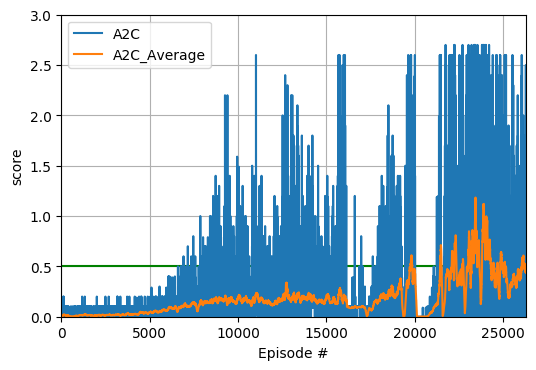

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
def plotScore(data_paths):
    plt.rcParams["figure.dpi"] = 100.0

    num=100
    b=np.ones(num)/num
    a = np.zeros(num-1)

    for path in data_paths:
        data = np.loadtxt(path[1], skiprows=1, usecols=1, delimiter=', \t', dtype='float')
        length = len(data)
        data_mean = np.convolve(np.hstack((a, data)), b, mode='vaild')
        print('At '+ str(np.where(data > 0.5)[0][0] + 1), 'episode', path[0], 'achieved score 0.5')
        print('At '+ str(np.where(data_mean > 0.5)[0][0] + 1), 'episode', path[0], 'achieved average score 0.5')
        plt.plot(np.linspace(1, length, length, endpoint=True), data, label=path[0])
        plt.plot(np.linspace(1, length, length, endpoint=True), data_mean, label=path[0]+"_Average")
    
    plt.xlabel('Episode #')
    plt.ylabel('score')
    plt.legend()
    plt.xlim(0, length)
    plt.ylim(0.0, 3.0)
    plt.grid()
    plt.hlines([0.5], 0, length, "green")
    plt.show()

data_paths = []
data_paths.append(['A2C','results/final/result.txt'])
plotScore(data_paths)

### Watch trained agent and take screenshots

In [ ]:
from PIL import ImageGrab
take_screenshot = False

# Watch trained agent
seed = 1000
env = TennisEnv(seed)
agent = Agent(env, seed)
agent.load('results/final/check_point_26000')

# softplus(-100) = 1.00000e-44 * 3.7835, which means nearly determistic
agent.a2c.std = nn.Parameter(-100*torch.ones(agent.action_size))

num_episode = 100
scores = np.zeros(num_episode)

for i in range(num_episode): 
    state = agent.env.reset(train_mode=False) # reset the environment and get the initial state
    score = np.zeros(agent.env.num_agents)    # initialize the score
    step = 0
    while True:
        _, action, _, _ = agent.a2c.forward(state)    # select an action
        new_state, reward, done = agent.env.one_step_forward(action.detach().squeeze().numpy())
        score = score + reward
        state = new_state
        if take_screenshot:
            if step % 1  == 0: # create screenshot in each step
                filename = "results/26000_episode" + str(i) + "_step" + str(step) + ".png" 
                ImageGrab.grab(bbox=(0, 88, 1280, 804)).save(filename) #Screenshot area to be adjusted in your environment
        step += 1
        if np.any(done):
            scores[i] = np.max(score)
            break
print(scores)
print("Average score: {}".format(np.sum(scores)/num_episode))
agent.env.close()

### Result of 100 episode with determistic actions

Average score: 1.9105000288


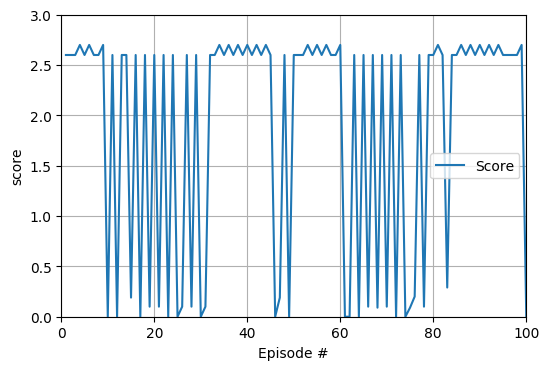

In [4]:
scores = np.loadtxt(fname="results/final/100episodes.csv", dtype="float", delimiter=",")
print("Average score: {}".format(np.sum(scores)/100))

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100.0
length = len(scores)
plt.plot(np.linspace(1, length, length, endpoint=True), scores, label="Score")
plt.xlabel('Episode #')
plt.ylabel('score')
plt.legend()
plt.xlim(0, length)
plt.ylim(0.0, 3.0)
plt.grid()
plt.show()

### Visualize network structure by [graphviz library](https://graphviz.readthedocs.io)

In [ ]:
# pip install graphviz
# conda install python-graphviz

import torch
from torchviz import make_dot

seed = 1
env = TennisEnv()
agent = Agent(env, seed)

x = agent.env.reset(train_mode=False)
out = agent.a2c(x)

dot = make_dot(out, params=dict(agent.a2c.named_parameters()))
dot.format = 'png'
dot.render('content/model')

agent.env.close()